In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.75]
k = 2 * np.pi * 100 / 1500 * 100
L_pml = 0.3
sigma = 5

In [3]:
## hyperparameter
#w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e3)
learning_rate = 2e-5

In [4]:
def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

In [10]:
def get_dataset(Lx, Ly, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    x, y = torch.linspace(-Lx, Lx, 250), torch.linspace(-Ly, Ly, 250)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x0[-len(x):, :], y0[-len(x):, :] = x, y
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)

def data_iter(batch_size, x, y):
    import random as rd
    num = len(x)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id]

In [11]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(- y - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, k, L_pml=L_pml, sigma0=sigma):
    x, y = x.requires_grad_(), y.requires_grad_()
    xy = torch.cat([x, y], dim=-1)

    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)

    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p)
    return (res ** 2).mean()

def green(x, y, src, device=device, is_tensor='True'):
    if is_tensor:
        r = torch.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        r = r.detach().to('cpu').numpy()
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g_real, g_imag = torch.tensor(g_real, dtype=torch.float32), torch.tensor(g_imag, dtype=torch.float32)
        g = torch.cat([g_real, g_imag], dim=-1).to(device)
    else:
        r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g = np.concatenate([g_real, g_imag], axis=-1)
    return g

def loss_bd(model, Lx, Ly, src, n_coll=1000, device=device):
    L = Lx# - L_pml
    x, y = torch.linspace(-L, L, n_coll), Ly * torch.ones(n_coll)
    x, y = torch.cat([x, x], dim=-1), torch.cat([y, -y], dim=-1)
    #y[:int(y.shape[0] / 2)] = -y[:int(x.shape[0] / 2)]
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    res = p + green(x, y, src)
    return (res ** 2).mean()

In [12]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
#import joblib
#state_dict = joblib.load('model_green.joblib')
#model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
#model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lamb = [1, 1]
#loss_bound_hist = []
#loss_pde_hist = []
#loss_src_hist = []
#lamb_bound_hist = []
#lamb_pde_hist = []
#lamb_src_hist = []
l_lst = []
n_lamb_update = 50

In [13]:
n_epochs = int(5e3)
learning_rate = 2e-6
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
#from torch.optim.lr_scheduler import MultiStepLR
#milestones = [1000]
#scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

In [14]:
model = model.to(device)

In [15]:
x0, y0 = get_dataset(Lx, Ly)
i = 0
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    if epoch == 3000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y in data_iter(10000, x0, y0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, k)
        loss_top = loss_bd(model, Lx, Ly, src)
        loss_lst = [loss_pde, loss_top]
        i += 1
        if i % 50 == 0: 
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = lamb[0] * loss_pde + lamb[1] * loss_top
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde: {loss_pde.item()}, Loss_bd: {loss_top.item()}')
    
        l_lst.append(loss)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_29457/681251068.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_29457/681251068.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)
/tmp/ipykernel_29457/2360291907.py:56

Epoch 5, Loss: 308.35614013671875, Loss_pde: 131.98812866210938, Loss_bd: 0.000660970457829535


  0%|          | 10/5000 [00:18<2:37:06,  1.89s/it]

Epoch 10, Loss: 143.59814453125, Loss_pde: 59.380855560302734, Loss_bd: 0.00031047838274389505


  0%|          | 15/5000 [00:26<2:37:22,  1.89s/it]

Epoch 15, Loss: 101.81222534179688, Loss_pde: 46.21920394897461, Loss_bd: 0.00019226457516197115


  0%|          | 20/5000 [00:35<2:37:44,  1.90s/it]

Epoch 20, Loss: 88.55976104736328, Loss_pde: 40.90095520019531, Loss_bd: 0.00013737416884396225


  0%|          | 25/5000 [00:44<2:38:13,  1.91s/it]

Epoch 25, Loss: 73.4903564453125, Loss_pde: 36.22072219848633, Loss_bd: 0.00010451683192513883


  1%|          | 30/5000 [00:53<2:38:23,  1.91s/it]

Epoch 30, Loss: 68.37150573730469, Loss_pde: 34.6190185546875, Loss_bd: 8.997273835120723e-05


  1%|          | 35/5000 [01:02<2:38:36,  1.92s/it]

Epoch 35, Loss: 64.01042175292969, Loss_pde: 29.771020889282227, Loss_bd: 8.293178689200431e-05


  1%|          | 40/5000 [01:11<2:38:48,  1.92s/it]

Epoch 40, Loss: 64.4988784790039, Loss_pde: 30.753414154052734, Loss_bd: 7.550466398242861e-05


  1%|          | 45/5000 [01:20<2:38:43,  1.92s/it]

Epoch 45, Loss: 68.39677429199219, Loss_pde: 31.780593872070312, Loss_bd: 6.683325045742095e-05


  1%|          | 50/5000 [01:29<2:38:48,  1.93s/it]

Epoch 50, Loss: 65.68222045898438, Loss_pde: 31.617042541503906, Loss_bd: 5.880341996089555e-05


  1%|          | 55/5000 [01:39<2:39:04,  1.93s/it]

Epoch 55, Loss: 64.97821044921875, Loss_pde: 32.374603271484375, Loss_bd: 5.286356099531986e-05


  1%|          | 60/5000 [01:48<2:38:56,  1.93s/it]

Epoch 60, Loss: 69.79812622070312, Loss_pde: 32.421844482421875, Loss_bd: 5.086233068141155e-05


  1%|▏         | 65/5000 [01:57<2:38:54,  1.93s/it]

Epoch 65, Loss: 87.66996765136719, Loss_pde: 40.36834716796875, Loss_bd: 4.2818581277970225e-05


  1%|▏         | 70/5000 [02:06<2:38:49,  1.93s/it]

Epoch 70, Loss: 88.99984741210938, Loss_pde: 42.925331115722656, Loss_bd: 2.967849468404893e-05


  2%|▏         | 75/5000 [02:15<2:38:56,  1.94s/it]

Epoch 75, Loss: 108.8084716796875, Loss_pde: 59.97765350341797, Loss_bd: 2.3505435819970444e-05


  2%|▏         | 80/5000 [02:24<2:40:07,  1.95s/it]

Epoch 80, Loss: 108.03091430664062, Loss_pde: 63.57585525512695, Loss_bd: 1.9011946278624237e-05


  2%|▏         | 85/5000 [02:33<2:40:00,  1.95s/it]

Epoch 85, Loss: 123.88419342041016, Loss_pde: 63.183624267578125, Loss_bd: 1.695813625701703e-05


  2%|▏         | 90/5000 [02:43<2:39:41,  1.95s/it]

Epoch 90, Loss: 167.98992919921875, Loss_pde: 102.1894760131836, Loss_bd: 1.5466926925000735e-05


  2%|▏         | 95/5000 [02:52<2:38:35,  1.94s/it]

Epoch 95, Loss: 134.00204467773438, Loss_pde: 88.97330474853516, Loss_bd: 9.36625110625755e-06


  2%|▏         | 100/5000 [03:01<2:38:50,  1.95s/it]

Epoch 100, Loss: 112.48306274414062, Loss_pde: 75.92267608642578, Loss_bd: 6.50287847747677e-06


  2%|▏         | 105/5000 [03:10<2:38:52,  1.95s/it]

Epoch 105, Loss: 150.14739990234375, Loss_pde: 107.74976348876953, Loss_bd: 7.092865871527465e-06


  2%|▏         | 110/5000 [03:19<2:38:40,  1.95s/it]

Epoch 110, Loss: 137.52330017089844, Loss_pde: 110.85025024414062, Loss_bd: 3.901381205650978e-06


  2%|▏         | 115/5000 [03:28<2:39:34,  1.96s/it]

Epoch 115, Loss: 137.85427856445312, Loss_pde: 115.8917007446289, Loss_bd: 3.0292840165202506e-06


  2%|▏         | 120/5000 [03:38<2:43:37,  2.01s/it]

Epoch 120, Loss: 104.02949523925781, Loss_pde: 68.80113220214844, Loss_bd: 4.3922727854806e-06


  2%|▎         | 125/5000 [03:47<2:43:24,  2.01s/it]

Epoch 125, Loss: 99.86629486083984, Loss_pde: 72.35641479492188, Loss_bd: 3.475010089459829e-06


  3%|▎         | 130/5000 [03:57<2:43:19,  2.01s/it]

Epoch 130, Loss: 96.34164428710938, Loss_pde: 69.47293853759766, Loss_bd: 3.4213453545817174e-06


  3%|▎         | 135/5000 [04:06<2:42:31,  2.00s/it]

Epoch 135, Loss: 115.76927185058594, Loss_pde: 66.42086029052734, Loss_bd: 5.8825330597755965e-06


  3%|▎         | 140/5000 [04:16<2:42:15,  2.00s/it]

Epoch 140, Loss: 93.23648834228516, Loss_pde: 76.7541275024414, Loss_bd: 1.9380868252483197e-06


  3%|▎         | 145/5000 [04:25<2:40:26,  1.98s/it]

Epoch 145, Loss: 88.1492919921875, Loss_pde: 69.6801986694336, Loss_bd: 2.2352321593643865e-06


  3%|▎         | 150/5000 [04:34<2:40:06,  1.98s/it]

Epoch 150, Loss: 80.30741882324219, Loss_pde: 65.55905151367188, Loss_bd: 1.5991379314073129e-06


  3%|▎         | 155/5000 [04:44<2:39:56,  1.98s/it]

Epoch 155, Loss: 63.55364990234375, Loss_pde: 46.51121520996094, Loss_bd: 1.9020856143470155e-06


  3%|▎         | 160/5000 [04:53<2:40:43,  1.99s/it]

Epoch 160, Loss: 90.83003997802734, Loss_pde: 74.87492370605469, Loss_bd: 1.7534599692226038e-06


  3%|▎         | 165/5000 [05:03<2:43:27,  2.03s/it]

Epoch 165, Loss: 34.251949310302734, Loss_pde: 29.0098934173584, Loss_bd: 5.43893804660911e-07


  3%|▎         | 170/5000 [05:12<2:43:11,  2.03s/it]

Epoch 170, Loss: 41.906986236572266, Loss_pde: 32.88751220703125, Loss_bd: 9.535605727251095e-07


  4%|▎         | 175/5000 [05:22<2:46:16,  2.07s/it]

Epoch 175, Loss: 51.91421890258789, Loss_pde: 39.59123992919922, Loss_bd: 1.2319964071139111e-06


  4%|▎         | 180/5000 [05:32<2:46:39,  2.07s/it]

Epoch 180, Loss: 46.980369567871094, Loss_pde: 39.29129409790039, Loss_bd: 7.33533454422286e-07


  4%|▎         | 185/5000 [05:42<2:46:21,  2.07s/it]

Epoch 185, Loss: 27.159923553466797, Loss_pde: 21.762664794921875, Loss_bd: 5.232743092165038e-07


  4%|▍         | 190/5000 [05:51<2:46:21,  2.08s/it]

Epoch 190, Loss: 62.246097564697266, Loss_pde: 44.711124420166016, Loss_bd: 1.7420699123249506e-06


  4%|▍         | 195/5000 [06:01<2:46:21,  2.08s/it]

Epoch 195, Loss: 38.12761306762695, Loss_pde: 33.54663848876953, Loss_bd: 4.3185914933019376e-07


  4%|▍         | 200/5000 [06:11<2:46:12,  2.08s/it]

Epoch 200, Loss: 30.829639434814453, Loss_pde: 24.424137115478516, Loss_bd: 6.024932872605859e-07


  4%|▍         | 205/5000 [06:21<2:45:47,  2.07s/it]

Epoch 205, Loss: 43.40361022949219, Loss_pde: 31.006786346435547, Loss_bd: 1.135307229560567e-06


  4%|▍         | 210/5000 [06:30<2:43:25,  2.05s/it]

Epoch 210, Loss: 36.89591598510742, Loss_pde: 30.341392517089844, Loss_bd: 5.570662438003637e-07


  4%|▍         | 215/5000 [06:41<2:53:20,  2.17s/it]

Epoch 215, Loss: 27.551673889160156, Loss_pde: 23.41806411743164, Loss_bd: 3.621969426603755e-07


  4%|▍         | 220/5000 [06:50<2:44:31,  2.07s/it]

Epoch 220, Loss: 20.550981521606445, Loss_pde: 16.645109176635742, Loss_bd: 3.546590789937909e-07


  4%|▍         | 225/5000 [07:01<2:53:09,  2.18s/it]

Epoch 225, Loss: 23.2324275970459, Loss_pde: 18.781171798706055, Loss_bd: 4.065312850798364e-07


  5%|▍         | 230/5000 [07:11<2:51:26,  2.16s/it]

Epoch 230, Loss: 15.443284034729004, Loss_pde: 11.939375877380371, Loss_bd: 3.440910347762838e-07


  5%|▍         | 235/5000 [07:21<2:47:45,  2.11s/it]

Epoch 235, Loss: 16.120126724243164, Loss_pde: 14.06177806854248, Loss_bd: 1.9437986509274197e-07


  5%|▍         | 240/5000 [07:30<2:45:10,  2.08s/it]

Epoch 240, Loss: 22.80325698852539, Loss_pde: 14.732779502868652, Loss_bd: 7.866489681873645e-07


  5%|▍         | 245/5000 [07:40<2:44:31,  2.08s/it]

Epoch 245, Loss: 11.67274284362793, Loss_pde: 10.572857856750488, Loss_bd: 1.0570195740911004e-07


  5%|▌         | 250/5000 [07:50<2:44:40,  2.08s/it]

Epoch 250, Loss: 12.197404861450195, Loss_pde: 10.504839897155762, Loss_bd: 1.5610093839768524e-07


  5%|▌         | 255/5000 [08:00<2:44:12,  2.08s/it]

Epoch 255, Loss: 13.928625106811523, Loss_pde: 11.721930503845215, Loss_bd: 2.0361532904189517e-07


  5%|▌         | 260/5000 [08:10<2:52:07,  2.18s/it]

Epoch 260, Loss: 10.0602388381958, Loss_pde: 8.40572452545166, Loss_bd: 1.5084066262716078e-07


  5%|▌         | 265/5000 [08:20<2:53:20,  2.20s/it]

Epoch 265, Loss: 16.08953285217285, Loss_pde: 11.599018096923828, Loss_bd: 4.076090363014373e-07


  5%|▌         | 270/5000 [08:30<2:45:13,  2.10s/it]

Epoch 270, Loss: 10.03826904296875, Loss_pde: 8.190643310546875, Loss_bd: 1.6721992324164603e-07


  6%|▌         | 275/5000 [08:40<2:44:29,  2.09s/it]

Epoch 275, Loss: 9.328436851501465, Loss_pde: 8.550586700439453, Loss_bd: 6.853340295265298e-08


  6%|▌         | 280/5000 [08:50<2:51:40,  2.18s/it]

Epoch 280, Loss: 8.723512649536133, Loss_pde: 7.594112396240234, Loss_bd: 1.0063222077860701e-07


  6%|▌         | 285/5000 [09:01<2:52:57,  2.20s/it]

Epoch 285, Loss: 9.125469207763672, Loss_pde: 6.844998359680176, Loss_bd: 2.0108247156258585e-07


  6%|▌         | 290/5000 [09:11<2:52:48,  2.20s/it]

Epoch 290, Loss: 33.07664108276367, Loss_pde: 18.382383346557617, Loss_bd: 1.302069790654059e-06


  6%|▌         | 295/5000 [09:22<2:52:35,  2.20s/it]

Epoch 295, Loss: 7.413320541381836, Loss_pde: 5.7086615562438965, Loss_bd: 1.4593395292195055e-07


  6%|▌         | 300/5000 [09:32<2:52:22,  2.20s/it]

Epoch 300, Loss: 7.951417922973633, Loss_pde: 5.929958343505859, Loss_bd: 1.7664066831457603e-07


  6%|▌         | 305/5000 [09:42<2:51:43,  2.19s/it]

Epoch 305, Loss: 9.25051498413086, Loss_pde: 6.395514488220215, Loss_bd: 2.4975301471386047e-07


  6%|▌         | 310/5000 [09:53<2:51:55,  2.20s/it]

Epoch 310, Loss: 7.5523271560668945, Loss_pde: 6.2033281326293945, Loss_bd: 1.1948553435559006e-07


  6%|▋         | 315/5000 [10:03<2:51:45,  2.20s/it]

Epoch 315, Loss: 10.739208221435547, Loss_pde: 7.6877121925354, Loss_bd: 2.6892828941527114e-07


  6%|▋         | 320/5000 [10:13<2:51:37,  2.20s/it]

Epoch 320, Loss: 27.26691436767578, Loss_pde: 13.805418014526367, Loss_bd: 1.1981619536527433e-06


  6%|▋         | 325/5000 [10:23<2:50:12,  2.18s/it]

Epoch 325, Loss: 8.97481918334961, Loss_pde: 5.997742652893066, Loss_bd: 2.651740942383185e-07


  7%|▋         | 330/5000 [10:34<2:51:04,  2.20s/it]

Epoch 330, Loss: 6.287126541137695, Loss_pde: 4.736476898193359, Loss_bd: 1.4077544108204165e-07


  7%|▋         | 335/5000 [10:44<2:51:01,  2.20s/it]

Epoch 335, Loss: 10.8528413772583, Loss_pde: 5.918766021728516, Loss_bd: 4.5412843974190764e-07


  7%|▋         | 340/5000 [10:55<2:50:53,  2.20s/it]

Epoch 340, Loss: 5.761624336242676, Loss_pde: 4.474923133850098, Loss_bd: 1.1936272414914129e-07


  7%|▋         | 345/5000 [11:05<2:50:46,  2.20s/it]

Epoch 345, Loss: 7.457476615905762, Loss_pde: 5.665985107421875, Loss_bd: 1.6337388331066904e-07


  7%|▋         | 350/5000 [11:15<2:50:35,  2.20s/it]

Epoch 350, Loss: 12.378950119018555, Loss_pde: 7.324906826019287, Loss_bd: 4.648198341783427e-07


  7%|▋         | 355/5000 [11:26<2:50:23,  2.20s/it]

Epoch 355, Loss: 7.233414649963379, Loss_pde: 4.614885330200195, Loss_bd: 2.4444418045277416e-07


  7%|▋         | 360/5000 [11:36<2:50:11,  2.20s/it]

Epoch 360, Loss: 3.51015043258667, Loss_pde: 3.1058318614959717, Loss_bd: 3.9331325751845725e-08


  7%|▋         | 365/5000 [11:46<2:49:32,  2.19s/it]

Epoch 365, Loss: 3.929107427597046, Loss_pde: 3.5806171894073486, Loss_bd: 3.134839943186307e-08


  7%|▋         | 370/5000 [11:57<2:49:43,  2.20s/it]

Epoch 370, Loss: 10.745110511779785, Loss_pde: 6.898763656616211, Loss_bd: 3.435510222971061e-07


  8%|▊         | 375/5000 [12:07<2:49:37,  2.20s/it]

Epoch 375, Loss: 4.944601535797119, Loss_pde: 3.8109514713287354, Loss_bd: 9.700538328161201e-08


  8%|▊         | 380/5000 [12:17<2:49:32,  2.20s/it]

Epoch 380, Loss: 10.049293518066406, Loss_pde: 5.740039825439453, Loss_bd: 3.757078275157255e-07


  8%|▊         | 385/5000 [12:28<2:49:19,  2.20s/it]

Epoch 385, Loss: 3.4851911067962646, Loss_pde: 3.1540234088897705, Loss_bd: 2.838311097264068e-08


  8%|▊         | 390/5000 [12:38<2:49:05,  2.20s/it]

Epoch 390, Loss: 2.6766457557678223, Loss_pde: 2.444713592529297, Loss_bd: 2.0074894635513374e-08


  8%|▊         | 395/5000 [12:49<2:48:55,  2.20s/it]

Epoch 395, Loss: 2.9707250595092773, Loss_pde: 2.7056140899658203, Loss_bd: 2.3704091134391092e-08


  8%|▊         | 400/5000 [12:59<2:48:14,  2.19s/it]

Epoch 400, Loss: 2.686668634414673, Loss_pde: 2.455789804458618, Loss_bd: 2.048271952048708e-08


  8%|▊         | 405/5000 [13:09<2:48:29,  2.20s/it]

Epoch 405, Loss: 2.8421785831451416, Loss_pde: 2.486011505126953, Loss_bd: 3.220600319764344e-08


  8%|▊         | 410/5000 [13:20<2:48:21,  2.20s/it]

Epoch 410, Loss: 8.788778305053711, Loss_pde: 4.630827903747559, Loss_bd: 3.8092974818937364e-07


  8%|▊         | 415/5000 [13:30<2:48:12,  2.20s/it]

Epoch 415, Loss: 2.658743143081665, Loss_pde: 2.2920236587524414, Loss_bd: 3.460974440372411e-08


  8%|▊         | 420/5000 [13:40<2:48:03,  2.20s/it]

Epoch 420, Loss: 12.43502426147461, Loss_pde: 6.637540340423584, Loss_bd: 5.485106271407858e-07


  8%|▊         | 425/5000 [13:51<2:47:48,  2.20s/it]

Epoch 425, Loss: 7.88138484954834, Loss_pde: 4.4335856437683105, Loss_bd: 3.2772965141703025e-07


  9%|▊         | 430/5000 [14:01<2:47:41,  2.20s/it]

Epoch 430, Loss: 3.686755895614624, Loss_pde: 2.7796366214752197, Loss_bd: 8.769671921982081e-08


  9%|▊         | 435/5000 [14:11<2:47:27,  2.20s/it]

Epoch 435, Loss: 2.2126693725585938, Loss_pde: 2.005337953567505, Loss_bd: 1.9061179301615994e-08


  9%|▉         | 440/5000 [14:22<2:47:16,  2.20s/it]

Epoch 440, Loss: 12.762468338012695, Loss_pde: 7.626477241516113, Loss_bd: 4.584113924011035e-07


  9%|▉         | 445/5000 [14:32<2:47:07,  2.20s/it]

Epoch 445, Loss: 8.22667407989502, Loss_pde: 4.574193954467773, Loss_bd: 3.3450029945925053e-07


  9%|▉         | 450/5000 [14:43<2:46:42,  2.20s/it]

Epoch 450, Loss: 2.321291208267212, Loss_pde: 2.1055281162261963, Loss_bd: 1.8979081417569432e-08


  9%|▉         | 455/5000 [14:53<2:46:33,  2.20s/it]

Epoch 455, Loss: 2.111595392227173, Loss_pde: 1.9060120582580566, Loss_bd: 1.896051493588402e-08


  9%|▉         | 460/5000 [15:03<2:46:20,  2.20s/it]

Epoch 460, Loss: 2.0429067611694336, Loss_pde: 1.86136794090271, Loss_bd: 1.706053431860255e-08


  9%|▉         | 465/5000 [15:14<2:46:10,  2.20s/it]

Epoch 465, Loss: 1.9563740491867065, Loss_pde: 1.7491679191589355, Loss_bd: 2.0414610446550796e-08


  9%|▉         | 470/5000 [15:24<2:45:57,  2.20s/it]

Epoch 470, Loss: 2.1136250495910645, Loss_pde: 1.880391001701355, Loss_bd: 2.1506458836029196e-08


 10%|▉         | 475/5000 [15:34<2:45:46,  2.20s/it]

Epoch 475, Loss: 12.986310005187988, Loss_pde: 5.836597442626953, Loss_bd: 6.726097581122303e-07


 10%|▉         | 480/5000 [15:45<2:45:35,  2.20s/it]

Epoch 480, Loss: 2.186493396759033, Loss_pde: 1.8246870040893555, Loss_bd: 3.4675949223128555e-08


 10%|▉         | 485/5000 [15:55<2:45:23,  2.20s/it]

Epoch 485, Loss: 1.8799831867218018, Loss_pde: 1.7560597658157349, Loss_bd: 1.1127324839321773e-08


 10%|▉         | 490/5000 [16:05<2:45:21,  2.20s/it]

Epoch 490, Loss: 2.732485771179199, Loss_pde: 1.8914226293563843, Loss_bd: 7.785366307189179e-08


 10%|▉         | 495/5000 [16:16<2:45:12,  2.20s/it]

Epoch 495, Loss: 1.7388862371444702, Loss_pde: 1.5626118183135986, Loss_bd: 1.686549744306376e-08


 10%|█         | 500/5000 [16:26<2:45:02,  2.20s/it]

Epoch 500, Loss: 1.8908334970474243, Loss_pde: 1.6545038223266602, Loss_bd: 2.2057980331169347e-08


 10%|█         | 505/5000 [16:36<2:44:52,  2.20s/it]

Epoch 505, Loss: 2.90016770362854, Loss_pde: 1.9512062072753906, Loss_bd: 9.1554923642434e-08


 10%|█         | 510/5000 [16:47<2:44:47,  2.20s/it]

Epoch 510, Loss: 1.7535059452056885, Loss_pde: 1.5413060188293457, Loss_bd: 2.122060038800555e-08


 10%|█         | 515/5000 [16:57<2:44:37,  2.20s/it]

Epoch 515, Loss: 1.9928165674209595, Loss_pde: 1.651076078414917, Loss_bd: 3.349797594864867e-08


 10%|█         | 520/5000 [17:08<2:44:27,  2.20s/it]

Epoch 520, Loss: 3.6681039333343506, Loss_pde: 2.14784574508667, Loss_bd: 1.5172449252531806e-07


 10%|█         | 525/5000 [17:18<2:44:11,  2.20s/it]

Epoch 525, Loss: 17.48398208618164, Loss_pde: 8.481677055358887, Loss_bd: 8.953466590355674e-07


 11%|█         | 530/5000 [17:28<2:44:04,  2.20s/it]

Epoch 530, Loss: 3.0071184635162354, Loss_pde: 2.212951183319092, Loss_bd: 7.726722373035955e-08


 11%|█         | 535/5000 [17:39<2:43:53,  2.20s/it]

Epoch 535, Loss: 8.111605644226074, Loss_pde: 3.457556962966919, Loss_bd: 4.61806280327437e-07


 11%|█         | 540/5000 [17:49<2:43:42,  2.20s/it]

Epoch 540, Loss: 2.151336431503296, Loss_pde: 1.642329216003418, Loss_bd: 5.083398946226225e-08


 11%|█         | 545/5000 [18:00<2:43:33,  2.20s/it]

Epoch 545, Loss: 3.530120849609375, Loss_pde: 2.2361302375793457, Loss_bd: 1.3091974437884346e-07


 11%|█         | 550/5000 [18:10<2:43:21,  2.20s/it]

Epoch 550, Loss: 2.2823119163513184, Loss_pde: 1.6431858539581299, Loss_bd: 6.267620022981646e-08


 11%|█         | 555/5000 [18:20<2:43:11,  2.20s/it]

Epoch 555, Loss: 7.179360866546631, Loss_pde: 3.9052624702453613, Loss_bd: 3.188889081684465e-07


 11%|█         | 560/5000 [18:31<2:42:57,  2.20s/it]

Epoch 560, Loss: 4.961468696594238, Loss_pde: 3.318596363067627, Loss_bd: 1.5050846968733822e-07


 11%|█▏        | 565/5000 [18:41<2:42:46,  2.20s/it]

Epoch 565, Loss: 5.426118850708008, Loss_pde: 2.948195695877075, Loss_bd: 2.3645780800052307e-07


 11%|█▏        | 570/5000 [18:51<2:42:35,  2.20s/it]

Epoch 570, Loss: 1.5881208181381226, Loss_pde: 1.279746413230896, Loss_bd: 3.0528198635693116e-08


 12%|█▏        | 575/5000 [19:02<2:42:25,  2.20s/it]

Epoch 575, Loss: 1.564234733581543, Loss_pde: 1.3580090999603271, Loss_bd: 1.9879033530401102e-08


 12%|█▏        | 580/5000 [19:12<2:42:14,  2.20s/it]

Epoch 580, Loss: 14.11716079711914, Loss_pde: 8.89845085144043, Loss_bd: 4.82252289657481e-07


 12%|█▏        | 585/5000 [19:23<2:42:05,  2.20s/it]

Epoch 585, Loss: 11.91761589050293, Loss_pde: 6.100088119506836, Loss_bd: 5.264559490569809e-07


 12%|█▏        | 590/5000 [19:33<2:41:57,  2.20s/it]

Epoch 590, Loss: 2.3523306846618652, Loss_pde: 1.6909538507461548, Loss_bd: 5.99290430614019e-08


 12%|█▏        | 595/5000 [19:43<2:41:46,  2.20s/it]

Epoch 595, Loss: 1.5377107858657837, Loss_pde: 1.3083288669586182, Loss_bd: 2.0283945190158192e-08


 12%|█▏        | 600/5000 [19:54<2:41:35,  2.20s/it]

Epoch 600, Loss: 4.970680236816406, Loss_pde: 2.547990083694458, Loss_bd: 2.1474387779107929e-07


 12%|█▏        | 605/5000 [20:04<2:41:21,  2.20s/it]

Epoch 605, Loss: 3.3558549880981445, Loss_pde: 2.114084005355835, Loss_bd: 1.0848863496448757e-07


 12%|█▏        | 610/5000 [20:14<2:41:11,  2.20s/it]

Epoch 610, Loss: 3.743363380432129, Loss_pde: 2.2789804935455322, Loss_bd: 1.2664557402786158e-07


 12%|█▏        | 615/5000 [20:25<2:40:59,  2.20s/it]

Epoch 615, Loss: 3.646738052368164, Loss_pde: 1.9845634698867798, Loss_bd: 1.4938484582671663e-07


 12%|█▏        | 620/5000 [20:35<2:40:45,  2.20s/it]

Epoch 620, Loss: 1.2666231393814087, Loss_pde: 1.124953269958496, Loss_bd: 1.3173047541670257e-08


 12%|█▎        | 625/5000 [20:46<2:40:37,  2.20s/it]

Epoch 625, Loss: 1.7268640995025635, Loss_pde: 1.1507055759429932, Loss_bd: 5.5054648839814035e-08


 13%|█▎        | 630/5000 [20:56<2:40:27,  2.20s/it]

Epoch 630, Loss: 7.596226692199707, Loss_pde: 4.187251091003418, Loss_bd: 3.216272261852282e-07


 13%|█▎        | 635/5000 [21:06<2:40:15,  2.20s/it]

Epoch 635, Loss: 2.4158973693847656, Loss_pde: 1.6660081148147583, Loss_bd: 7.36634220288579e-08


 13%|█▎        | 640/5000 [21:17<2:40:05,  2.20s/it]

Epoch 640, Loss: 1.3930554389953613, Loss_pde: 1.1911321878433228, Loss_bd: 1.9563849207315798e-08


 13%|█▎        | 645/5000 [21:27<2:39:51,  2.20s/it]

Epoch 645, Loss: 3.608001232147217, Loss_pde: 2.1500580310821533, Loss_bd: 1.4138714732325752e-07


 13%|█▎        | 650/5000 [21:38<2:39:44,  2.20s/it]

Epoch 650, Loss: 2.92574405670166, Loss_pde: 1.8398939371109009, Loss_bd: 1.0525240412562198e-07


 13%|█▎        | 655/5000 [21:48<2:39:31,  2.20s/it]

Epoch 655, Loss: 9.932527542114258, Loss_pde: 5.333320140838623, Loss_bd: 4.5043577756587183e-07


 13%|█▎        | 660/5000 [21:58<2:39:22,  2.20s/it]

Epoch 660, Loss: 1.9116532802581787, Loss_pde: 1.3908381462097168, Loss_bd: 4.96702057262155e-08


 13%|█▎        | 665/5000 [22:09<2:39:09,  2.20s/it]

Epoch 665, Loss: 8.751684188842773, Loss_pde: 4.695121765136719, Loss_bd: 3.7840749200768187e-07


 13%|█▎        | 670/5000 [22:19<2:39:01,  2.20s/it]

Epoch 670, Loss: 2.278438091278076, Loss_pde: 1.41782808303833, Loss_bd: 8.092624881328447e-08


 14%|█▎        | 675/5000 [22:29<2:38:46,  2.20s/it]

Epoch 675, Loss: 4.472902297973633, Loss_pde: 2.4780385494232178, Loss_bd: 1.8656909617220663e-07


 14%|█▎        | 680/5000 [22:40<2:38:37,  2.20s/it]

Epoch 680, Loss: 3.25588321685791, Loss_pde: 2.020465850830078, Loss_bd: 1.1674877953282703e-07


 14%|█▎        | 685/5000 [22:50<2:38:27,  2.20s/it]

Epoch 685, Loss: 6.830093860626221, Loss_pde: 3.199331283569336, Loss_bd: 3.3114204711637285e-07


 14%|█▍        | 690/5000 [23:01<2:38:14,  2.20s/it]

Epoch 690, Loss: 5.584175109863281, Loss_pde: 2.9911608695983887, Loss_bd: 2.4230217832155176e-07


 14%|█▍        | 695/5000 [23:11<2:38:05,  2.20s/it]

Epoch 695, Loss: 1.9578850269317627, Loss_pde: 1.293684959411621, Loss_bd: 6.137955210760992e-08


 14%|█▍        | 700/5000 [23:21<2:37:55,  2.20s/it]

Epoch 700, Loss: 16.452852249145508, Loss_pde: 5.057426452636719, Loss_bd: 1.0615119663270889e-06


 14%|█▍        | 705/5000 [23:32<2:37:42,  2.20s/it]

Epoch 705, Loss: 2.315138578414917, Loss_pde: 1.5065722465515137, Loss_bd: 7.263005130653255e-08


 14%|█▍        | 710/5000 [23:42<2:37:30,  2.20s/it]

Epoch 710, Loss: 5.253902912139893, Loss_pde: 2.6172049045562744, Loss_bd: 2.353545767164178e-07


 14%|█▍        | 715/5000 [23:53<2:37:22,  2.20s/it]

Epoch 715, Loss: 1.705918312072754, Loss_pde: 1.0002717971801758, Loss_bd: 6.75376270464767e-08


 14%|█▍        | 720/5000 [24:03<2:37:09,  2.20s/it]

Epoch 720, Loss: 0.9607860445976257, Loss_pde: 0.8486423492431641, Loss_bd: 9.8479109311711e-09


 14%|█▍        | 725/5000 [24:13<2:36:55,  2.20s/it]

Epoch 725, Loss: 7.557092666625977, Loss_pde: 3.964531421661377, Loss_bd: 3.1007107281766366e-07


 15%|█▍        | 730/5000 [24:24<2:36:44,  2.20s/it]

Epoch 730, Loss: 1.7954027652740479, Loss_pde: 1.241584300994873, Loss_bd: 4.791179719632055e-08


 15%|█▍        | 735/5000 [24:34<2:36:36,  2.20s/it]

Epoch 735, Loss: 1.2135285139083862, Loss_pde: 0.9424313306808472, Loss_bd: 2.432146040121097e-08


 15%|█▍        | 740/5000 [24:44<2:36:23,  2.20s/it]

Epoch 740, Loss: 2.254499912261963, Loss_pde: 1.6561980247497559, Loss_bd: 5.1255657496085405e-08


 15%|█▍        | 745/5000 [24:55<2:36:13,  2.20s/it]

Epoch 745, Loss: 3.436847686767578, Loss_pde: 1.956714391708374, Loss_bd: 1.3151962718893628e-07


 15%|█▌        | 750/5000 [25:05<2:36:04,  2.20s/it]

Epoch 750, Loss: 1.1677415370941162, Loss_pde: 0.9130328893661499, Loss_bd: 2.315876379554993e-08


 15%|█▌        | 755/5000 [25:16<2:35:53,  2.20s/it]

Epoch 755, Loss: 1.037601351737976, Loss_pde: 0.8964995741844177, Loss_bd: 1.303875141189792e-08


 15%|█▌        | 760/5000 [25:26<2:35:45,  2.20s/it]

Epoch 760, Loss: 1.0086196660995483, Loss_pde: 0.8384209871292114, Loss_bd: 1.6254483981015255e-08


 15%|█▌        | 765/5000 [25:36<2:35:30,  2.20s/it]

Epoch 765, Loss: 0.923791229724884, Loss_pde: 0.8082887530326843, Loss_bd: 1.143299588335367e-08


 15%|█▌        | 770/5000 [25:47<2:35:17,  2.20s/it]

Epoch 770, Loss: 0.8801324963569641, Loss_pde: 0.8117765188217163, Loss_bd: 7.059070217252383e-09


 16%|█▌        | 775/5000 [25:57<2:35:07,  2.20s/it]

Epoch 775, Loss: 0.9166176915168762, Loss_pde: 0.8370454907417297, Loss_bd: 7.471348872911676e-09


 16%|█▌        | 780/5000 [26:07<2:34:58,  2.20s/it]

Epoch 780, Loss: 6.871044158935547, Loss_pde: 3.3794779777526855, Loss_bd: 3.265830628151889e-07


 16%|█▌        | 785/5000 [26:18<2:34:48,  2.20s/it]

Epoch 785, Loss: 1.2350467443466187, Loss_pde: 1.0228955745697021, Loss_bd: 1.9929380812300224e-08


 16%|█▌        | 790/5000 [26:28<2:34:37,  2.20s/it]

Epoch 790, Loss: 0.8408717513084412, Loss_pde: 0.7896512150764465, Loss_bd: 4.9165405080486835e-09


 16%|█▌        | 795/5000 [26:39<2:34:25,  2.20s/it]

Epoch 795, Loss: 1.1727780103683472, Loss_pde: 0.8632479310035706, Loss_bd: 3.0294486919046903e-08


 16%|█▌        | 800/5000 [26:49<2:34:11,  2.20s/it]

Epoch 800, Loss: 1.7728317975997925, Loss_pde: 1.339959979057312, Loss_bd: 4.044817814019552e-08


 16%|█▌        | 805/5000 [26:59<2:34:01,  2.20s/it]

Epoch 805, Loss: 6.50674295425415, Loss_pde: 3.1942052841186523, Loss_bd: 3.112754995981959e-07


 16%|█▌        | 810/5000 [27:10<2:33:53,  2.20s/it]

Epoch 810, Loss: 1.2305635213851929, Loss_pde: 0.9079897999763489, Loss_bd: 3.090945455141991e-08


 16%|█▋        | 815/5000 [27:20<2:33:41,  2.20s/it]

Epoch 815, Loss: 1.0880029201507568, Loss_pde: 0.8754904270172119, Loss_bd: 1.974448338160073e-08


 16%|█▋        | 820/5000 [27:31<2:33:31,  2.20s/it]

Epoch 820, Loss: 1.8907661437988281, Loss_pde: 1.1447885036468506, Loss_bd: 6.786364536992551e-08


 16%|█▋        | 825/5000 [27:41<2:33:18,  2.20s/it]

Epoch 825, Loss: 1.7397435903549194, Loss_pde: 1.1698296070098877, Loss_bd: 4.9712902239207324e-08


 17%|█▋        | 830/5000 [27:51<2:33:07,  2.20s/it]

Epoch 830, Loss: 11.806463241577148, Loss_pde: 6.07149600982666, Loss_bd: 5.046320552537509e-07


 17%|█▋        | 835/5000 [28:02<2:32:55,  2.20s/it]

Epoch 835, Loss: 2.3874034881591797, Loss_pde: 1.4108248949050903, Loss_bd: 8.653685057424809e-08


 17%|█▋        | 840/5000 [28:12<2:32:45,  2.20s/it]

Epoch 840, Loss: 0.8540652990341187, Loss_pde: 0.7464624047279358, Loss_bd: 9.564685932161865e-09


 17%|█▋        | 845/5000 [28:22<2:32:36,  2.20s/it]

Epoch 845, Loss: 2.9383649826049805, Loss_pde: 1.8827260732650757, Loss_bd: 8.904210346827313e-08


 17%|█▋        | 850/5000 [28:33<2:32:23,  2.20s/it]

Epoch 850, Loss: 2.012653112411499, Loss_pde: 1.0570993423461914, Loss_bd: 8.46694021561234e-08


 17%|█▋        | 855/5000 [28:43<2:32:11,  2.20s/it]

Epoch 855, Loss: 0.825927197933197, Loss_pde: 0.7009131908416748, Loss_bd: 1.0996018318110146e-08


 17%|█▋        | 860/5000 [28:54<2:32:03,  2.20s/it]

Epoch 860, Loss: 1.6070315837860107, Loss_pde: 0.9993380904197693, Loss_bd: 5.2891476087779665e-08


 17%|█▋        | 865/5000 [29:04<2:31:53,  2.20s/it]

Epoch 865, Loss: 7.226984024047852, Loss_pde: 2.815922260284424, Loss_bd: 3.9766877080182894e-07


 17%|█▋        | 870/5000 [29:14<2:31:30,  2.20s/it]

Epoch 870, Loss: 1.1113593578338623, Loss_pde: 0.8601607084274292, Loss_bd: 2.209917049356136e-08


 18%|█▊        | 875/5000 [29:25<2:31:26,  2.20s/it]

Epoch 875, Loss: 7.270119667053223, Loss_pde: 3.1228010654449463, Loss_bd: 3.695800216974021e-07


 18%|█▊        | 880/5000 [29:35<2:31:16,  2.20s/it]

Epoch 880, Loss: 5.397212982177734, Loss_pde: 2.453019380569458, Loss_bd: 2.6149811560571834e-07


 18%|█▊        | 885/5000 [29:46<2:31:09,  2.20s/it]

Epoch 885, Loss: 15.746736526489258, Loss_pde: 6.511935710906982, Loss_bd: 8.485604325869645e-07


 18%|█▊        | 890/5000 [29:56<2:30:58,  2.20s/it]

Epoch 890, Loss: 1.317251443862915, Loss_pde: 0.8730185031890869, Loss_bd: 4.0314386495765575e-08


 18%|█▊        | 895/5000 [30:06<2:30:47,  2.20s/it]

Epoch 895, Loss: 18.104747772216797, Loss_pde: 8.430989265441895, Loss_bd: 8.698182227817597e-07


 18%|█▊        | 900/5000 [30:17<2:30:36,  2.20s/it]

Epoch 900, Loss: 1.9903621673583984, Loss_pde: 1.029813289642334, Loss_bd: 9.192437744331983e-08


 18%|█▊        | 905/5000 [30:27<2:30:26,  2.20s/it]

Epoch 905, Loss: 0.9902252554893494, Loss_pde: 0.7733336687088013, Loss_bd: 2.054571623943957e-08


 18%|█▊        | 910/5000 [30:37<2:30:12,  2.20s/it]

Epoch 910, Loss: 2.953709363937378, Loss_pde: 1.63297438621521, Loss_bd: 1.235905529028969e-07


 18%|█▊        | 915/5000 [30:48<2:29:59,  2.20s/it]

Epoch 915, Loss: 4.359190464019775, Loss_pde: 2.096803903579712, Loss_bd: 2.116068742452626e-07


 18%|█▊        | 920/5000 [30:58<2:29:44,  2.20s/it]

Epoch 920, Loss: 2.452108144760132, Loss_pde: 1.227476954460144, Loss_bd: 1.1652231535208557e-07


 18%|█▊        | 925/5000 [31:09<2:29:40,  2.20s/it]

Epoch 925, Loss: 1.7241742610931396, Loss_pde: 1.0831298828125, Loss_bd: 6.172491850975348e-08


 19%|█▊        | 930/5000 [31:19<2:29:25,  2.20s/it]

Epoch 930, Loss: 2.139160633087158, Loss_pde: 1.2193421125411987, Loss_bd: 8.931763773034618e-08


 19%|█▊        | 935/5000 [31:29<2:29:17,  2.20s/it]

Epoch 935, Loss: 3.963838815689087, Loss_pde: 1.9041402339935303, Loss_bd: 2.005359363010939e-07


 19%|█▉        | 940/5000 [31:40<2:29:07,  2.20s/it]

Epoch 940, Loss: 1.5278342962265015, Loss_pde: 0.9299114942550659, Loss_bd: 5.764566779475899e-08


 19%|█▉        | 945/5000 [31:50<2:28:55,  2.20s/it]

Epoch 945, Loss: 5.312104225158691, Loss_pde: 2.1991539001464844, Loss_bd: 3.1299953207053477e-07


 19%|█▉        | 950/5000 [32:01<2:28:44,  2.20s/it]

Epoch 950, Loss: 0.9151407480239868, Loss_pde: 0.7464386820793152, Loss_bd: 1.6750695053247e-08


 19%|█▉        | 955/5000 [32:11<2:28:32,  2.20s/it]

Epoch 955, Loss: 1.3367799520492554, Loss_pde: 0.8976992964744568, Loss_bd: 4.326411939814534e-08


 19%|█▉        | 960/5000 [32:21<2:28:25,  2.20s/it]

Epoch 960, Loss: 5.864168167114258, Loss_pde: 3.347701072692871, Loss_bd: 2.3625098322099802e-07


 19%|█▉        | 965/5000 [32:32<2:28:11,  2.20s/it]

Epoch 965, Loss: 5.4494500160217285, Loss_pde: 3.19962215423584, Loss_bd: 2.088657709009567e-07


 19%|█▉        | 970/5000 [32:42<2:27:55,  2.20s/it]

Epoch 970, Loss: 1.9416122436523438, Loss_pde: 1.2215386629104614, Loss_bd: 6.417181452889054e-08


 20%|█▉        | 975/5000 [32:52<2:27:46,  2.20s/it]

Epoch 975, Loss: 2.9180335998535156, Loss_pde: 1.4262028932571411, Loss_bd: 1.3930790032645746e-07


 20%|█▉        | 980/5000 [33:03<2:27:36,  2.20s/it]

Epoch 980, Loss: 0.8006893992424011, Loss_pde: 0.6514049172401428, Loss_bd: 1.45678864527099e-08


 20%|█▉        | 985/5000 [33:13<2:27:25,  2.20s/it]

Epoch 985, Loss: 0.7320257425308228, Loss_pde: 0.6286589503288269, Loss_bd: 1.0093425650836707e-08


 20%|█▉        | 990/5000 [33:24<2:27:17,  2.20s/it]

Epoch 990, Loss: 0.9718120098114014, Loss_pde: 0.7334672808647156, Loss_bd: 2.2527824938833874e-08


 20%|█▉        | 995/5000 [33:34<2:27:05,  2.20s/it]

Epoch 995, Loss: 4.112437725067139, Loss_pde: 1.9350289106369019, Loss_bd: 2.0860500171693275e-07


 20%|██        | 1000/5000 [33:44<2:26:53,  2.20s/it]

Epoch 1000, Loss: 1.0796520709991455, Loss_pde: 0.770094633102417, Loss_bd: 3.086165989429901e-08


 20%|██        | 1005/5000 [33:55<2:26:42,  2.20s/it]

Epoch 1005, Loss: 8.416763305664062, Loss_pde: 6.932587146759033, Loss_bd: 1.5377794682081003e-07


 20%|██        | 1010/5000 [34:05<2:26:30,  2.20s/it]

Epoch 1010, Loss: 2.8075623512268066, Loss_pde: 2.200836181640625, Loss_bd: 6.49307452249559e-08


 20%|██        | 1015/5000 [34:16<2:26:19,  2.20s/it]

Epoch 1015, Loss: 1.0687386989593506, Loss_pde: 1.0001667737960815, Loss_bd: 7.02250080308886e-09


 20%|██        | 1020/5000 [34:26<2:26:03,  2.20s/it]

Epoch 1020, Loss: 1.0180898904800415, Loss_pde: 0.9914942383766174, Loss_bd: 2.7813498171269657e-09


 20%|██        | 1025/5000 [34:36<2:25:59,  2.20s/it]

Epoch 1025, Loss: 0.9171403050422668, Loss_pde: 0.8772398233413696, Loss_bd: 4.067939318730396e-09


 21%|██        | 1030/5000 [34:47<2:25:53,  2.20s/it]

Epoch 1030, Loss: 0.7467640042304993, Loss_pde: 0.7169259786605835, Loss_bd: 3.029858142156172e-09


 21%|██        | 1035/5000 [34:57<2:25:38,  2.20s/it]

Epoch 1035, Loss: 0.6882345080375671, Loss_pde: 0.6650877594947815, Loss_bd: 2.3825910133723482e-09


 21%|██        | 1040/5000 [35:07<2:25:29,  2.20s/it]

Epoch 1040, Loss: 0.67484450340271, Loss_pde: 0.6396938562393188, Loss_bd: 3.785669555611548e-09


 21%|██        | 1045/5000 [35:18<2:25:17,  2.20s/it]

Epoch 1045, Loss: 0.587175190448761, Loss_pde: 0.5647947192192078, Loss_bd: 2.2885529027405482e-09


 21%|██        | 1050/5000 [35:28<2:25:06,  2.20s/it]

Epoch 1050, Loss: 0.5883271098136902, Loss_pde: 0.5643827319145203, Loss_bd: 2.4977704349282703e-09


 21%|██        | 1055/5000 [35:39<2:24:52,  2.20s/it]

Epoch 1055, Loss: 0.5815000534057617, Loss_pde: 0.5569229125976562, Loss_bd: 2.5427357996932187e-09


 21%|██        | 1060/5000 [35:49<2:24:41,  2.20s/it]

Epoch 1060, Loss: 0.6620705127716064, Loss_pde: 0.6001906394958496, Loss_bd: 6.271007269020856e-09


 21%|██▏       | 1065/5000 [35:59<2:24:31,  2.20s/it]

Epoch 1065, Loss: 0.6382321715354919, Loss_pde: 0.598503589630127, Loss_bd: 3.911899693065379e-09


 21%|██▏       | 1070/5000 [36:10<2:24:21,  2.20s/it]

Epoch 1070, Loss: 0.6872466802597046, Loss_pde: 0.6065927147865295, Loss_bd: 7.783088840085384e-09


 22%|██▏       | 1075/5000 [36:20<2:24:09,  2.20s/it]

Epoch 1075, Loss: 0.6379176378250122, Loss_pde: 0.5582939386367798, Loss_bd: 7.727094519793809e-09


 22%|██▏       | 1080/5000 [36:31<2:23:59,  2.20s/it]

Epoch 1080, Loss: 0.6201527118682861, Loss_pde: 0.5582743287086487, Loss_bd: 5.639114064592832e-09


 22%|██▏       | 1085/5000 [36:41<2:23:50,  2.20s/it]

Epoch 1085, Loss: 0.7709410786628723, Loss_pde: 0.6213902235031128, Loss_bd: 1.3698597811639956e-08


 22%|██▏       | 1090/5000 [36:51<2:23:33,  2.20s/it]

Epoch 1090, Loss: 0.5047638416290283, Loss_pde: 0.477011114358902, Loss_bd: 2.6689082055497693e-09


 22%|██▏       | 1095/5000 [37:02<2:23:25,  2.20s/it]

Epoch 1095, Loss: 0.5161420702934265, Loss_pde: 0.48215368390083313, Loss_bd: 3.271143800276377e-09


 22%|██▏       | 1100/5000 [37:12<2:23:12,  2.20s/it]

Epoch 1100, Loss: 0.5429471135139465, Loss_pde: 0.5065016150474548, Loss_bd: 3.3449774061722337e-09


 22%|██▏       | 1105/5000 [37:22<2:23:01,  2.20s/it]

Epoch 1105, Loss: 0.5404099822044373, Loss_pde: 0.4931451082229614, Loss_bd: 4.425457778012287e-09


 22%|██▏       | 1110/5000 [37:33<2:22:50,  2.20s/it]

Epoch 1110, Loss: 1.5803966522216797, Loss_pde: 0.665584921836853, Loss_bd: 8.860465783300242e-08


 22%|██▏       | 1115/5000 [37:43<2:22:39,  2.20s/it]

Epoch 1115, Loss: 2.199082374572754, Loss_pde: 1.2858483791351318, Loss_bd: 8.702475184918512e-08


 22%|██▏       | 1120/5000 [37:54<2:22:30,  2.20s/it]

Epoch 1120, Loss: 0.6447230577468872, Loss_pde: 0.5533660650253296, Loss_bd: 8.378890470339684e-09


 22%|██▎       | 1125/5000 [38:04<2:22:18,  2.20s/it]

Epoch 1125, Loss: 0.9387388229370117, Loss_pde: 0.6252923607826233, Loss_bd: 2.8628237558336878e-08


 23%|██▎       | 1130/5000 [38:14<2:22:08,  2.20s/it]

Epoch 1130, Loss: 1.564823865890503, Loss_pde: 0.8933295607566833, Loss_bd: 6.175978484179723e-08


 23%|██▎       | 1135/5000 [38:25<2:21:57,  2.20s/it]

Epoch 1135, Loss: 0.9910976886749268, Loss_pde: 0.6388805508613586, Loss_bd: 3.282405813820333e-08


 23%|██▎       | 1140/5000 [38:35<2:21:38,  2.20s/it]

Epoch 1140, Loss: 0.9405492544174194, Loss_pde: 0.5943341851234436, Loss_bd: 3.2909301950212466e-08


 23%|██▎       | 1145/5000 [38:46<2:21:31,  2.20s/it]

Epoch 1145, Loss: 3.6510977745056152, Loss_pde: 1.8558987379074097, Loss_bd: 1.6934453128669702e-07


 23%|██▎       | 1150/5000 [38:56<2:21:23,  2.20s/it]

Epoch 1150, Loss: 0.7828853130340576, Loss_pde: 0.6052017211914062, Loss_bd: 1.5439267642136656e-08


 23%|██▎       | 1155/5000 [39:06<2:21:13,  2.20s/it]

Epoch 1155, Loss: 0.9424006938934326, Loss_pde: 0.678257942199707, Loss_bd: 2.350514805016246e-08


 23%|██▎       | 1160/5000 [39:17<2:21:02,  2.20s/it]

Epoch 1160, Loss: 0.5109902620315552, Loss_pde: 0.45545607805252075, Loss_bd: 5.166862937500127e-09


 23%|██▎       | 1165/5000 [39:27<2:20:50,  2.20s/it]

Epoch 1165, Loss: 0.4719069004058838, Loss_pde: 0.43316951394081116, Loss_bd: 3.5759353256281656e-09


 23%|██▎       | 1170/5000 [39:37<2:20:40,  2.20s/it]

Epoch 1170, Loss: 0.6381313800811768, Loss_pde: 0.5225105881690979, Loss_bd: 1.0434061614716938e-08


 24%|██▎       | 1175/5000 [39:48<2:20:30,  2.20s/it]

Epoch 1175, Loss: 0.7414743304252625, Loss_pde: 0.5697594285011292, Loss_bd: 1.536894345122164e-08


 24%|██▎       | 1180/5000 [39:58<2:20:17,  2.20s/it]

Epoch 1180, Loss: 0.6684389114379883, Loss_pde: 0.48714178800582886, Loss_bd: 1.6646360734284826e-08


 24%|██▎       | 1185/5000 [40:09<2:20:06,  2.20s/it]

Epoch 1185, Loss: 2.0379579067230225, Loss_pde: 1.058066725730896, Loss_bd: 9.001585254964084e-08


 24%|██▍       | 1190/5000 [40:19<2:19:53,  2.20s/it]

Epoch 1190, Loss: 1.3953572511672974, Loss_pde: 0.6796839833259583, Loss_bd: 6.854870093775389e-08


 24%|██▍       | 1195/5000 [40:29<2:19:41,  2.20s/it]

Epoch 1195, Loss: 0.5801993012428284, Loss_pde: 0.48436689376831055, Loss_bd: 9.602836748001664e-09


 24%|██▍       | 1200/5000 [40:40<2:19:34,  2.20s/it]

Epoch 1200, Loss: 0.7030260562896729, Loss_pde: 0.5481089353561401, Loss_bd: 1.5234066452762818e-08


 24%|██▍       | 1205/5000 [40:50<2:19:21,  2.20s/it]

Epoch 1205, Loss: 2.3150501251220703, Loss_pde: 1.2992380857467651, Loss_bd: 9.780211485121981e-08


 24%|██▍       | 1210/5000 [41:01<2:19:10,  2.20s/it]

Epoch 1210, Loss: 1.162593960762024, Loss_pde: 0.7233275175094604, Loss_bd: 4.366906480868238e-08


 24%|██▍       | 1215/5000 [41:11<2:19:00,  2.20s/it]

Epoch 1215, Loss: 0.6166163682937622, Loss_pde: 0.49130555987358093, Loss_bd: 1.1876573502433985e-08


 24%|██▍       | 1220/5000 [41:21<2:18:51,  2.20s/it]

Epoch 1220, Loss: 0.863465428352356, Loss_pde: 0.5884373784065247, Loss_bd: 2.6128251562340665e-08


 24%|██▍       | 1225/5000 [41:32<2:18:38,  2.20s/it]

Epoch 1225, Loss: 1.7835825681686401, Loss_pde: 0.8354267477989197, Loss_bd: 9.243119336588279e-08


 25%|██▍       | 1230/5000 [41:42<2:18:28,  2.20s/it]

Epoch 1230, Loss: 1.3104808330535889, Loss_pde: 0.888584554195404, Loss_bd: 3.8941426083738406e-08


 25%|██▍       | 1235/5000 [41:52<2:18:15,  2.20s/it]

Epoch 1235, Loss: 1.7876240015029907, Loss_pde: 0.952833354473114, Loss_bd: 7.157270687230266e-08


 25%|██▍       | 1240/5000 [42:03<2:18:06,  2.20s/it]

Epoch 1240, Loss: 0.9858496189117432, Loss_pde: 0.6012916564941406, Loss_bd: 3.287606276103361e-08


 25%|██▍       | 1245/5000 [42:13<2:17:54,  2.20s/it]

Epoch 1245, Loss: 0.8120946884155273, Loss_pde: 0.5194205045700073, Loss_bd: 2.5365283207179345e-08


 25%|██▌       | 1250/5000 [42:24<2:17:43,  2.20s/it]

Epoch 1250, Loss: 2.5293822288513184, Loss_pde: 1.0451126098632812, Loss_bd: 1.311374973056445e-07


 25%|██▌       | 1255/5000 [42:34<2:17:34,  2.20s/it]

Epoch 1255, Loss: 0.6688044667243958, Loss_pde: 0.41556161642074585, Loss_bd: 2.366269491460571e-08


 25%|██▌       | 1260/5000 [42:44<2:17:16,  2.20s/it]

Epoch 1260, Loss: 0.5644791126251221, Loss_pde: 0.4399518072605133, Loss_bd: 1.2119828696199875e-08


 25%|██▌       | 1265/5000 [42:55<2:17:06,  2.20s/it]

Epoch 1265, Loss: 0.9853085279464722, Loss_pde: 0.6736785173416138, Loss_bd: 2.9449171989881506e-08


 25%|██▌       | 1270/5000 [43:05<2:16:56,  2.20s/it]

Epoch 1270, Loss: 0.5964626669883728, Loss_pde: 0.4783787131309509, Loss_bd: 1.0582053455721052e-08


 26%|██▌       | 1275/5000 [43:16<2:16:45,  2.20s/it]

Epoch 1275, Loss: 1.519601821899414, Loss_pde: 0.8260929584503174, Loss_bd: 6.390781948084623e-08


 26%|██▌       | 1280/5000 [43:26<2:16:36,  2.20s/it]

Epoch 1280, Loss: 0.6260838508605957, Loss_pde: 0.4665168225765228, Loss_bd: 1.5227886507318544e-08


 26%|██▌       | 1285/5000 [43:36<2:16:24,  2.20s/it]

Epoch 1285, Loss: 0.4939325749874115, Loss_pde: 0.4344272315502167, Loss_bd: 5.915632872444121e-09


 26%|██▌       | 1290/5000 [43:47<2:16:13,  2.20s/it]

Epoch 1290, Loss: 0.5919032096862793, Loss_pde: 0.4503268301486969, Loss_bd: 1.4249951441058784e-08


 26%|██▌       | 1295/5000 [43:57<2:16:02,  2.20s/it]

Epoch 1295, Loss: 0.5113887786865234, Loss_pde: 0.44366541504859924, Loss_bd: 6.439239363942306e-09


 26%|██▌       | 1300/5000 [44:07<2:15:50,  2.20s/it]

Epoch 1300, Loss: 0.9500117301940918, Loss_pde: 0.6443620324134827, Loss_bd: 2.8682924479994654e-08


 26%|██▌       | 1305/5000 [44:18<2:15:42,  2.20s/it]

Epoch 1305, Loss: 0.6942979097366333, Loss_pde: 0.4645828902721405, Loss_bd: 2.1720696352645064e-08


 26%|██▌       | 1310/5000 [44:28<2:15:32,  2.20s/it]

Epoch 1310, Loss: 1.635103702545166, Loss_pde: 0.8461604118347168, Loss_bd: 7.52898472455854e-08


 26%|██▋       | 1315/5000 [44:39<2:15:23,  2.20s/it]

Epoch 1315, Loss: 0.6330503821372986, Loss_pde: 0.4269672632217407, Loss_bd: 2.1230427194041113e-08


 26%|██▋       | 1320/5000 [44:49<2:15:09,  2.20s/it]

Epoch 1320, Loss: 0.40244609117507935, Loss_pde: 0.3648311197757721, Loss_bd: 3.939525150542522e-09


 26%|██▋       | 1325/5000 [44:59<2:15:00,  2.20s/it]

Epoch 1325, Loss: 0.7787462472915649, Loss_pde: 0.6068920493125916, Loss_bd: 1.7550556563605824e-08


 27%|██▋       | 1330/5000 [45:10<2:14:46,  2.20s/it]

Epoch 1330, Loss: 0.778414249420166, Loss_pde: 0.5290688872337341, Loss_bd: 2.5110946211270857e-08


 27%|██▋       | 1335/5000 [45:20<2:14:37,  2.20s/it]

Epoch 1335, Loss: 1.3391880989074707, Loss_pde: 0.8419039845466614, Loss_bd: 4.828652677701939e-08


 27%|██▋       | 1340/5000 [45:31<2:14:24,  2.20s/it]

Epoch 1340, Loss: 1.5460889339447021, Loss_pde: 0.8096089363098145, Loss_bd: 7.222021025654612e-08


 27%|██▋       | 1345/5000 [45:41<2:14:13,  2.20s/it]

Epoch 1345, Loss: 0.6863843202590942, Loss_pde: 0.49878591299057007, Loss_bd: 1.8651968858307555e-08


 27%|██▋       | 1350/5000 [45:51<2:14:02,  2.20s/it]

Epoch 1350, Loss: 0.5764080882072449, Loss_pde: 0.43720877170562744, Loss_bd: 1.393846549291311e-08


 27%|██▋       | 1355/5000 [46:02<2:13:51,  2.20s/it]

Epoch 1355, Loss: 1.2336246967315674, Loss_pde: 0.7212181687355042, Loss_bd: 5.0229914450028446e-08


 27%|██▋       | 1360/5000 [46:12<2:13:41,  2.20s/it]

Epoch 1360, Loss: 0.9685328006744385, Loss_pde: 0.5930467844009399, Loss_bd: 3.6821674598286336e-08


 27%|██▋       | 1365/5000 [46:22<2:13:30,  2.20s/it]

Epoch 1365, Loss: 0.7044410109519958, Loss_pde: 0.4533812403678894, Loss_bd: 2.396983234120853e-08


 27%|██▋       | 1370/5000 [46:33<2:13:19,  2.20s/it]

Epoch 1370, Loss: 0.7536295652389526, Loss_pde: 0.5091159343719482, Loss_bd: 2.186299141726522e-08


 28%|██▊       | 1375/5000 [46:43<2:13:07,  2.20s/it]

Epoch 1375, Loss: 1.102316975593567, Loss_pde: 0.6950143575668335, Loss_bd: 3.677716620131832e-08


 28%|██▊       | 1380/5000 [46:54<2:12:48,  2.20s/it]

Epoch 1380, Loss: 0.40082091093063354, Loss_pde: 0.3653163015842438, Loss_bd: 3.1613660578244662e-09


 28%|██▊       | 1385/5000 [47:04<2:12:44,  2.20s/it]

Epoch 1385, Loss: 1.1054127216339111, Loss_pde: 0.5820115208625793, Loss_bd: 4.750992488311567e-08


 28%|██▊       | 1390/5000 [47:14<2:12:33,  2.20s/it]

Epoch 1390, Loss: 0.4938317537307739, Loss_pde: 0.37078678607940674, Loss_bd: 1.1337314198556214e-08


 28%|██▊       | 1395/5000 [47:25<2:12:23,  2.20s/it]

Epoch 1395, Loss: 2.13748836517334, Loss_pde: 1.119647741317749, Loss_bd: 9.323721172904698e-08


 28%|██▊       | 1400/5000 [47:35<2:12:10,  2.20s/it]

Epoch 1400, Loss: 0.8099064826965332, Loss_pde: 0.49570345878601074, Loss_bd: 2.882018534933195e-08


 28%|██▊       | 1405/5000 [47:46<2:12:04,  2.20s/it]

Epoch 1405, Loss: 0.890455961227417, Loss_pde: 0.48502734303474426, Loss_bd: 3.6612604503716284e-08


 28%|██▊       | 1410/5000 [47:56<2:11:52,  2.20s/it]

Epoch 1410, Loss: 0.7868319749832153, Loss_pde: 0.5091986060142517, Loss_bd: 2.4273997922819035e-08


 28%|██▊       | 1415/5000 [48:06<2:11:42,  2.20s/it]

Epoch 1415, Loss: 0.6770358085632324, Loss_pde: 0.410949170589447, Loss_bd: 2.2754694128934716e-08


 28%|██▊       | 1420/5000 [48:17<2:11:27,  2.20s/it]

Epoch 1420, Loss: 0.5793648958206177, Loss_pde: 0.4017578661441803, Loss_bd: 1.5458496704923164e-08


 28%|██▊       | 1425/5000 [48:27<2:11:20,  2.20s/it]

Epoch 1425, Loss: 0.7191747426986694, Loss_pde: 0.4584296643733978, Loss_bd: 2.324566494849023e-08


 29%|██▊       | 1430/5000 [48:37<2:11:04,  2.20s/it]

Epoch 1430, Loss: 2.722472667694092, Loss_pde: 1.6019943952560425, Loss_bd: 9.905280506927738e-08


 29%|██▊       | 1435/5000 [48:48<2:10:56,  2.20s/it]

Epoch 1435, Loss: 4.137110710144043, Loss_pde: 2.186836004257202, Loss_bd: 1.6768382238296908e-07


 29%|██▉       | 1440/5000 [48:58<2:10:43,  2.20s/it]

Epoch 1440, Loss: 0.932971179485321, Loss_pde: 0.5655255913734436, Loss_bd: 3.208981880220563e-08


 29%|██▉       | 1445/5000 [49:09<2:10:33,  2.20s/it]

Epoch 1445, Loss: 0.38248464465141296, Loss_pde: 0.3394090235233307, Loss_bd: 3.7048586420951324e-09


 29%|██▉       | 1450/5000 [49:19<2:10:26,  2.20s/it]

Epoch 1450, Loss: 1.5211527347564697, Loss_pde: 0.775926947593689, Loss_bd: 6.289471343734476e-08


 29%|██▉       | 1455/5000 [49:29<2:10:12,  2.20s/it]

Epoch 1455, Loss: 0.6302199363708496, Loss_pde: 0.39459729194641113, Loss_bd: 2.0625408936325584e-08


 29%|██▉       | 1460/5000 [49:40<2:10:02,  2.20s/it]

Epoch 1460, Loss: 0.36643141508102417, Loss_pde: 0.32708749175071716, Loss_bd: 3.3912630481580663e-09


 29%|██▉       | 1465/5000 [49:50<2:09:52,  2.20s/it]

Epoch 1465, Loss: 1.4259023666381836, Loss_pde: 0.6901866793632507, Loss_bd: 6.490613913001653e-08


 29%|██▉       | 1470/5000 [50:01<2:09:39,  2.20s/it]

Epoch 1470, Loss: 0.40643465518951416, Loss_pde: 0.3164655864238739, Loss_bd: 8.341102031295122e-09


 30%|██▉       | 1475/5000 [50:11<2:09:27,  2.20s/it]

Epoch 1475, Loss: 0.3923046290874481, Loss_pde: 0.342631995677948, Loss_bd: 4.680326348704966e-09


 30%|██▉       | 1480/5000 [50:21<2:09:17,  2.20s/it]

Epoch 1480, Loss: 0.3635370135307312, Loss_pde: 0.32346072793006897, Loss_bd: 3.761253974943202e-09


 30%|██▉       | 1485/5000 [50:32<2:09:09,  2.20s/it]

Epoch 1485, Loss: 0.36567750573158264, Loss_pde: 0.3144293427467346, Loss_bd: 4.943307096993976e-09


 30%|██▉       | 1490/5000 [50:42<2:08:55,  2.20s/it]

Epoch 1490, Loss: 0.6384184956550598, Loss_pde: 0.4671606421470642, Loss_bd: 1.5781068896103534e-08


 30%|██▉       | 1495/5000 [50:53<2:08:42,  2.20s/it]

Epoch 1495, Loss: 0.9457297325134277, Loss_pde: 0.6012293696403503, Loss_bd: 3.22785069784004e-08


 30%|███       | 1500/5000 [51:03<2:08:29,  2.20s/it]

Epoch 1500, Loss: 0.4283159673213959, Loss_pde: 0.351622998714447, Loss_bd: 7.204906893321095e-09


 30%|███       | 1505/5000 [51:13<2:08:18,  2.20s/it]

Epoch 1505, Loss: 0.6039986610412598, Loss_pde: 0.3854046165943146, Loss_bd: 2.089438311259073e-08


 30%|███       | 1510/5000 [51:24<2:08:07,  2.20s/it]

Epoch 1510, Loss: 0.9997803568840027, Loss_pde: 0.5054556727409363, Loss_bd: 4.846444312534004e-08


 30%|███       | 1515/5000 [51:34<2:07:58,  2.20s/it]

Epoch 1515, Loss: 0.512438952922821, Loss_pde: 0.3786907494068146, Loss_bd: 1.3044978430798437e-08


 30%|███       | 1520/5000 [51:44<2:07:45,  2.20s/it]

Epoch 1520, Loss: 0.7014800906181335, Loss_pde: 0.48579907417297363, Loss_bd: 1.9321550581707925e-08


 30%|███       | 1525/5000 [51:55<2:07:35,  2.20s/it]

Epoch 1525, Loss: 1.5010769367218018, Loss_pde: 0.7661349177360535, Loss_bd: 6.787838913169253e-08


 31%|███       | 1530/5000 [52:05<2:07:27,  2.20s/it]

Epoch 1530, Loss: 0.47221609950065613, Loss_pde: 0.36866649985313416, Loss_bd: 9.38227984192963e-09


 31%|███       | 1535/5000 [52:16<2:07:15,  2.20s/it]

Epoch 1535, Loss: 0.3607814311981201, Loss_pde: 0.30717897415161133, Loss_bd: 4.911550721686808e-09


 31%|███       | 1540/5000 [52:26<2:07:08,  2.20s/it]

Epoch 1540, Loss: 1.4325307607650757, Loss_pde: 0.7696374654769897, Loss_bd: 6.104064453893443e-08


 31%|███       | 1545/5000 [52:36<2:06:55,  2.20s/it]

Epoch 1545, Loss: 0.3588399887084961, Loss_pde: 0.30276843905448914, Loss_bd: 5.027755101139064e-09


 31%|███       | 1550/5000 [52:47<2:06:38,  2.20s/it]

Epoch 1550, Loss: 1.3970413208007812, Loss_pde: 0.8763603568077087, Loss_bd: 4.849090018410607e-08


 31%|███       | 1555/5000 [52:57<2:06:31,  2.20s/it]

Epoch 1555, Loss: 0.43220463395118713, Loss_pde: 0.3272416591644287, Loss_bd: 9.64123536562056e-09


 31%|███       | 1560/5000 [53:08<2:06:23,  2.20s/it]

Epoch 1560, Loss: 0.6477741599082947, Loss_pde: 0.44854438304901123, Loss_bd: 1.7943731833724996e-08


 31%|███▏      | 1565/5000 [53:18<2:06:09,  2.20s/it]

Epoch 1565, Loss: 0.692884087562561, Loss_pde: 0.36844292283058167, Loss_bd: 2.9422137615142674e-08


 31%|███▏      | 1570/5000 [53:28<2:05:57,  2.20s/it]

Epoch 1570, Loss: 0.5368281602859497, Loss_pde: 0.3989364206790924, Loss_bd: 1.2370547253226505e-08


 32%|███▏      | 1575/5000 [53:39<2:05:47,  2.20s/it]

Epoch 1575, Loss: 0.793438196182251, Loss_pde: 0.4000437259674072, Loss_bd: 3.677433824123e-08


 32%|███▏      | 1580/5000 [53:49<2:05:37,  2.20s/it]

Epoch 1580, Loss: 0.36419713497161865, Loss_pde: 0.29844141006469727, Loss_bd: 6.136190666694574e-09


 32%|███▏      | 1585/5000 [53:59<2:05:19,  2.20s/it]

Epoch 1585, Loss: 0.8882784843444824, Loss_pde: 0.5618911385536194, Loss_bd: 3.061155950945249e-08


 32%|███▏      | 1590/5000 [54:10<2:05:14,  2.20s/it]

Epoch 1590, Loss: 1.2259902954101562, Loss_pde: 0.5819332003593445, Loss_bd: 6.180263767419092e-08


 32%|███▏      | 1595/5000 [54:20<2:05:05,  2.20s/it]

Epoch 1595, Loss: 0.6008535623550415, Loss_pde: 0.4014343023300171, Loss_bd: 1.9052309951916868e-08


 32%|███▏      | 1600/5000 [54:31<2:04:47,  2.20s/it]

Epoch 1600, Loss: 0.5355803966522217, Loss_pde: 0.35743534564971924, Loss_bd: 1.59809108168929e-08


 32%|███▏      | 1605/5000 [54:41<2:04:42,  2.20s/it]

Epoch 1605, Loss: 2.743959426879883, Loss_pde: 1.4319052696228027, Loss_bd: 1.1954131196034723e-07


 32%|███▏      | 1610/5000 [54:51<2:04:30,  2.20s/it]

Epoch 1610, Loss: 0.5770694017410278, Loss_pde: 0.4139843285083771, Loss_bd: 1.3872588411345532e-08


 32%|███▏      | 1615/5000 [55:02<2:04:19,  2.20s/it]

Epoch 1615, Loss: 0.4509769678115845, Loss_pde: 0.3192634582519531, Loss_bd: 1.1525513876620153e-08


 32%|███▏      | 1620/5000 [55:12<2:04:07,  2.20s/it]

Epoch 1620, Loss: 0.3560066521167755, Loss_pde: 0.28126290440559387, Loss_bd: 6.388389373057635e-09


 32%|███▎      | 1625/5000 [55:22<2:03:59,  2.20s/it]

Epoch 1625, Loss: 0.9597765207290649, Loss_pde: 0.4721035063266754, Loss_bd: 4.313636736696935e-08


 33%|███▎      | 1630/5000 [55:33<2:03:45,  2.20s/it]

Epoch 1630, Loss: 0.4134652018547058, Loss_pde: 0.320247620344162, Loss_bd: 8.177006627363426e-09


 33%|███▎      | 1635/5000 [55:43<2:03:33,  2.20s/it]

Epoch 1635, Loss: 0.8982466459274292, Loss_pde: 0.47864237427711487, Loss_bd: 3.775098633695961e-08


 33%|███▎      | 1640/5000 [55:54<2:03:24,  2.20s/it]

Epoch 1640, Loss: 0.3027268648147583, Loss_pde: 0.2687511742115021, Loss_bd: 3.0347502288918804e-09


 33%|███▎      | 1645/5000 [56:04<2:03:15,  2.20s/it]

Epoch 1645, Loss: 0.8991479277610779, Loss_pde: 0.5361482501029968, Loss_bd: 3.1695723379243645e-08


 33%|███▎      | 1650/5000 [56:14<2:03:02,  2.20s/it]

Epoch 1650, Loss: 0.6101438403129578, Loss_pde: 0.36649706959724426, Loss_bd: 2.2209507122283867e-08


 33%|███▎      | 1655/5000 [56:25<2:02:53,  2.20s/it]

Epoch 1655, Loss: 0.33561158180236816, Loss_pde: 0.2759159207344055, Loss_bd: 5.653609580491548e-09


 33%|███▎      | 1660/5000 [56:35<2:02:42,  2.20s/it]

Epoch 1660, Loss: 0.32755059003829956, Loss_pde: 0.27850666642189026, Loss_bd: 4.554967958370071e-09


 33%|███▎      | 1665/5000 [56:46<2:02:30,  2.20s/it]

Epoch 1665, Loss: 1.1073633432388306, Loss_pde: 0.6616966724395752, Loss_bd: 4.126509267621259e-08


 33%|███▎      | 1670/5000 [56:56<2:02:17,  2.20s/it]

Epoch 1670, Loss: 0.49735164642333984, Loss_pde: 0.31271106004714966, Loss_bd: 1.7515661809852645e-08


 34%|███▎      | 1675/5000 [57:06<2:02:08,  2.20s/it]

Epoch 1675, Loss: 0.3919256925582886, Loss_pde: 0.3041135370731354, Loss_bd: 8.143575591645913e-09


 34%|███▎      | 1680/5000 [57:17<2:01:53,  2.20s/it]

Epoch 1680, Loss: 1.2249916791915894, Loss_pde: 0.5426076054573059, Loss_bd: 6.355180914852099e-08


 34%|███▎      | 1685/5000 [57:27<2:01:43,  2.20s/it]

Epoch 1685, Loss: 0.5851880311965942, Loss_pde: 0.35131606459617615, Loss_bd: 2.1261607585643105e-08


 34%|███▍      | 1690/5000 [57:38<2:01:33,  2.20s/it]

Epoch 1690, Loss: 6.044216156005859, Loss_pde: 2.516557455062866, Loss_bd: 3.2310268238688877e-07


 34%|███▍      | 1695/5000 [57:48<2:01:21,  2.20s/it]

Epoch 1695, Loss: 0.5920436978340149, Loss_pde: 0.36052265763282776, Loss_bd: 2.1304970232449705e-08


 34%|███▍      | 1700/5000 [57:58<2:01:10,  2.20s/it]

Epoch 1700, Loss: 0.36086606979370117, Loss_pde: 0.2583686113357544, Loss_bd: 9.851389037862646e-09


 34%|███▍      | 1705/5000 [58:09<2:01:00,  2.20s/it]

Epoch 1705, Loss: 0.30128902196884155, Loss_pde: 0.2584366500377655, Loss_bd: 4.2976804337513386e-09


 34%|███▍      | 1710/5000 [58:19<2:00:50,  2.20s/it]

Epoch 1710, Loss: 0.3344150483608246, Loss_pde: 0.27852755784988403, Loss_bd: 5.472482911272891e-09


 34%|███▍      | 1715/5000 [58:29<2:00:38,  2.20s/it]

Epoch 1715, Loss: 1.3650580644607544, Loss_pde: 0.6336917281150818, Loss_bd: 7.315916406014367e-08


 34%|███▍      | 1720/5000 [58:40<2:00:23,  2.20s/it]

Epoch 1720, Loss: 0.33681946992874146, Loss_pde: 0.2645898461341858, Loss_bd: 7.2769630321545264e-09


 34%|███▍      | 1725/5000 [58:50<2:00:15,  2.20s/it]

Epoch 1725, Loss: 0.4789063334465027, Loss_pde: 0.31878334283828735, Loss_bd: 1.625680567940435e-08


 35%|███▍      | 1730/5000 [59:01<2:00:04,  2.20s/it]

Epoch 1730, Loss: 0.8593946695327759, Loss_pde: 0.4502080976963043, Loss_bd: 4.2459404880901275e-08


 35%|███▍      | 1735/5000 [59:11<1:59:53,  2.20s/it]

Epoch 1735, Loss: 0.6311307549476624, Loss_pde: 0.43602967262268066, Loss_bd: 1.9772517845240145e-08


 35%|███▍      | 1740/5000 [59:21<1:59:40,  2.20s/it]

Epoch 1740, Loss: 1.1780962944030762, Loss_pde: 0.6599726676940918, Loss_bd: 5.4869797594392367e-08


 35%|███▍      | 1745/5000 [59:32<1:59:31,  2.20s/it]

Epoch 1745, Loss: 0.4331326484680176, Loss_pde: 0.30472615361213684, Loss_bd: 1.3248992125625136e-08


 35%|███▌      | 1750/5000 [59:42<1:59:18,  2.20s/it]

Epoch 1750, Loss: 0.5752875804901123, Loss_pde: 0.3894009292125702, Loss_bd: 1.6010789138931614e-08


 35%|███▌      | 1755/5000 [59:52<1:59:09,  2.20s/it]

Epoch 1755, Loss: 2.5449814796447754, Loss_pde: 1.3862353563308716, Loss_bd: 1.0428695418340794e-07


 35%|███▌      | 1760/5000 [1:00:03<1:58:58,  2.20s/it]

Epoch 1760, Loss: 0.32692182064056396, Loss_pde: 0.2769303619861603, Loss_bd: 4.7349715259770164e-09


 35%|███▌      | 1765/5000 [1:00:13<1:58:50,  2.20s/it]

Epoch 1765, Loss: 0.2531207799911499, Loss_pde: 0.24212923645973206, Loss_bd: 1.0407715800297979e-09


 35%|███▌      | 1770/5000 [1:00:24<1:58:35,  2.20s/it]

Epoch 1770, Loss: 0.23728124797344208, Loss_pde: 0.2299489676952362, Loss_bd: 6.860922385776291e-10


 36%|███▌      | 1775/5000 [1:00:34<1:58:28,  2.20s/it]

Epoch 1775, Loss: 0.2434815764427185, Loss_pde: 0.22711439430713654, Loss_bd: 1.5323170510228579e-09


 36%|███▌      | 1780/5000 [1:00:44<1:58:14,  2.20s/it]

Epoch 1780, Loss: 0.24632158875465393, Loss_pde: 0.22894276678562164, Loss_bd: 1.6712543571273386e-09


 36%|███▌      | 1785/5000 [1:00:55<1:57:59,  2.20s/it]

Epoch 1785, Loss: 0.23017090559005737, Loss_pde: 0.21891453862190247, Loss_bd: 1.0760321522695904e-09


 36%|███▌      | 1790/5000 [1:01:05<1:57:53,  2.20s/it]

Epoch 1790, Loss: 0.45675694942474365, Loss_pde: 0.3433306813240051, Loss_bd: 1.0368053970921665e-08


 36%|███▌      | 1795/5000 [1:01:16<1:57:44,  2.20s/it]

Epoch 1795, Loss: 0.5877484679222107, Loss_pde: 0.3730877935886383, Loss_bd: 2.0048375404257968e-08


 36%|███▌      | 1800/5000 [1:01:26<1:57:33,  2.20s/it]

Epoch 1800, Loss: 0.25188031792640686, Loss_pde: 0.23222891986370087, Loss_bd: 1.7804929752784915e-09


 36%|███▌      | 1805/5000 [1:01:36<1:57:22,  2.20s/it]

Epoch 1805, Loss: 0.24868963658809662, Loss_pde: 0.2237519919872284, Loss_bd: 2.223792927580348e-09


 36%|███▌      | 1810/5000 [1:01:47<1:57:10,  2.20s/it]

Epoch 1810, Loss: 0.4767371416091919, Loss_pde: 0.29798129200935364, Loss_bd: 1.6196491259279355e-08


 36%|███▋      | 1815/5000 [1:01:57<1:56:59,  2.20s/it]

Epoch 1815, Loss: 1.3521854877471924, Loss_pde: 0.6491832733154297, Loss_bd: 6.50991012207669e-08


 36%|███▋      | 1820/5000 [1:02:07<1:56:49,  2.20s/it]

Epoch 1820, Loss: 0.2688194811344147, Loss_pde: 0.2316621094942093, Loss_bd: 3.402370607474836e-09


 36%|███▋      | 1825/5000 [1:02:18<1:56:37,  2.20s/it]

Epoch 1825, Loss: 0.4631079435348511, Loss_pde: 0.32455065846443176, Loss_bd: 1.2546925276524235e-08


 37%|███▋      | 1830/5000 [1:02:28<1:56:22,  2.20s/it]

Epoch 1830, Loss: 1.283848524093628, Loss_pde: 0.6201157569885254, Loss_bd: 5.808556835518175e-08


 37%|███▋      | 1835/5000 [1:02:39<1:56:14,  2.20s/it]

Epoch 1835, Loss: 1.1477917432785034, Loss_pde: 0.6247124671936035, Loss_bd: 4.326882674376975e-08


 37%|███▋      | 1840/5000 [1:02:49<1:56:05,  2.20s/it]

Epoch 1840, Loss: 0.6242757439613342, Loss_pde: 0.35104990005493164, Loss_bd: 2.3638030199890636e-08


 37%|███▋      | 1845/5000 [1:02:59<1:55:54,  2.20s/it]

Epoch 1845, Loss: 0.3087163269519806, Loss_pde: 0.2460549771785736, Loss_bd: 5.4583630948457085e-09


 37%|███▋      | 1850/5000 [1:03:10<1:55:43,  2.20s/it]

Epoch 1850, Loss: 0.26017412543296814, Loss_pde: 0.22750817239284515, Loss_bd: 2.819763977868206e-09


 37%|███▋      | 1855/5000 [1:03:20<1:55:29,  2.20s/it]

Epoch 1855, Loss: 0.6947906017303467, Loss_pde: 0.3938181698322296, Loss_bd: 2.7300748328684676e-08


 37%|███▋      | 1860/5000 [1:03:31<1:55:18,  2.20s/it]

Epoch 1860, Loss: 0.2488807588815689, Loss_pde: 0.22031544148921967, Loss_bd: 2.5638775547065507e-09


 37%|███▋      | 1865/5000 [1:03:41<1:55:07,  2.20s/it]

Epoch 1865, Loss: 0.3080609142780304, Loss_pde: 0.2494187206029892, Loss_bd: 5.366224797853647e-09


 37%|███▋      | 1870/5000 [1:03:51<1:54:56,  2.20s/it]

Epoch 1870, Loss: 2.7809829711914062, Loss_pde: 1.4701813459396362, Loss_bd: 1.1798114485372935e-07


 38%|███▊      | 1875/5000 [1:04:02<1:54:46,  2.20s/it]

Epoch 1875, Loss: 0.7744267582893372, Loss_pde: 0.46124267578125, Loss_bd: 2.799031584288514e-08


 38%|███▊      | 1880/5000 [1:04:12<1:54:36,  2.20s/it]

Epoch 1880, Loss: 0.7822372317314148, Loss_pde: 0.3892221450805664, Loss_bd: 3.639189571913448e-08


 38%|███▊      | 1885/5000 [1:04:23<1:54:25,  2.20s/it]

Epoch 1885, Loss: 0.3282046616077423, Loss_pde: 0.24390073120594025, Loss_bd: 8.056527889266363e-09


 38%|███▊      | 1890/5000 [1:04:33<1:54:12,  2.20s/it]

Epoch 1890, Loss: 0.44657695293426514, Loss_pde: 0.30245083570480347, Loss_bd: 1.3784372754344076e-08


 38%|███▊      | 1895/5000 [1:04:43<1:54:02,  2.20s/it]

Epoch 1895, Loss: 0.7801235318183899, Loss_pde: 0.5127975344657898, Loss_bd: 2.473576010686429e-08


 38%|███▊      | 1900/5000 [1:04:54<1:53:52,  2.20s/it]

Epoch 1900, Loss: 0.6068165898323059, Loss_pde: 0.3740882873535156, Loss_bd: 2.1340300193628536e-08


 38%|███▊      | 1905/5000 [1:05:04<1:53:40,  2.20s/it]

Epoch 1905, Loss: 0.6879380941390991, Loss_pde: 0.35871025919914246, Loss_bd: 2.9534094281302714e-08


 38%|███▊      | 1910/5000 [1:05:14<1:53:24,  2.20s/it]

Epoch 1910, Loss: 1.3461533784866333, Loss_pde: 0.727182149887085, Loss_bd: 5.4241123592646545e-08


 38%|███▊      | 1915/5000 [1:05:25<1:53:15,  2.20s/it]

Epoch 1915, Loss: 0.7289524078369141, Loss_pde: 0.34340256452560425, Loss_bd: 3.470921683401684e-08


 38%|███▊      | 1920/5000 [1:05:35<1:53:06,  2.20s/it]

Epoch 1920, Loss: 0.4406037926673889, Loss_pde: 0.2592317461967468, Loss_bd: 1.6788385792665395e-08


 38%|███▊      | 1925/5000 [1:05:46<1:52:53,  2.20s/it]

Epoch 1925, Loss: 0.7733848094940186, Loss_pde: 0.4621926546096802, Loss_bd: 2.8430539700252666e-08


 39%|███▊      | 1930/5000 [1:05:56<1:52:42,  2.20s/it]

Epoch 1930, Loss: 2.382986068725586, Loss_pde: 0.9856050610542297, Loss_bd: 1.2744122557251103e-07


 39%|███▊      | 1935/5000 [1:06:06<1:52:33,  2.20s/it]

Epoch 1935, Loss: 0.4340890347957611, Loss_pde: 0.284540057182312, Loss_bd: 1.4411585702589491e-08


 39%|███▉      | 1940/5000 [1:06:17<1:52:22,  2.20s/it]

Epoch 1940, Loss: 0.35313674807548523, Loss_pde: 0.2647803723812103, Loss_bd: 8.383045368987041e-09


 39%|███▉      | 1945/5000 [1:06:27<1:52:12,  2.20s/it]

Epoch 1945, Loss: 1.4019968509674072, Loss_pde: 0.7346459031105042, Loss_bd: 6.275526942545184e-08


 39%|███▉      | 1950/5000 [1:06:38<1:52:02,  2.20s/it]

Epoch 1950, Loss: 1.12200927734375, Loss_pde: 0.4385201632976532, Loss_bd: 6.804858543318915e-08


 39%|███▉      | 1955/5000 [1:06:48<1:51:50,  2.20s/it]

Epoch 1955, Loss: 0.2585885226726532, Loss_pde: 0.224308043718338, Loss_bd: 3.0234006409557423e-09


 39%|███▉      | 1960/5000 [1:06:58<1:51:33,  2.20s/it]

Epoch 1960, Loss: 1.7695982456207275, Loss_pde: 0.8445342779159546, Loss_bd: 8.001853046835095e-08


 39%|███▉      | 1965/5000 [1:07:09<1:51:25,  2.20s/it]

Epoch 1965, Loss: 0.4831044673919678, Loss_pde: 0.3527025282382965, Loss_bd: 1.130264593030006e-08


 39%|███▉      | 1970/5000 [1:07:19<1:51:16,  2.20s/it]

Epoch 1970, Loss: 0.5953441858291626, Loss_pde: 0.32245564460754395, Loss_bd: 2.4801787290584798e-08


 40%|███▉      | 1975/5000 [1:07:29<1:51:04,  2.20s/it]

Epoch 1975, Loss: 0.23061475157737732, Loss_pde: 0.2035720944404602, Loss_bd: 2.4634163597880843e-09


 40%|███▉      | 1980/5000 [1:07:40<1:50:55,  2.20s/it]

Epoch 1980, Loss: 0.2567462623119354, Loss_pde: 0.21606886386871338, Loss_bd: 3.7250380557907192e-09


 40%|███▉      | 1985/5000 [1:07:50<1:50:43,  2.20s/it]

Epoch 1985, Loss: 0.8444943428039551, Loss_pde: 0.5431843400001526, Loss_bd: 2.7152781356676314e-08


 40%|███▉      | 1990/5000 [1:08:01<1:50:35,  2.20s/it]

Epoch 1990, Loss: 0.7857166528701782, Loss_pde: 0.38831189274787903, Loss_bd: 3.563533468309288e-08


 40%|███▉      | 1995/5000 [1:08:11<1:50:21,  2.20s/it]

Epoch 1995, Loss: 0.9145259857177734, Loss_pde: 0.31673452258110046, Loss_bd: 5.5453522662674004e-08


 40%|████      | 2000/5000 [1:08:21<1:50:10,  2.20s/it]

Epoch 2000, Loss: 0.4110105037689209, Loss_pde: 0.28542211651802063, Loss_bd: 1.1585759018828412e-08


 40%|████      | 2005/5000 [1:08:32<1:49:58,  2.20s/it]

Epoch 2005, Loss: 1.6595888137817383, Loss_pde: 0.883571445941925, Loss_bd: 6.957985476674367e-08


 40%|████      | 2010/5000 [1:08:42<1:49:47,  2.20s/it]

Epoch 2010, Loss: 1.0179381370544434, Loss_pde: 0.5008977651596069, Loss_bd: 4.7411084835857764e-08


 40%|████      | 2015/5000 [1:08:53<1:49:37,  2.20s/it]

Epoch 2015, Loss: 0.4331108033657074, Loss_pde: 0.28677621483802795, Loss_bd: 1.3993973979609109e-08


 40%|████      | 2020/5000 [1:09:03<1:49:25,  2.20s/it]

Epoch 2020, Loss: 0.2730034291744232, Loss_pde: 0.22898192703723907, Loss_bd: 4.098703598742759e-09


 40%|████      | 2025/5000 [1:09:13<1:49:13,  2.20s/it]

Epoch 2025, Loss: 2.787853240966797, Loss_pde: 1.597396969795227, Loss_bd: 1.0480682988145418e-07


 41%|████      | 2030/5000 [1:09:24<1:49:02,  2.20s/it]

Epoch 2030, Loss: 0.8588900566101074, Loss_pde: 0.4302584230899811, Loss_bd: 3.888113297989548e-08


 41%|████      | 2035/5000 [1:09:34<1:48:50,  2.20s/it]

Epoch 2035, Loss: 0.3155398368835449, Loss_pde: 0.24470333755016327, Loss_bd: 6.6834089373912775e-09


 41%|████      | 2040/5000 [1:09:44<1:48:39,  2.20s/it]

Epoch 2040, Loss: 0.2514318525791168, Loss_pde: 0.19952461123466492, Loss_bd: 4.9253814360383785e-09


 41%|████      | 2045/5000 [1:09:55<1:48:32,  2.20s/it]

Epoch 2045, Loss: 0.4323471784591675, Loss_pde: 0.2914806306362152, Loss_bd: 1.2973564444962449e-08


 41%|████      | 2050/5000 [1:10:05<1:48:20,  2.20s/it]

Epoch 2050, Loss: 0.7126013040542603, Loss_pde: 0.42368319630622864, Loss_bd: 2.5318023233467102e-08


 41%|████      | 2055/5000 [1:10:16<1:48:09,  2.20s/it]

Epoch 2055, Loss: 0.9354757070541382, Loss_pde: 0.4361264407634735, Loss_bd: 4.429362832070183e-08


 41%|████      | 2060/5000 [1:10:26<1:47:54,  2.20s/it]

Epoch 2060, Loss: 0.7617197632789612, Loss_pde: 0.37368857860565186, Loss_bd: 3.5657382824183514e-08


 41%|████▏     | 2065/5000 [1:10:36<1:47:47,  2.20s/it]

Epoch 2065, Loss: 0.30770066380500793, Loss_pde: 0.21833652257919312, Loss_bd: 8.080689006817465e-09


 41%|████▏     | 2070/5000 [1:10:47<1:47:37,  2.20s/it]

Epoch 2070, Loss: 2.1352243423461914, Loss_pde: 0.9081800580024719, Loss_bd: 1.115701806497782e-07


 42%|████▏     | 2075/5000 [1:10:57<1:47:23,  2.20s/it]

Epoch 2075, Loss: 0.7641602754592896, Loss_pde: 0.44853439927101135, Loss_bd: 2.957041367324109e-08


 42%|████▏     | 2080/5000 [1:11:08<1:47:13,  2.20s/it]

Epoch 2080, Loss: 0.23932746052742004, Loss_pde: 0.19148288667201996, Loss_bd: 4.567363376395406e-09


 42%|████▏     | 2085/5000 [1:11:18<1:47:02,  2.20s/it]

Epoch 2085, Loss: 0.26030823588371277, Loss_pde: 0.20170971751213074, Loss_bd: 5.595230945232288e-09


 42%|████▏     | 2090/5000 [1:11:28<1:46:50,  2.20s/it]

Epoch 2090, Loss: 1.5919334888458252, Loss_pde: 0.9256542921066284, Loss_bd: 6.405186780966687e-08


 42%|████▏     | 2095/5000 [1:11:39<1:46:42,  2.20s/it]

Epoch 2095, Loss: 0.6947005987167358, Loss_pde: 0.3933865427970886, Loss_bd: 2.8158682496837173e-08


 42%|████▏     | 2100/5000 [1:11:49<1:46:29,  2.20s/it]

Epoch 2100, Loss: 0.8943526744842529, Loss_pde: 0.49111154675483704, Loss_bd: 3.748461452346419e-08


 42%|████▏     | 2105/5000 [1:11:59<1:46:18,  2.20s/it]

Epoch 2105, Loss: 0.9889367818832397, Loss_pde: 0.45919281244277954, Loss_bd: 4.943902709442227e-08


 42%|████▏     | 2110/5000 [1:12:10<1:46:03,  2.20s/it]

Epoch 2110, Loss: 0.48599791526794434, Loss_pde: 0.2683834433555603, Loss_bd: 2.034979296183792e-08


 42%|████▏     | 2115/5000 [1:12:20<1:45:58,  2.20s/it]

Epoch 2115, Loss: 0.7854535579681396, Loss_pde: 0.385712206363678, Loss_bd: 3.622411171022577e-08


 42%|████▏     | 2120/5000 [1:12:31<1:45:47,  2.20s/it]

Epoch 2120, Loss: 0.7907103300094604, Loss_pde: 0.4077651798725128, Loss_bd: 3.53573241795857e-08


 42%|████▎     | 2125/5000 [1:12:41<1:45:31,  2.20s/it]

Epoch 2125, Loss: 0.2220972776412964, Loss_pde: 0.18113774061203003, Loss_bd: 3.913393609167315e-09


 43%|████▎     | 2130/5000 [1:12:51<1:45:22,  2.20s/it]

Epoch 2130, Loss: 0.21265964210033417, Loss_pde: 0.1841067522764206, Loss_bd: 2.612601468499065e-09


 43%|████▎     | 2135/5000 [1:13:02<1:45:12,  2.20s/it]

Epoch 2135, Loss: 1.6360952854156494, Loss_pde: 0.6120635867118835, Loss_bd: 9.254465282992896e-08


 43%|████▎     | 2140/5000 [1:13:12<1:45:02,  2.20s/it]

Epoch 2140, Loss: 0.2946159541606903, Loss_pde: 0.21241337060928345, Loss_bd: 7.143722502434002e-09


 43%|████▎     | 2145/5000 [1:13:22<1:44:53,  2.20s/it]

Epoch 2145, Loss: 0.5753154754638672, Loss_pde: 0.29308342933654785, Loss_bd: 2.4118149255514254e-08


 43%|████▎     | 2150/5000 [1:13:33<1:44:40,  2.20s/it]

Epoch 2150, Loss: 0.6994938850402832, Loss_pde: 0.32890698313713074, Loss_bd: 3.2251783466108463e-08


 43%|████▎     | 2155/5000 [1:13:43<1:44:29,  2.20s/it]

Epoch 2155, Loss: 0.37641727924346924, Loss_pde: 0.23030653595924377, Loss_bd: 1.2926375525523781e-08


 43%|████▎     | 2160/5000 [1:13:54<1:44:19,  2.20s/it]

Epoch 2160, Loss: 1.2721328735351562, Loss_pde: 0.549552321434021, Loss_bd: 6.520364337347928e-08


 43%|████▎     | 2165/5000 [1:14:04<1:44:06,  2.20s/it]

Epoch 2165, Loss: 0.6610159277915955, Loss_pde: 0.40466734766960144, Loss_bd: 2.3099637758150493e-08


 43%|████▎     | 2170/5000 [1:14:14<1:43:55,  2.20s/it]

Epoch 2170, Loss: 0.47391045093536377, Loss_pde: 0.2878832519054413, Loss_bd: 1.664969850878606e-08


 44%|████▎     | 2175/5000 [1:14:25<1:43:43,  2.20s/it]

Epoch 2175, Loss: 0.6109134554862976, Loss_pde: 0.32499319314956665, Loss_bd: 2.599776571798884e-08


 44%|████▎     | 2180/5000 [1:14:35<1:43:30,  2.20s/it]

Epoch 2180, Loss: 0.5766808986663818, Loss_pde: 0.30739060044288635, Loss_bd: 2.380254393585801e-08


 44%|████▎     | 2185/5000 [1:14:46<1:43:22,  2.20s/it]

Epoch 2185, Loss: 1.0886645317077637, Loss_pde: 0.4765227437019348, Loss_bd: 5.4155353979012943e-08


 44%|████▍     | 2190/5000 [1:14:56<1:43:10,  2.20s/it]

Epoch 2190, Loss: 0.3982658088207245, Loss_pde: 0.2694678008556366, Loss_bd: 1.1700046265161745e-08


 44%|████▍     | 2195/5000 [1:15:06<1:42:59,  2.20s/it]

Epoch 2195, Loss: 0.24712273478507996, Loss_pde: 0.18124377727508545, Loss_bd: 6.131546825827172e-09


 44%|████▍     | 2200/5000 [1:15:17<1:42:49,  2.20s/it]

Epoch 2200, Loss: 0.4172292649745941, Loss_pde: 0.2780661880970001, Loss_bd: 1.2706824037422848e-08


 44%|████▍     | 2205/5000 [1:15:27<1:42:38,  2.20s/it]

Epoch 2205, Loss: 1.6916632652282715, Loss_pde: 0.8269896507263184, Loss_bd: 7.411603064610972e-08


 44%|████▍     | 2210/5000 [1:15:37<1:42:27,  2.20s/it]

Epoch 2210, Loss: 0.5604920387268066, Loss_pde: 0.30834266543388367, Loss_bd: 2.255733200229315e-08


 44%|████▍     | 2215/5000 [1:15:48<1:42:16,  2.20s/it]

Epoch 2215, Loss: 0.19903738796710968, Loss_pde: 0.1736300140619278, Loss_bd: 2.2831074808493668e-09


 44%|████▍     | 2220/5000 [1:15:58<1:42:04,  2.20s/it]

Epoch 2220, Loss: 0.1818101704120636, Loss_pde: 0.16206082701683044, Loss_bd: 1.8283411451491816e-09


 44%|████▍     | 2225/5000 [1:16:09<1:41:55,  2.20s/it]

Epoch 2225, Loss: 0.17353728413581848, Loss_pde: 0.1572144627571106, Loss_bd: 1.5361192318152916e-09


 45%|████▍     | 2230/5000 [1:16:19<1:41:44,  2.20s/it]

Epoch 2230, Loss: 2.565359592437744, Loss_pde: 1.0643781423568726, Loss_bd: 1.4243842372252402e-07


 45%|████▍     | 2235/5000 [1:16:29<1:41:33,  2.20s/it]

Epoch 2235, Loss: 0.28097009658813477, Loss_pde: 0.21171827614307404, Loss_bd: 6.458632295647249e-09


 45%|████▍     | 2240/5000 [1:16:40<1:41:22,  2.20s/it]

Epoch 2240, Loss: 0.9178328514099121, Loss_pde: 0.5340614914894104, Loss_bd: 3.505141066284523e-08


 45%|████▍     | 2245/5000 [1:16:50<1:41:08,  2.20s/it]

Epoch 2245, Loss: 0.48504626750946045, Loss_pde: 0.27067798376083374, Loss_bd: 1.8710466065385845e-08


 45%|████▌     | 2250/5000 [1:17:01<1:41:01,  2.20s/it]

Epoch 2250, Loss: 0.681808590888977, Loss_pde: 0.3424544334411621, Loss_bd: 3.0423290553471816e-08


 45%|████▌     | 2255/5000 [1:17:11<1:40:50,  2.20s/it]

Epoch 2255, Loss: 0.2398192137479782, Loss_pde: 0.18196476995944977, Loss_bd: 4.983859547280645e-09


 45%|████▌     | 2260/5000 [1:17:21<1:40:38,  2.20s/it]

Epoch 2260, Loss: 0.447357714176178, Loss_pde: 0.27059710025787354, Loss_bd: 1.6026037386041025e-08


 45%|████▌     | 2265/5000 [1:17:32<1:40:26,  2.20s/it]

Epoch 2265, Loss: 0.19223524630069733, Loss_pde: 0.16577182710170746, Loss_bd: 2.3976001184422557e-09


 45%|████▌     | 2270/5000 [1:17:42<1:40:16,  2.20s/it]

Epoch 2270, Loss: 0.19727325439453125, Loss_pde: 0.17254528403282166, Loss_bd: 2.1387485116264315e-09


 46%|████▌     | 2275/5000 [1:17:52<1:40:04,  2.20s/it]

Epoch 2275, Loss: 1.1958671808242798, Loss_pde: 0.5386227965354919, Loss_bd: 5.631537547401422e-08


 46%|████▌     | 2280/5000 [1:18:03<1:39:53,  2.20s/it]

Epoch 2280, Loss: 0.21465277671813965, Loss_pde: 0.17549654841423035, Loss_bd: 3.1639535436056576e-09


 46%|████▌     | 2285/5000 [1:18:13<1:39:40,  2.20s/it]

Epoch 2285, Loss: 0.9284782409667969, Loss_pde: 0.4072831869125366, Loss_bd: 4.3128981275231126e-08


 46%|████▌     | 2290/5000 [1:18:24<1:39:31,  2.20s/it]

Epoch 2290, Loss: 0.167963445186615, Loss_pde: 0.15232478082180023, Loss_bd: 1.3039684887417025e-09


 46%|████▌     | 2295/5000 [1:18:34<1:39:20,  2.20s/it]

Epoch 2295, Loss: 0.1659645438194275, Loss_pde: 0.14772269129753113, Loss_bd: 1.5218039051134724e-09


 46%|████▌     | 2300/5000 [1:18:44<1:39:08,  2.20s/it]

Epoch 2300, Loss: 0.2611292600631714, Loss_pde: 0.17448268830776215, Loss_bd: 7.3695320956801424e-09


 46%|████▌     | 2305/5000 [1:18:55<1:39:00,  2.20s/it]

Epoch 2305, Loss: 0.5644888877868652, Loss_pde: 0.2650230824947357, Loss_bd: 2.601935733537175e-08


 46%|████▌     | 2310/5000 [1:19:05<1:38:48,  2.20s/it]

Epoch 2310, Loss: 0.3766458034515381, Loss_pde: 0.19753390550613403, Loss_bd: 1.5660853946997122e-08


 46%|████▋     | 2315/5000 [1:19:16<1:38:37,  2.20s/it]

Epoch 2315, Loss: 0.3273986577987671, Loss_pde: 0.221744567155838, Loss_bd: 8.838864751226083e-09


 46%|████▋     | 2320/5000 [1:19:26<1:38:25,  2.20s/it]

Epoch 2320, Loss: 0.7342959046363831, Loss_pde: 0.33823466300964355, Loss_bd: 3.448899121849536e-08


 46%|████▋     | 2325/5000 [1:19:36<1:38:13,  2.20s/it]

Epoch 2325, Loss: 0.19996410608291626, Loss_pde: 0.16791658103466034, Loss_bd: 2.663423703808121e-09


 47%|████▋     | 2330/5000 [1:19:47<1:38:03,  2.20s/it]

Epoch 2330, Loss: 1.5997321605682373, Loss_pde: 0.6562134623527527, Loss_bd: 7.998249884622055e-08


 47%|████▋     | 2335/5000 [1:19:57<1:37:53,  2.20s/it]

Epoch 2335, Loss: 0.19948719441890717, Loss_pde: 0.1664227694272995, Loss_bd: 2.8983306865626446e-09


 47%|████▋     | 2340/5000 [1:20:08<1:37:41,  2.20s/it]

Epoch 2340, Loss: 0.16428804397583008, Loss_pde: 0.15093421936035156, Loss_bd: 1.0341886236275855e-09


 47%|████▋     | 2345/5000 [1:20:18<1:37:30,  2.20s/it]

Epoch 2345, Loss: 1.4178985357284546, Loss_pde: 0.678817629814148, Loss_bd: 5.877963715761325e-08


 47%|████▋     | 2350/5000 [1:20:28<1:37:15,  2.20s/it]

Epoch 2350, Loss: 0.2478661835193634, Loss_pde: 0.18644770979881287, Loss_bd: 4.849131762796333e-09


 47%|████▋     | 2355/5000 [1:20:39<1:37:07,  2.20s/it]

Epoch 2355, Loss: 0.6091917753219604, Loss_pde: 0.3025507628917694, Loss_bd: 2.4793532560352105e-08


 47%|████▋     | 2360/5000 [1:20:49<1:36:57,  2.20s/it]

Epoch 2360, Loss: 0.17611172795295715, Loss_pde: 0.15340320765972137, Loss_bd: 1.713066799524654e-09


 47%|████▋     | 2365/5000 [1:20:59<1:36:42,  2.20s/it]

Epoch 2365, Loss: 0.6633344888687134, Loss_pde: 0.34957602620124817, Loss_bd: 2.524919473501086e-08


 47%|████▋     | 2370/5000 [1:21:10<1:36:37,  2.20s/it]

Epoch 2370, Loss: 0.18638218939304352, Loss_pde: 0.16386225819587708, Loss_bd: 1.8508889976232012e-09


 48%|████▊     | 2375/5000 [1:21:20<1:36:24,  2.20s/it]

Epoch 2375, Loss: 0.14868587255477905, Loss_pde: 0.14000235497951508, Loss_bd: 7.247222266748565e-10


 48%|████▊     | 2380/5000 [1:21:31<1:36:15,  2.20s/it]

Epoch 2380, Loss: 0.16198280453681946, Loss_pde: 0.14691342413425446, Loss_bd: 1.2507275215511982e-09


 48%|████▊     | 2385/5000 [1:21:41<1:36:04,  2.20s/it]

Epoch 2385, Loss: 0.14970943331718445, Loss_pde: 0.13874128460884094, Loss_bd: 9.323862792953719e-10


 48%|████▊     | 2390/5000 [1:21:51<1:35:51,  2.20s/it]

Epoch 2390, Loss: 0.35244739055633545, Loss_pde: 0.2383909672498703, Loss_bd: 9.537531653336373e-09


 48%|████▊     | 2395/5000 [1:22:02<1:35:42,  2.20s/it]

Epoch 2395, Loss: 0.28205761313438416, Loss_pde: 0.17881140112876892, Loss_bd: 8.487774039167562e-09


 48%|████▊     | 2400/5000 [1:22:12<1:35:31,  2.20s/it]

Epoch 2400, Loss: 4.317765235900879, Loss_pde: 1.4107691049575806, Loss_bd: 2.4512704044354905e-07


 48%|████▊     | 2405/5000 [1:22:23<1:35:17,  2.20s/it]

Epoch 2405, Loss: 0.2530709505081177, Loss_pde: 0.18884117901325226, Loss_bd: 5.477974074352687e-09


 48%|████▊     | 2410/5000 [1:22:33<1:35:06,  2.20s/it]

Epoch 2410, Loss: 0.24336081743240356, Loss_pde: 0.17268823087215424, Loss_bd: 6.251782647126447e-09


 48%|████▊     | 2415/5000 [1:22:43<1:34:56,  2.20s/it]

Epoch 2415, Loss: 0.16223180294036865, Loss_pde: 0.1404607594013214, Loss_bd: 2.0311536896855387e-09


 48%|████▊     | 2420/5000 [1:22:54<1:34:44,  2.20s/it]

Epoch 2420, Loss: 0.1667061746120453, Loss_pde: 0.14418064057826996, Loss_bd: 2.04582573104517e-09


 48%|████▊     | 2425/5000 [1:23:04<1:34:32,  2.20s/it]

Epoch 2425, Loss: 0.18948408961296082, Loss_pde: 0.15709437429904938, Loss_bd: 2.825495615255136e-09


 49%|████▊     | 2430/5000 [1:23:14<1:34:21,  2.20s/it]

Epoch 2430, Loss: 2.2771506309509277, Loss_pde: 0.8790194392204285, Loss_bd: 1.2265590498827805e-07


 49%|████▊     | 2435/5000 [1:23:25<1:34:11,  2.20s/it]

Epoch 2435, Loss: 1.16230309009552, Loss_pde: 0.5119653344154358, Loss_bd: 5.9334404056698986e-08


 49%|████▉     | 2440/5000 [1:23:35<1:34:00,  2.20s/it]

Epoch 2440, Loss: 0.2635170817375183, Loss_pde: 0.19416049122810364, Loss_bd: 6.487961723422586e-09


 49%|████▉     | 2445/5000 [1:23:46<1:33:52,  2.20s/it]

Epoch 2445, Loss: 0.20902101695537567, Loss_pde: 0.1686929613351822, Loss_bd: 3.918109836575923e-09


 49%|████▉     | 2450/5000 [1:23:56<1:33:41,  2.20s/it]

Epoch 2450, Loss: 0.15610499680042267, Loss_pde: 0.14064660668373108, Loss_bd: 1.4228854761100251e-09


 49%|████▉     | 2455/5000 [1:24:06<1:33:29,  2.20s/it]

Epoch 2455, Loss: 0.6763166189193726, Loss_pde: 0.403030663728714, Loss_bd: 2.611707117239348e-08


 49%|████▉     | 2460/5000 [1:24:17<1:33:17,  2.20s/it]

Epoch 2460, Loss: 0.20491158962249756, Loss_pde: 0.15954886376857758, Loss_bd: 4.430271705047062e-09


 49%|████▉     | 2465/5000 [1:24:27<1:33:05,  2.20s/it]

Epoch 2465, Loss: 0.17016670107841492, Loss_pde: 0.14744015038013458, Loss_bd: 2.1212054335251196e-09


 49%|████▉     | 2470/5000 [1:24:38<1:33:05,  2.21s/it]

Epoch 2470, Loss: 0.5223494172096252, Loss_pde: 0.31139957904815674, Loss_bd: 1.8538479196195112e-08


 50%|████▉     | 2475/5000 [1:24:48<1:32:47,  2.21s/it]

Epoch 2475, Loss: 1.3813657760620117, Loss_pde: 0.7470289468765259, Loss_bd: 5.368839239849876e-08


 50%|████▉     | 2480/5000 [1:24:58<1:32:33,  2.20s/it]

Epoch 2480, Loss: 0.9620183706283569, Loss_pde: 0.44608446955680847, Loss_bd: 4.430656730392002e-08


 50%|████▉     | 2485/5000 [1:25:09<1:32:22,  2.20s/it]

Epoch 2485, Loss: 0.355263888835907, Loss_pde: 0.2504236400127411, Loss_bd: 8.72783356697937e-09


 50%|████▉     | 2490/5000 [1:25:19<1:32:13,  2.20s/it]

Epoch 2490, Loss: 0.7787574529647827, Loss_pde: 0.35960912704467773, Loss_bd: 3.594872666212723e-08


 50%|████▉     | 2495/5000 [1:25:30<1:32:01,  2.20s/it]

Epoch 2495, Loss: 0.27240806818008423, Loss_pde: 0.19180727005004883, Loss_bd: 6.684062636708177e-09


 50%|█████     | 2500/5000 [1:25:40<1:31:50,  2.20s/it]

Epoch 2500, Loss: 0.3407420516014099, Loss_pde: 0.20995952188968658, Loss_bd: 1.092308643535489e-08


 50%|█████     | 2505/5000 [1:25:50<1:31:38,  2.20s/it]

Epoch 2505, Loss: 0.5668153166770935, Loss_pde: 0.2194276750087738, Loss_bd: 2.973933099781334e-08


 50%|█████     | 2510/5000 [1:26:01<1:31:27,  2.20s/it]

Epoch 2510, Loss: 0.482374370098114, Loss_pde: 0.2717270851135254, Loss_bd: 1.8142236157814295e-08


 50%|█████     | 2515/5000 [1:26:11<1:31:15,  2.20s/it]

Epoch 2515, Loss: 1.0710506439208984, Loss_pde: 0.4892095625400543, Loss_bd: 5.067938246838821e-08


 50%|█████     | 2520/5000 [1:26:21<1:31:15,  2.21s/it]

Epoch 2520, Loss: 0.6636123657226562, Loss_pde: 0.35427021980285645, Loss_bd: 2.6934104724318786e-08


 50%|█████     | 2525/5000 [1:26:32<1:31:00,  2.21s/it]

Epoch 2525, Loss: 1.0011181831359863, Loss_pde: 0.2885381877422333, Loss_bd: 6.492514614819811e-08


 51%|█████     | 2530/5000 [1:26:42<1:30:50,  2.21s/it]

Epoch 2530, Loss: 0.2189062535762787, Loss_pde: 0.1606776863336563, Loss_bd: 5.532880820169339e-09


 51%|█████     | 2535/5000 [1:26:53<1:30:44,  2.21s/it]

Epoch 2535, Loss: 0.2857430577278137, Loss_pde: 0.1998274028301239, Loss_bd: 7.9251476492459e-09


 51%|█████     | 2540/5000 [1:27:03<1:30:33,  2.21s/it]

Epoch 2540, Loss: 0.26604199409484863, Loss_pde: 0.19293265044689178, Loss_bd: 6.524368600935304e-09


 51%|█████     | 2545/5000 [1:27:14<1:30:21,  2.21s/it]

Epoch 2545, Loss: 2.5647974014282227, Loss_pde: 1.0259499549865723, Loss_bd: 1.3470220494582463e-07


 51%|█████     | 2550/5000 [1:27:24<1:30:11,  2.21s/it]

Epoch 2550, Loss: 2.103668689727783, Loss_pde: 0.6366319060325623, Loss_bd: 1.3777798812952824e-07


 51%|█████     | 2555/5000 [1:27:34<1:29:58,  2.21s/it]

Epoch 2555, Loss: 0.2122431993484497, Loss_pde: 0.1636822521686554, Loss_bd: 4.583668555824261e-09


 51%|█████     | 2560/5000 [1:27:45<1:29:42,  2.21s/it]

Epoch 2560, Loss: 0.1255335956811905, Loss_pde: 0.11760076880455017, Loss_bd: 7.861186146485011e-10


 51%|█████▏    | 2565/5000 [1:27:55<1:29:28,  2.20s/it]

Epoch 2565, Loss: 0.139138862490654, Loss_pde: 0.12900450825691223, Loss_bd: 9.14388342820871e-10


 51%|█████▏    | 2570/5000 [1:28:06<1:29:15,  2.20s/it]

Epoch 2570, Loss: 0.5945903062820435, Loss_pde: 0.3410561978816986, Loss_bd: 2.4041380441985893e-08


 52%|█████▏    | 2575/5000 [1:28:16<1:29:05,  2.20s/it]

Epoch 2575, Loss: 0.1678491085767746, Loss_pde: 0.1440580040216446, Loss_bd: 2.2762305373902336e-09


 52%|█████▏    | 2580/5000 [1:28:26<1:28:54,  2.20s/it]

Epoch 2580, Loss: 0.1853368729352951, Loss_pde: 0.14915363490581512, Loss_bd: 3.3277849365020984e-09


 52%|█████▏    | 2585/5000 [1:28:37<1:28:43,  2.20s/it]

Epoch 2585, Loss: 0.4084717035293579, Loss_pde: 0.2578394114971161, Loss_bd: 1.3613289162606179e-08


 52%|█████▏    | 2590/5000 [1:28:47<1:28:33,  2.20s/it]

Epoch 2590, Loss: 0.9601039886474609, Loss_pde: 0.30866310000419617, Loss_bd: 6.2069787531982e-08


 52%|█████▏    | 2595/5000 [1:28:57<1:28:22,  2.20s/it]

Epoch 2595, Loss: 0.26600876450538635, Loss_pde: 0.19821231067180634, Loss_bd: 5.933895597109995e-09


 52%|█████▏    | 2600/5000 [1:29:08<1:28:06,  2.20s/it]

Epoch 2600, Loss: 0.7506974339485168, Loss_pde: 0.3604651689529419, Loss_bd: 3.552876748358358e-08


 52%|█████▏    | 2605/5000 [1:29:18<1:28:00,  2.20s/it]

Epoch 2605, Loss: 0.1867668628692627, Loss_pde: 0.13919907808303833, Loss_bd: 4.0778562748755576e-09


 52%|█████▏    | 2610/5000 [1:29:29<1:27:50,  2.21s/it]

Epoch 2610, Loss: 0.397511750459671, Loss_pde: 0.22208085656166077, Loss_bd: 1.513715019996198e-08


 52%|█████▏    | 2615/5000 [1:29:39<1:27:39,  2.21s/it]

Epoch 2615, Loss: 0.18662644922733307, Loss_pde: 0.14090263843536377, Loss_bd: 3.895283651189629e-09


 52%|█████▏    | 2620/5000 [1:29:49<1:27:30,  2.21s/it]

Epoch 2620, Loss: 0.9114644527435303, Loss_pde: 0.3716259300708771, Loss_bd: 4.6773720896453597e-08


 52%|█████▎    | 2625/5000 [1:30:00<1:27:18,  2.21s/it]

Epoch 2625, Loss: 0.258341521024704, Loss_pde: 0.14920827746391296, Loss_bd: 9.657062705059616e-09


 53%|█████▎    | 2630/5000 [1:30:10<1:27:05,  2.21s/it]

Epoch 2630, Loss: 0.811779797077179, Loss_pde: 0.3485915958881378, Loss_bd: 4.177710266617396e-08


 53%|█████▎    | 2635/5000 [1:30:21<1:26:55,  2.21s/it]

Epoch 2635, Loss: 0.8723946809768677, Loss_pde: 0.4661701023578644, Loss_bd: 3.593687836200843e-08


 53%|█████▎    | 2640/5000 [1:30:31<1:26:44,  2.21s/it]

Epoch 2640, Loss: 0.4912184476852417, Loss_pde: 0.2746427357196808, Loss_bd: 1.940013838463983e-08


 53%|█████▎    | 2645/5000 [1:30:41<1:26:32,  2.21s/it]

Epoch 2645, Loss: 0.35146817564964294, Loss_pde: 0.19566483795642853, Loss_bd: 1.4334755604750171e-08


 53%|█████▎    | 2650/5000 [1:30:52<1:26:18,  2.20s/it]

Epoch 2650, Loss: 0.2296745926141739, Loss_pde: 0.15784628689289093, Loss_bd: 6.5701040163901325e-09


 53%|█████▎    | 2655/5000 [1:31:02<1:26:11,  2.21s/it]

Epoch 2655, Loss: 1.2658857107162476, Loss_pde: 0.3969530761241913, Loss_bd: 8.074952972947358e-08


 53%|█████▎    | 2660/5000 [1:31:13<1:25:53,  2.20s/it]

Epoch 2660, Loss: 0.20973604917526245, Loss_pde: 0.14977839589118958, Loss_bd: 5.698935989784104e-09


 53%|█████▎    | 2665/5000 [1:31:23<1:25:45,  2.20s/it]

Epoch 2665, Loss: 0.47827309370040894, Loss_pde: 0.22983895242214203, Loss_bd: 2.379283614573069e-08


 53%|█████▎    | 2670/5000 [1:31:33<1:25:37,  2.20s/it]

Epoch 2670, Loss: 2.1609089374542236, Loss_pde: 0.7183619737625122, Loss_bd: 1.4580746210413054e-07


 54%|█████▎    | 2675/5000 [1:31:44<1:25:27,  2.21s/it]

Epoch 2675, Loss: 0.3083973824977875, Loss_pde: 0.20260080695152283, Loss_bd: 1.0376995263072786e-08


 54%|█████▎    | 2680/5000 [1:31:54<1:25:17,  2.21s/it]

Epoch 2680, Loss: 0.1567034125328064, Loss_pde: 0.12199767678976059, Loss_bd: 3.5647718110709548e-09


 54%|█████▎    | 2685/5000 [1:32:05<1:25:03,  2.20s/it]

Epoch 2685, Loss: 0.1539210081100464, Loss_pde: 0.12837564945220947, Loss_bd: 2.63891775098557e-09


 54%|█████▍    | 2690/5000 [1:32:15<1:24:52,  2.20s/it]

Epoch 2690, Loss: 0.5148531198501587, Loss_pde: 0.3356891870498657, Loss_bd: 1.7978628363835014e-08


 54%|█████▍    | 2695/5000 [1:32:25<1:24:37,  2.20s/it]

Epoch 2695, Loss: 0.7608118057250977, Loss_pde: 0.4094500243663788, Loss_bd: 3.4673966808895784e-08


 54%|█████▍    | 2700/5000 [1:32:36<1:24:29,  2.20s/it]

Epoch 2700, Loss: 0.5505645871162415, Loss_pde: 0.34581315517425537, Loss_bd: 1.9859982103298535e-08


 54%|█████▍    | 2705/5000 [1:32:46<1:24:18,  2.20s/it]

Epoch 2705, Loss: 0.499997615814209, Loss_pde: 0.24760575592517853, Loss_bd: 2.3904636492488862e-08


 54%|█████▍    | 2710/5000 [1:32:56<1:24:06,  2.20s/it]

Epoch 2710, Loss: 0.6411299109458923, Loss_pde: 0.3074752390384674, Loss_bd: 3.338804077657187e-08


 54%|█████▍    | 2715/5000 [1:33:07<1:23:54,  2.20s/it]

Epoch 2715, Loss: 0.19812113046646118, Loss_pde: 0.15635696053504944, Loss_bd: 4.003983367084629e-09


 54%|█████▍    | 2720/5000 [1:33:17<1:23:45,  2.20s/it]

Epoch 2720, Loss: 0.5989425182342529, Loss_pde: 0.2688668668270111, Loss_bd: 3.35566596731951e-08


 55%|█████▍    | 2725/5000 [1:33:28<1:23:35,  2.20s/it]

Epoch 2725, Loss: 0.6319668292999268, Loss_pde: 0.3685240149497986, Loss_bd: 2.55887986355674e-08


 55%|█████▍    | 2730/5000 [1:33:38<1:23:21,  2.20s/it]

Epoch 2730, Loss: 0.6926482915878296, Loss_pde: 0.33233141899108887, Loss_bd: 3.544417381817766e-08


 55%|█████▍    | 2735/5000 [1:33:48<1:23:16,  2.21s/it]

Epoch 2735, Loss: 0.4276585578918457, Loss_pde: 0.22028185427188873, Loss_bd: 2.0523993171650545e-08


 55%|█████▍    | 2740/5000 [1:33:59<1:23:03,  2.20s/it]

Epoch 2740, Loss: 1.133150577545166, Loss_pde: 0.584913969039917, Loss_bd: 5.3229772589702407e-08


 55%|█████▍    | 2745/5000 [1:34:09<1:22:52,  2.21s/it]

Epoch 2745, Loss: 0.6091040372848511, Loss_pde: 0.3360433578491211, Loss_bd: 2.5600272124393086e-08


 55%|█████▌    | 2750/5000 [1:34:20<1:22:39,  2.20s/it]

Epoch 2750, Loss: 0.4193386733531952, Loss_pde: 0.24778124690055847, Loss_bd: 1.6544420944342164e-08


 55%|█████▌    | 2755/5000 [1:34:30<1:22:29,  2.20s/it]

Epoch 2755, Loss: 0.6401679515838623, Loss_pde: 0.3161749243736267, Loss_bd: 3.093255784847315e-08


 55%|█████▌    | 2760/5000 [1:34:40<1:22:21,  2.21s/it]

Epoch 2760, Loss: 1.664125680923462, Loss_pde: 0.7100520133972168, Loss_bd: 9.365189868049129e-08


 55%|█████▌    | 2765/5000 [1:34:51<1:22:07,  2.20s/it]

Epoch 2765, Loss: 0.34526193141937256, Loss_pde: 0.20715658366680145, Loss_bd: 1.3170656565364425e-08


 55%|█████▌    | 2770/5000 [1:35:01<1:21:57,  2.21s/it]

Epoch 2770, Loss: 0.4602818787097931, Loss_pde: 0.26007306575775146, Loss_bd: 1.924692405452788e-08


 56%|█████▌    | 2775/5000 [1:35:12<1:21:44,  2.20s/it]

Epoch 2775, Loss: 0.8959283828735352, Loss_pde: 0.5580284595489502, Loss_bd: 3.0767456138391935e-08


 56%|█████▌    | 2780/5000 [1:35:22<1:21:36,  2.21s/it]

Epoch 2780, Loss: 0.8172355890274048, Loss_pde: 0.3848887085914612, Loss_bd: 3.9415088082250804e-08


 56%|█████▌    | 2785/5000 [1:35:32<1:21:33,  2.21s/it]

Epoch 2785, Loss: 0.3808746933937073, Loss_pde: 0.19838261604309082, Loss_bd: 1.7004042618395943e-08


 56%|█████▌    | 2790/5000 [1:35:43<1:21:25,  2.21s/it]

Epoch 2790, Loss: 0.7971823215484619, Loss_pde: 0.3208062946796417, Loss_bd: 4.5150912342251104e-08


 56%|█████▌    | 2795/5000 [1:35:53<1:21:07,  2.21s/it]

Epoch 2795, Loss: 0.3393808603286743, Loss_pde: 0.15716688334941864, Loss_bd: 1.7783285954919847e-08


 56%|█████▌    | 2800/5000 [1:36:04<1:20:51,  2.21s/it]

Epoch 2800, Loss: 0.28669074177742004, Loss_pde: 0.19417068362236023, Loss_bd: 8.797866435372725e-09


 56%|█████▌    | 2805/5000 [1:36:14<1:20:40,  2.21s/it]

Epoch 2805, Loss: 0.595044732093811, Loss_pde: 0.38556450605392456, Loss_bd: 1.9469473144795302e-08


 56%|█████▌    | 2810/5000 [1:36:24<1:20:29,  2.21s/it]

Epoch 2810, Loss: 0.3372310996055603, Loss_pde: 0.18401743471622467, Loss_bd: 1.447091424466862e-08


 56%|█████▋    | 2815/5000 [1:36:35<1:20:18,  2.21s/it]

Epoch 2815, Loss: 0.658639669418335, Loss_pde: 0.33944153785705566, Loss_bd: 2.9701295645168102e-08


 56%|█████▋    | 2820/5000 [1:36:45<1:20:05,  2.20s/it]

Epoch 2820, Loss: 0.845323920249939, Loss_pde: 0.4802781045436859, Loss_bd: 3.3252700148977965e-08


 56%|█████▋    | 2825/5000 [1:36:56<1:19:54,  2.20s/it]

Epoch 2825, Loss: 0.6061657071113586, Loss_pde: 0.39024126529693604, Loss_bd: 1.835361196356189e-08


 57%|█████▋    | 2830/5000 [1:37:06<1:19:42,  2.20s/it]

Epoch 2830, Loss: 0.8815471529960632, Loss_pde: 0.4118812382221222, Loss_bd: 4.174223633413021e-08


 57%|█████▋    | 2835/5000 [1:37:16<1:19:29,  2.20s/it]

Epoch 2835, Loss: 0.15963849425315857, Loss_pde: 0.12635385990142822, Loss_bd: 2.7739244234936677e-09


 57%|█████▋    | 2840/5000 [1:37:27<1:19:20,  2.20s/it]

Epoch 2840, Loss: 0.6601314544677734, Loss_pde: 0.17105792462825775, Loss_bd: 4.291086597163485e-08


 57%|█████▋    | 2845/5000 [1:37:37<1:19:08,  2.20s/it]

Epoch 2845, Loss: 0.1373768001794815, Loss_pde: 0.11167339980602264, Loss_bd: 2.2503119367911495e-09


 57%|█████▋    | 2850/5000 [1:37:47<1:18:58,  2.20s/it]

Epoch 2850, Loss: 0.4264622926712036, Loss_pde: 0.23140624165534973, Loss_bd: 1.72088885364019e-08


 57%|█████▋    | 2855/5000 [1:37:58<1:18:45,  2.20s/it]

Epoch 2855, Loss: 0.7437993288040161, Loss_pde: 0.28914299607276917, Loss_bd: 4.084604299237071e-08


 57%|█████▋    | 2860/5000 [1:38:08<1:18:36,  2.20s/it]

Epoch 2860, Loss: 1.7040016651153564, Loss_pde: 0.6620239019393921, Loss_bd: 9.418744895128839e-08


 57%|█████▋    | 2865/5000 [1:38:19<1:18:24,  2.20s/it]

Epoch 2865, Loss: 0.37864840030670166, Loss_pde: 0.23219862580299377, Loss_bd: 1.2905744917190987e-08


 57%|█████▋    | 2870/5000 [1:38:29<1:18:14,  2.20s/it]

Epoch 2870, Loss: 1.1143295764923096, Loss_pde: 0.4517337679862976, Loss_bd: 6.172210476051987e-08


 57%|█████▊    | 2875/5000 [1:38:39<1:18:02,  2.20s/it]

Epoch 2875, Loss: 0.1828315109014511, Loss_pde: 0.14069774746894836, Loss_bd: 3.5940539433454433e-09


 58%|█████▊    | 2880/5000 [1:38:50<1:17:51,  2.20s/it]

Epoch 2880, Loss: 0.769778311252594, Loss_pde: 0.38774168491363525, Loss_bd: 3.467674147827893e-08


 58%|█████▊    | 2885/5000 [1:39:00<1:17:39,  2.20s/it]

Epoch 2885, Loss: 0.14892515540122986, Loss_pde: 0.12177465856075287, Loss_bd: 2.4270234710854766e-09


 58%|█████▊    | 2890/5000 [1:39:11<1:17:28,  2.20s/it]

Epoch 2890, Loss: 0.11712014675140381, Loss_pde: 0.0992218628525734, Loss_bd: 1.7234559335221888e-09


 58%|█████▊    | 2895/5000 [1:39:21<1:17:18,  2.20s/it]

Epoch 2895, Loss: 0.11223957687616348, Loss_pde: 0.10049205273389816, Loss_bd: 1.083517942035428e-09


 58%|█████▊    | 2900/5000 [1:39:31<1:17:08,  2.20s/it]

Epoch 2900, Loss: 0.23358583450317383, Loss_pde: 0.1204875186085701, Loss_bd: 1.0842299502655806e-08


 58%|█████▊    | 2905/5000 [1:39:42<1:16:56,  2.20s/it]

Epoch 2905, Loss: 0.2875894606113434, Loss_pde: 0.18823783099651337, Loss_bd: 9.338952722259819e-09


 58%|█████▊    | 2910/5000 [1:39:52<1:16:44,  2.20s/it]

Epoch 2910, Loss: 0.49466627836227417, Loss_pde: 0.26131001114845276, Loss_bd: 2.1921021442494748e-08


 58%|█████▊    | 2915/5000 [1:40:02<1:16:32,  2.20s/it]

Epoch 2915, Loss: 0.22542381286621094, Loss_pde: 0.1327931135892868, Loss_bd: 8.620553160199051e-09


 58%|█████▊    | 2920/5000 [1:40:13<1:16:23,  2.20s/it]

Epoch 2920, Loss: 0.3350779712200165, Loss_pde: 0.14000453054904938, Loss_bd: 1.9154464681037098e-08


 58%|█████▊    | 2925/5000 [1:40:23<1:16:11,  2.20s/it]

Epoch 2925, Loss: 0.31028926372528076, Loss_pde: 0.18456107378005981, Loss_bd: 1.0931560545657248e-08


 59%|█████▊    | 2930/5000 [1:40:34<1:16:00,  2.20s/it]

Epoch 2930, Loss: 2.5781149864196777, Loss_pde: 1.110603928565979, Loss_bd: 1.3196418535699195e-07


 59%|█████▊    | 2935/5000 [1:40:44<1:15:50,  2.20s/it]

Epoch 2935, Loss: 0.1839452087879181, Loss_pde: 0.14036335051059723, Loss_bd: 3.920670010870708e-09


 59%|█████▉    | 2940/5000 [1:40:54<1:15:37,  2.20s/it]

Epoch 2940, Loss: 0.12246374785900116, Loss_pde: 0.1093917116522789, Loss_bd: 1.1328487037332025e-09


 59%|█████▉    | 2945/5000 [1:41:05<1:15:26,  2.20s/it]

Epoch 2945, Loss: 0.23297831416130066, Loss_pde: 0.15488366782665253, Loss_bd: 6.725569878796023e-09


 59%|█████▉    | 2950/5000 [1:41:15<1:15:15,  2.20s/it]

Epoch 2950, Loss: 0.6428993940353394, Loss_pde: 0.27748414874076843, Loss_bd: 3.1688848878275166e-08


 59%|█████▉    | 2955/5000 [1:41:26<1:15:05,  2.20s/it]

Epoch 2955, Loss: 1.2652549743652344, Loss_pde: 0.515141487121582, Loss_bd: 6.547243458498997e-08


 59%|█████▉    | 2960/5000 [1:41:36<1:14:55,  2.20s/it]

Epoch 2960, Loss: 0.1375911831855774, Loss_pde: 0.11024357378482819, Loss_bd: 2.289270550903666e-09


 59%|█████▉    | 2965/5000 [1:41:46<1:14:44,  2.20s/it]

Epoch 2965, Loss: 0.5161299705505371, Loss_pde: 0.2954016327857971, Loss_bd: 1.9439852394498303e-08


 59%|█████▉    | 2970/5000 [1:41:57<1:14:32,  2.20s/it]

Epoch 2970, Loss: 0.16490748524665833, Loss_pde: 0.13414572179317474, Loss_bd: 2.728551384834077e-09


 60%|█████▉    | 2975/5000 [1:42:07<1:14:21,  2.20s/it]

Epoch 2975, Loss: 0.10870625823736191, Loss_pde: 0.09852401167154312, Loss_bd: 9.34414656761362e-10


 60%|█████▉    | 2980/5000 [1:42:17<1:14:09,  2.20s/it]

Epoch 2980, Loss: 0.10456327348947525, Loss_pde: 0.09410086274147034, Loss_bd: 9.233835362998377e-10


 60%|█████▉    | 2985/5000 [1:42:28<1:13:59,  2.20s/it]

Epoch 2985, Loss: 0.43933752179145813, Loss_pde: 0.2449680119752884, Loss_bd: 1.73727361385545e-08


 60%|█████▉    | 2990/5000 [1:42:38<1:13:49,  2.20s/it]

Epoch 2990, Loss: 0.23975175619125366, Loss_pde: 0.11321457475423813, Loss_bd: 1.1873577676624336e-08


 60%|█████▉    | 2995/5000 [1:42:49<1:13:38,  2.20s/it]

Epoch 2995, Loss: 0.11573842167854309, Loss_pde: 0.09877479076385498, Loss_bd: 1.6236688660242748e-09


 60%|██████    | 3000/5000 [1:42:59<1:13:28,  2.20s/it]

Epoch 3000, Loss: 0.38787704706192017, Loss_pde: 0.20486466586589813, Loss_bd: 1.7460298096239057e-08


 60%|██████    | 3005/5000 [1:43:09<1:13:18,  2.20s/it]

Epoch 3005, Loss: 0.46275824308395386, Loss_pde: 0.3375007212162018, Loss_bd: 1.1539960098616575e-08


 60%|██████    | 3010/5000 [1:43:20<1:13:06,  2.20s/it]

Epoch 3010, Loss: 0.09489382058382034, Loss_pde: 0.09191170334815979, Loss_bd: 2.583253888577275e-10


 60%|██████    | 3015/5000 [1:43:30<1:12:55,  2.20s/it]

Epoch 3015, Loss: 0.08766281604766846, Loss_pde: 0.0862307921051979, Loss_bd: 9.55728482465723e-11


 60%|██████    | 3020/5000 [1:43:41<1:12:43,  2.20s/it]

Epoch 3020, Loss: 0.08630532771348953, Loss_pde: 0.08467424660921097, Loss_bd: 1.0754984403060774e-10


 60%|██████    | 3025/5000 [1:43:51<1:12:32,  2.20s/it]

Epoch 3025, Loss: 0.08471639454364777, Loss_pde: 0.08313356339931488, Loss_bd: 9.908331793928582e-11


 61%|██████    | 3030/5000 [1:44:01<1:12:21,  2.20s/it]

Epoch 3030, Loss: 0.08301391452550888, Loss_pde: 0.08098835498094559, Loss_bd: 1.313786163192887e-10


 61%|██████    | 3035/5000 [1:44:12<1:12:09,  2.20s/it]

Epoch 3035, Loss: 0.08156809955835342, Loss_pde: 0.07927658408880234, Loss_bd: 1.4291841321512067e-10


 61%|██████    | 3040/5000 [1:44:22<1:11:57,  2.20s/it]

Epoch 3040, Loss: 0.0932648554444313, Loss_pde: 0.08057878911495209, Loss_bd: 8.59484927673293e-10


 61%|██████    | 3045/5000 [1:44:33<1:11:47,  2.20s/it]

Epoch 3045, Loss: 0.08758480846881866, Loss_pde: 0.08133742213249207, Loss_bd: 4.55808057964191e-10


 61%|██████    | 3050/5000 [1:44:43<1:11:35,  2.20s/it]

Epoch 3050, Loss: 0.08744341135025024, Loss_pde: 0.08068817853927612, Loss_bd: 5.286385773572988e-10


 61%|██████    | 3055/5000 [1:44:53<1:11:24,  2.20s/it]

Epoch 3055, Loss: 0.08471053838729858, Loss_pde: 0.08150798082351685, Loss_bd: 2.3866505993730414e-10


 61%|██████    | 3060/5000 [1:45:04<1:11:14,  2.20s/it]

Epoch 3060, Loss: 0.14711610972881317, Loss_pde: 0.09239271283149719, Loss_bd: 4.35407043752889e-09


 61%|██████▏   | 3065/5000 [1:45:14<1:11:02,  2.20s/it]

Epoch 3065, Loss: 0.08432310074567795, Loss_pde: 0.08151669055223465, Loss_bd: 2.2453863768312488e-10


 61%|██████▏   | 3070/5000 [1:45:24<1:10:51,  2.20s/it]

Epoch 3070, Loss: 0.08283596485853195, Loss_pde: 0.07942882180213928, Loss_bd: 2.619787720092859e-10


 62%|██████▏   | 3075/5000 [1:45:35<1:10:40,  2.20s/it]

Epoch 3075, Loss: 0.08995316922664642, Loss_pde: 0.08171643316745758, Loss_bd: 6.544385033890876e-10


 62%|██████▏   | 3080/5000 [1:45:45<1:10:30,  2.20s/it]

Epoch 3080, Loss: 0.10245321691036224, Loss_pde: 0.08531104028224945, Loss_bd: 1.3679103405550563e-09


 62%|██████▏   | 3085/5000 [1:45:56<1:10:19,  2.20s/it]

Epoch 3085, Loss: 0.3712114691734314, Loss_pde: 0.1459239274263382, Loss_bd: 1.8486986164134578e-08


 62%|██████▏   | 3090/5000 [1:46:06<1:10:08,  2.20s/it]

Epoch 3090, Loss: 0.10109402984380722, Loss_pde: 0.08593352884054184, Loss_bd: 1.2419660855300663e-09


 62%|██████▏   | 3095/5000 [1:46:16<1:09:56,  2.20s/it]

Epoch 3095, Loss: 0.16290082037448883, Loss_pde: 0.11017557978630066, Loss_bd: 4.342085357933456e-09


 62%|██████▏   | 3100/5000 [1:46:27<1:09:46,  2.20s/it]

Epoch 3100, Loss: 0.13959181308746338, Loss_pde: 0.090787373483181, Loss_bd: 4.095253025582224e-09


 62%|██████▏   | 3105/5000 [1:46:37<1:09:36,  2.20s/it]

Epoch 3105, Loss: 0.14659933745861053, Loss_pde: 0.09344809502363205, Loss_bd: 4.720248636402857e-09


 62%|██████▏   | 3110/5000 [1:46:48<1:09:25,  2.20s/it]

Epoch 3110, Loss: 0.1003197506070137, Loss_pde: 0.08697867393493652, Loss_bd: 1.2258263293318805e-09


 62%|██████▏   | 3115/5000 [1:46:58<1:09:14,  2.20s/it]

Epoch 3115, Loss: 0.11316581070423126, Loss_pde: 0.09418511390686035, Loss_bd: 1.7223440451630267e-09


 62%|██████▏   | 3120/5000 [1:47:08<1:09:01,  2.20s/it]

Epoch 3120, Loss: 0.1446598470211029, Loss_pde: 0.09865664690732956, Loss_bd: 4.379173468294084e-09


 62%|██████▎   | 3125/5000 [1:47:19<1:08:50,  2.20s/it]

Epoch 3125, Loss: 0.11248636245727539, Loss_pde: 0.09006519615650177, Loss_bd: 2.2051380721421765e-09


 63%|██████▎   | 3130/5000 [1:47:29<1:08:39,  2.20s/it]

Epoch 3130, Loss: 0.1033373475074768, Loss_pde: 0.089512899518013, Loss_bd: 1.3010365007559699e-09


 63%|██████▎   | 3135/5000 [1:47:39<1:08:28,  2.20s/it]

Epoch 3135, Loss: 0.11907464265823364, Loss_pde: 0.09076011925935745, Loss_bd: 2.5714779194885296e-09


 63%|██████▎   | 3140/5000 [1:47:50<1:08:16,  2.20s/it]

Epoch 3140, Loss: 0.2405976951122284, Loss_pde: 0.13805414736270905, Loss_bd: 9.22382437096303e-09


 63%|██████▎   | 3145/5000 [1:48:00<1:08:06,  2.20s/it]

Epoch 3145, Loss: 0.11522462964057922, Loss_pde: 0.09083704650402069, Loss_bd: 2.288983669274103e-09


 63%|██████▎   | 3150/5000 [1:48:11<1:07:55,  2.20s/it]

Epoch 3150, Loss: 0.08952617645263672, Loss_pde: 0.07992624491453171, Loss_bd: 8.438142407030114e-10


 63%|██████▎   | 3155/5000 [1:48:21<1:07:44,  2.20s/it]

Epoch 3155, Loss: 0.1444634348154068, Loss_pde: 0.09975995868444443, Loss_bd: 3.933030789937675e-09


 63%|██████▎   | 3160/5000 [1:48:31<1:07:34,  2.20s/it]

Epoch 3160, Loss: 0.09434352815151215, Loss_pde: 0.08232990652322769, Loss_bd: 1.097762436508276e-09


 63%|██████▎   | 3165/5000 [1:48:42<1:07:23,  2.20s/it]

Epoch 3165, Loss: 0.0924762412905693, Loss_pde: 0.07842708379030228, Loss_bd: 1.3138139465240783e-09


 63%|██████▎   | 3170/5000 [1:48:52<1:07:13,  2.20s/it]

Epoch 3170, Loss: 0.0858338251709938, Loss_pde: 0.07620926201343536, Loss_bd: 9.385021648711245e-10


 64%|██████▎   | 3175/5000 [1:49:03<1:07:01,  2.20s/it]

Epoch 3175, Loss: 0.10672459751367569, Loss_pde: 0.08713384717702866, Loss_bd: 1.921493852918843e-09


 64%|██████▎   | 3180/5000 [1:49:13<1:06:51,  2.20s/it]

Epoch 3180, Loss: 0.2618744373321533, Loss_pde: 0.1637590527534485, Loss_bd: 9.26043242088781e-09


 64%|██████▎   | 3185/5000 [1:49:23<1:06:39,  2.20s/it]

Epoch 3185, Loss: 0.14279532432556152, Loss_pde: 0.10287011414766312, Loss_bd: 3.62280760946021e-09


 64%|██████▍   | 3190/5000 [1:49:34<1:06:26,  2.20s/it]

Epoch 3190, Loss: 0.4001818895339966, Loss_pde: 0.18381883203983307, Loss_bd: 1.9520612681844796e-08


 64%|██████▍   | 3195/5000 [1:49:44<1:06:16,  2.20s/it]

Epoch 3195, Loss: 0.12480286508798599, Loss_pde: 0.09481542557477951, Loss_bd: 2.6427420252161937e-09


 64%|██████▍   | 3200/5000 [1:49:54<1:06:05,  2.20s/it]

Epoch 3200, Loss: 0.10854282230138779, Loss_pde: 0.08517618477344513, Loss_bd: 2.121711251135139e-09


 64%|██████▍   | 3205/5000 [1:50:05<1:05:53,  2.20s/it]

Epoch 3205, Loss: 0.17239832878112793, Loss_pde: 0.10962507128715515, Loss_bd: 5.74589398283365e-09


 64%|██████▍   | 3210/5000 [1:50:15<1:05:43,  2.20s/it]

Epoch 3210, Loss: 0.1408156454563141, Loss_pde: 0.10002387315034866, Loss_bd: 3.997289166335349e-09


 64%|██████▍   | 3215/5000 [1:50:26<1:05:33,  2.20s/it]

Epoch 3215, Loss: 0.10493283718824387, Loss_pde: 0.08351016044616699, Loss_bd: 2.205814420008778e-09


 64%|██████▍   | 3220/5000 [1:50:36<1:05:22,  2.20s/it]

Epoch 3220, Loss: 0.11730919778347015, Loss_pde: 0.09240677207708359, Loss_bd: 2.389267228508629e-09


 64%|██████▍   | 3225/5000 [1:50:46<1:05:10,  2.20s/it]

Epoch 3225, Loss: 0.2751745581626892, Loss_pde: 0.16105876863002777, Loss_bd: 1.0631558744478298e-08


 65%|██████▍   | 3230/5000 [1:50:57<1:04:58,  2.20s/it]

Epoch 3230, Loss: 0.17402376234531403, Loss_pde: 0.1034899353981018, Loss_bd: 6.485682213508426e-09


 65%|██████▍   | 3235/5000 [1:51:07<1:04:48,  2.20s/it]

Epoch 3235, Loss: 0.1692293882369995, Loss_pde: 0.10648107528686523, Loss_bd: 5.894240207027224e-09


 65%|██████▍   | 3240/5000 [1:51:18<1:04:37,  2.20s/it]

Epoch 3240, Loss: 0.12912914156913757, Loss_pde: 0.08168978244066238, Loss_bd: 4.659962637987292e-09


 65%|██████▍   | 3245/5000 [1:51:28<1:04:27,  2.20s/it]

Epoch 3245, Loss: 0.11095785349607468, Loss_pde: 0.08549673855304718, Loss_bd: 2.587150049748743e-09


 65%|██████▌   | 3250/5000 [1:51:38<1:04:15,  2.20s/it]

Epoch 3250, Loss: 0.37970274686813354, Loss_pde: 0.24389423429965973, Loss_bd: 1.3078923721820956e-08


 65%|██████▌   | 3255/5000 [1:51:49<1:04:05,  2.20s/it]

Epoch 3255, Loss: 0.5187501907348633, Loss_pde: 0.22797806560993195, Loss_bd: 2.8696458542754044e-08


 65%|██████▌   | 3260/5000 [1:51:59<1:03:52,  2.20s/it]

Epoch 3260, Loss: 0.13966912031173706, Loss_pde: 0.10451488941907883, Loss_bd: 3.4298697215717766e-09


 65%|██████▌   | 3265/5000 [1:52:09<1:03:41,  2.20s/it]

Epoch 3265, Loss: 0.1503279209136963, Loss_pde: 0.11242838203907013, Loss_bd: 3.3772031837742134e-09


 65%|██████▌   | 3270/5000 [1:52:20<1:03:31,  2.20s/it]

Epoch 3270, Loss: 0.2574766278266907, Loss_pde: 0.12896105647087097, Loss_bd: 1.1852731240935555e-08


 66%|██████▌   | 3275/5000 [1:52:30<1:03:19,  2.20s/it]

Epoch 3275, Loss: 0.11417773365974426, Loss_pde: 0.08927614241838455, Loss_bd: 2.332133597349184e-09


 66%|██████▌   | 3280/5000 [1:52:41<1:03:09,  2.20s/it]

Epoch 3280, Loss: 0.09770456701517105, Loss_pde: 0.08051425218582153, Loss_bd: 1.5756131954702823e-09


 66%|██████▌   | 3285/5000 [1:52:51<1:02:59,  2.20s/it]

Epoch 3285, Loss: 0.20161327719688416, Loss_pde: 0.1323029100894928, Loss_bd: 6.2991496463382646e-09


 66%|██████▌   | 3290/5000 [1:53:01<1:02:47,  2.20s/it]

Epoch 3290, Loss: 0.10025759041309357, Loss_pde: 0.07723405212163925, Loss_bd: 2.1279999984358255e-09


 66%|██████▌   | 3295/5000 [1:53:12<1:02:35,  2.20s/it]

Epoch 3295, Loss: 0.10015012323856354, Loss_pde: 0.08161697536706924, Loss_bd: 1.7506838201342134e-09


 66%|██████▌   | 3300/5000 [1:53:22<1:02:24,  2.20s/it]

Epoch 3300, Loss: 0.8649194836616516, Loss_pde: 0.4460977017879486, Loss_bd: 3.898325928730628e-08


 66%|██████▌   | 3305/5000 [1:53:32<1:02:14,  2.20s/it]

Epoch 3305, Loss: 0.10318556427955627, Loss_pde: 0.08096833527088165, Loss_bd: 2.1466390887070474e-09


 66%|██████▌   | 3310/5000 [1:53:43<1:02:02,  2.20s/it]

Epoch 3310, Loss: 0.0981074720621109, Loss_pde: 0.07942980527877808, Loss_bd: 1.7966143017744685e-09


 66%|██████▋   | 3315/5000 [1:53:53<1:01:52,  2.20s/it]

Epoch 3315, Loss: 0.14563769102096558, Loss_pde: 0.11039227992296219, Loss_bd: 3.233775025535124e-09


 66%|██████▋   | 3320/5000 [1:54:04<1:01:46,  2.21s/it]

Epoch 3320, Loss: 0.19011056423187256, Loss_pde: 0.12731105089187622, Loss_bd: 5.840188777028743e-09


 66%|██████▋   | 3325/5000 [1:54:14<1:01:33,  2.20s/it]

Epoch 3325, Loss: 0.16060948371887207, Loss_pde: 0.10178413987159729, Loss_bd: 5.431544547462863e-09


 67%|██████▋   | 3330/5000 [1:54:24<1:01:21,  2.20s/it]

Epoch 3330, Loss: 0.13687744736671448, Loss_pde: 0.10259517282247543, Loss_bd: 2.9049334049346953e-09


 67%|██████▋   | 3335/5000 [1:54:35<1:01:10,  2.20s/it]

Epoch 3335, Loss: 0.14675159752368927, Loss_pde: 0.10058243572711945, Loss_bd: 3.835030071286383e-09


 67%|██████▋   | 3340/5000 [1:54:45<1:00:58,  2.20s/it]

Epoch 3340, Loss: 0.07399825751781464, Loss_pde: 0.0663376972079277, Loss_bd: 6.69932220809244e-10


 67%|██████▋   | 3345/5000 [1:54:56<1:00:47,  2.20s/it]

Epoch 3345, Loss: 0.0745743066072464, Loss_pde: 0.06792739033699036, Loss_bd: 5.713726713985068e-10


 67%|██████▋   | 3350/5000 [1:55:06<1:00:36,  2.20s/it]

Epoch 3350, Loss: 0.36009955406188965, Loss_pde: 0.15181805193424225, Loss_bd: 1.8467796181198537e-08


 67%|██████▋   | 3355/5000 [1:55:16<1:00:26,  2.20s/it]

Epoch 3355, Loss: 0.10145153105258942, Loss_pde: 0.07991943508386612, Loss_bd: 1.963490037226734e-09


 67%|██████▋   | 3360/5000 [1:55:27<1:00:13,  2.20s/it]

Epoch 3360, Loss: 0.10538350045681, Loss_pde: 0.08533720672130585, Loss_bd: 1.8450626582122709e-09


 67%|██████▋   | 3365/5000 [1:55:37<1:00:03,  2.20s/it]

Epoch 3365, Loss: 0.1077197790145874, Loss_pde: 0.07871925830841064, Loss_bd: 2.695852874268212e-09


 67%|██████▋   | 3370/5000 [1:55:48<59:51,  2.20s/it]  

Epoch 3370, Loss: 0.16469420492649078, Loss_pde: 0.11369087547063828, Loss_bd: 4.576014678292495e-09


 68%|██████▊   | 3375/5000 [1:55:58<59:41,  2.20s/it]

Epoch 3375, Loss: 1.2073312997817993, Loss_pde: 0.4035959839820862, Loss_bd: 7.291737347259186e-08


 68%|██████▊   | 3380/5000 [1:56:08<59:31,  2.20s/it]

Epoch 3380, Loss: 0.09974250197410583, Loss_pde: 0.07715322077274323, Loss_bd: 2.113705210859962e-09


 68%|██████▊   | 3385/5000 [1:56:19<59:19,  2.20s/it]

Epoch 3385, Loss: 0.08288104087114334, Loss_pde: 0.06996621191501617, Loss_bd: 1.1752523398911308e-09


 68%|██████▊   | 3390/5000 [1:56:29<59:09,  2.20s/it]

Epoch 3390, Loss: 0.13319963216781616, Loss_pde: 0.09820354729890823, Loss_bd: 3.1406173217618516e-09


 68%|██████▊   | 3395/5000 [1:56:39<58:57,  2.20s/it]

Epoch 3395, Loss: 0.15366250276565552, Loss_pde: 0.10272584855556488, Loss_bd: 4.570685607774294e-09


 68%|██████▊   | 3400/5000 [1:56:50<58:45,  2.20s/it]

Epoch 3400, Loss: 0.10987472534179688, Loss_pde: 0.07899026572704315, Loss_bd: 2.795488507345567e-09


 68%|██████▊   | 3405/5000 [1:57:00<58:34,  2.20s/it]

Epoch 3405, Loss: 0.35216301679611206, Loss_pde: 0.15210741758346558, Loss_bd: 1.8290231551532088e-08


 68%|██████▊   | 3410/5000 [1:57:11<58:28,  2.21s/it]

Epoch 3410, Loss: 0.09676504135131836, Loss_pde: 0.07027963548898697, Loss_bd: 2.4321837877039343e-09


 68%|██████▊   | 3415/5000 [1:57:21<58:16,  2.21s/it]

Epoch 3415, Loss: 0.157963365316391, Loss_pde: 0.1006082221865654, Loss_bd: 5.125882385215164e-09


 68%|██████▊   | 3420/5000 [1:57:31<58:03,  2.20s/it]

Epoch 3420, Loss: 0.157725989818573, Loss_pde: 0.09488984197378159, Loss_bd: 5.978602057865601e-09


 68%|██████▊   | 3425/5000 [1:57:42<57:52,  2.20s/it]

Epoch 3425, Loss: 0.07278396189212799, Loss_pde: 0.06513466686010361, Loss_bd: 6.362552151806256e-10


 69%|██████▊   | 3430/5000 [1:57:52<57:43,  2.21s/it]

Epoch 3430, Loss: 0.18396985530853271, Loss_pde: 0.1005571112036705, Loss_bd: 7.377434663169424e-09


 69%|██████▊   | 3435/5000 [1:58:03<57:30,  2.21s/it]

Epoch 3435, Loss: 0.06944819539785385, Loss_pde: 0.06304852664470673, Loss_bd: 5.741054298624704e-10


 69%|██████▉   | 3440/5000 [1:58:13<57:19,  2.20s/it]

Epoch 3440, Loss: 0.06768640130758286, Loss_pde: 0.06299924850463867, Loss_bd: 3.8426606341346314e-10


 69%|██████▉   | 3445/5000 [1:58:23<57:05,  2.20s/it]

Epoch 3445, Loss: 0.2896137237548828, Loss_pde: 0.1440138965845108, Loss_bd: 1.2306720975630014e-08


 69%|██████▉   | 3450/5000 [1:58:34<56:57,  2.20s/it]

Epoch 3450, Loss: 0.11715099215507507, Loss_pde: 0.08748265355825424, Loss_bd: 2.3717316999238847e-09


 69%|██████▉   | 3455/5000 [1:58:44<56:45,  2.20s/it]

Epoch 3455, Loss: 0.17353394627571106, Loss_pde: 0.10250972956418991, Loss_bd: 5.757517573812265e-09


 69%|██████▉   | 3460/5000 [1:58:55<56:41,  2.21s/it]

Epoch 3460, Loss: 0.06521037966012955, Loss_pde: 0.05928011238574982, Loss_bd: 5.0358539560591e-10


 69%|██████▉   | 3465/5000 [1:59:05<56:26,  2.21s/it]

Epoch 3465, Loss: 0.082233726978302, Loss_pde: 0.0697384774684906, Loss_bd: 1.0503047320753467e-09


 69%|██████▉   | 3470/5000 [1:59:15<56:19,  2.21s/it]

Epoch 3470, Loss: 0.07861331850290298, Loss_pde: 0.06322921812534332, Loss_bd: 1.3889975836178792e-09


 70%|██████▉   | 3475/5000 [1:59:26<56:04,  2.21s/it]

Epoch 3475, Loss: 0.0927499309182167, Loss_pde: 0.07283913344144821, Loss_bd: 1.7547311381704844e-09


 70%|██████▉   | 3480/5000 [1:59:36<55:54,  2.21s/it]

Epoch 3480, Loss: 0.14302563667297363, Loss_pde: 0.09140077978372574, Loss_bd: 4.504674855354551e-09


 70%|██████▉   | 3485/5000 [1:59:47<55:43,  2.21s/it]

Epoch 3485, Loss: 0.100346639752388, Loss_pde: 0.07494821399450302, Loss_bd: 2.1719297471634036e-09


 70%|██████▉   | 3490/5000 [1:59:57<55:32,  2.21s/it]

Epoch 3490, Loss: 0.22157838940620422, Loss_pde: 0.12335654348134995, Loss_bd: 8.027495113083205e-09


 70%|██████▉   | 3495/5000 [2:00:07<55:27,  2.21s/it]

Epoch 3495, Loss: 0.14922788739204407, Loss_pde: 0.09422566741704941, Loss_bd: 4.586727442301708e-09


 70%|███████   | 3500/5000 [2:00:18<55:17,  2.21s/it]

Epoch 3500, Loss: 0.10563114285469055, Loss_pde: 0.07968070358037949, Loss_bd: 2.1753807644131484e-09


 70%|███████   | 3505/5000 [2:00:28<55:01,  2.21s/it]

Epoch 3505, Loss: 0.07223302870988846, Loss_pde: 0.06235600262880325, Loss_bd: 8.494964176541941e-10


 70%|███████   | 3510/5000 [2:00:39<54:46,  2.21s/it]

Epoch 3510, Loss: 0.06928059458732605, Loss_pde: 0.0596575103700161, Loss_bd: 8.617724311932307e-10


 70%|███████   | 3515/5000 [2:00:49<54:35,  2.21s/it]

Epoch 3515, Loss: 0.07926404476165771, Loss_pde: 0.06291982531547546, Loss_bd: 1.4642326240377201e-09


 70%|███████   | 3520/5000 [2:01:00<54:25,  2.21s/it]

Epoch 3520, Loss: 0.21350248157978058, Loss_pde: 0.1259547770023346, Loss_bd: 7.852419159348756e-09


 70%|███████   | 3525/5000 [2:01:10<54:14,  2.21s/it]

Epoch 3525, Loss: 0.08654260635375977, Loss_pde: 0.06625722348690033, Loss_bd: 1.8399451962025637e-09


 71%|███████   | 3530/5000 [2:01:20<54:02,  2.21s/it]

Epoch 3530, Loss: 0.0732414573431015, Loss_pde: 0.061836741864681244, Loss_bd: 1.0354118673561175e-09


 71%|███████   | 3535/5000 [2:01:31<53:52,  2.21s/it]

Epoch 3535, Loss: 0.31232506036758423, Loss_pde: 0.1596652865409851, Loss_bd: 1.386767678468459e-08


 71%|███████   | 3540/5000 [2:01:41<53:43,  2.21s/it]

Epoch 3540, Loss: 0.20167624950408936, Loss_pde: 0.112422876060009, Loss_bd: 7.898726117616661e-09


 71%|███████   | 3545/5000 [2:01:52<53:30,  2.21s/it]

Epoch 3545, Loss: 0.126214399933815, Loss_pde: 0.08660902082920074, Loss_bd: 3.3780120922699552e-09


 71%|███████   | 3550/5000 [2:02:02<53:17,  2.21s/it]

Epoch 3550, Loss: 0.16845282912254333, Loss_pde: 0.09384476393461227, Loss_bd: 6.6133707399274044e-09


 71%|███████   | 3555/5000 [2:02:12<53:07,  2.21s/it]

Epoch 3555, Loss: 0.0869227945804596, Loss_pde: 0.0649014413356781, Loss_bd: 2.056238956882339e-09


 71%|███████   | 3560/5000 [2:02:23<53:05,  2.21s/it]

Epoch 3560, Loss: 0.06597298383712769, Loss_pde: 0.05857239291071892, Loss_bd: 6.559893739321865e-10


 71%|███████▏  | 3565/5000 [2:02:33<52:56,  2.21s/it]

Epoch 3565, Loss: 0.12206107378005981, Loss_pde: 0.08631148934364319, Loss_bd: 2.8956146369552016e-09


 71%|███████▏  | 3570/5000 [2:02:44<52:38,  2.21s/it]

Epoch 3570, Loss: 0.19464503228664398, Loss_pde: 0.10203760862350464, Loss_bd: 7.989280348397187e-09


 72%|███████▏  | 3575/5000 [2:02:54<52:29,  2.21s/it]

Epoch 3575, Loss: 0.07147946953773499, Loss_pde: 0.06210997328162193, Loss_bd: 7.837221427386964e-10


 72%|███████▏  | 3580/5000 [2:03:04<52:17,  2.21s/it]

Epoch 3580, Loss: 0.06343148648738861, Loss_pde: 0.057936448603868484, Loss_bd: 4.726672386823338e-10


 72%|███████▏  | 3585/5000 [2:03:15<52:11,  2.21s/it]

Epoch 3585, Loss: 0.06145832687616348, Loss_pde: 0.05683529004454613, Loss_bd: 4.0949466040274274e-10


 72%|███████▏  | 3590/5000 [2:03:25<51:55,  2.21s/it]

Epoch 3590, Loss: 0.09515121579170227, Loss_pde: 0.07226243615150452, Loss_bd: 2.0124375499364078e-09


 72%|███████▏  | 3595/5000 [2:03:36<51:42,  2.21s/it]

Epoch 3595, Loss: 0.08950687199831009, Loss_pde: 0.06559617072343826, Loss_bd: 2.264565424070497e-09


 72%|███████▏  | 3600/5000 [2:03:46<51:29,  2.21s/it]

Epoch 3600, Loss: 0.06343966722488403, Loss_pde: 0.05717531591653824, Loss_bd: 5.823350135436556e-10


 72%|███████▏  | 3605/5000 [2:03:57<51:19,  2.21s/it]

Epoch 3605, Loss: 0.08086938410997391, Loss_pde: 0.06666490435600281, Loss_bd: 1.298702145824393e-09


 72%|███████▏  | 3610/5000 [2:04:07<51:09,  2.21s/it]

Epoch 3610, Loss: 0.2027067244052887, Loss_pde: 0.13535486161708832, Loss_bd: 5.945911762950118e-09


 72%|███████▏  | 3615/5000 [2:04:17<50:55,  2.21s/it]

Epoch 3615, Loss: 0.12192113697528839, Loss_pde: 0.07838226109743118, Loss_bd: 3.8030960602952746e-09


 72%|███████▏  | 3620/5000 [2:04:28<50:46,  2.21s/it]

Epoch 3620, Loss: 0.1414545178413391, Loss_pde: 0.08985929936170578, Loss_bd: 4.466890413112878e-09


 72%|███████▎  | 3625/5000 [2:04:38<50:32,  2.21s/it]

Epoch 3625, Loss: 0.11827559769153595, Loss_pde: 0.07350204885005951, Loss_bd: 3.84966947208909e-09


 73%|███████▎  | 3630/5000 [2:04:49<50:23,  2.21s/it]

Epoch 3630, Loss: 0.15212692320346832, Loss_pde: 0.090012326836586, Loss_bd: 5.258985247280634e-09


 73%|███████▎  | 3635/5000 [2:04:59<50:16,  2.21s/it]

Epoch 3635, Loss: 0.478510320186615, Loss_pde: 0.22659386694431305, Loss_bd: 2.1008903061670026e-08


 73%|███████▎  | 3640/5000 [2:05:09<50:03,  2.21s/it]

Epoch 3640, Loss: 0.15767818689346313, Loss_pde: 0.09899946302175522, Loss_bd: 4.9607429275511095e-09


 73%|███████▎  | 3645/5000 [2:05:20<49:52,  2.21s/it]

Epoch 3645, Loss: 0.17063304781913757, Loss_pde: 0.09713130444288254, Loss_bd: 6.303269461938044e-09


 73%|███████▎  | 3650/5000 [2:05:30<49:42,  2.21s/it]

Epoch 3650, Loss: 0.1706008017063141, Loss_pde: 0.09644079208374023, Loss_bd: 6.488555470696156e-09


 73%|███████▎  | 3655/5000 [2:05:41<49:28,  2.21s/it]

Epoch 3655, Loss: 0.18187367916107178, Loss_pde: 0.09999648481607437, Loss_bd: 7.287451975201975e-09


 73%|███████▎  | 3660/5000 [2:05:51<49:14,  2.21s/it]

Epoch 3660, Loss: 0.1729583740234375, Loss_pde: 0.09608884900808334, Loss_bd: 6.946820008124632e-09


 73%|███████▎  | 3665/5000 [2:06:01<49:05,  2.21s/it]

Epoch 3665, Loss: 0.12155851721763611, Loss_pde: 0.08695416897535324, Loss_bd: 3.0440083786942296e-09


 73%|███████▎  | 3670/5000 [2:06:12<48:56,  2.21s/it]

Epoch 3670, Loss: 0.5625549554824829, Loss_pde: 0.30269813537597656, Loss_bd: 2.0473693851386088e-08


 74%|███████▎  | 3675/5000 [2:06:22<48:45,  2.21s/it]

Epoch 3675, Loss: 0.2992478013038635, Loss_pde: 0.15425772964954376, Loss_bd: 1.1482973683030195e-08


 74%|███████▎  | 3680/5000 [2:06:33<48:34,  2.21s/it]

Epoch 3680, Loss: 0.07647349685430527, Loss_pde: 0.05966771021485329, Loss_bd: 1.3451472158365618e-09


 74%|███████▎  | 3685/5000 [2:06:43<48:22,  2.21s/it]

Epoch 3685, Loss: 0.05691448599100113, Loss_pde: 0.052847299724817276, Loss_bd: 3.1993421800713406e-10


 74%|███████▍  | 3690/5000 [2:06:53<48:11,  2.21s/it]

Epoch 3690, Loss: 0.05955410376191139, Loss_pde: 0.05243062600493431, Loss_bd: 5.813596271053711e-10


 74%|███████▍  | 3695/5000 [2:07:04<48:00,  2.21s/it]

Epoch 3695, Loss: 0.05409211665391922, Loss_pde: 0.05041227117180824, Loss_bd: 2.905904961103545e-10


 74%|███████▍  | 3700/5000 [2:07:14<47:47,  2.21s/it]

Epoch 3700, Loss: 0.19269973039627075, Loss_pde: 0.0921044647693634, Loss_bd: 8.310300891878342e-09


 74%|███████▍  | 3705/5000 [2:07:25<47:36,  2.21s/it]

Epoch 3705, Loss: 0.07440809160470963, Loss_pde: 0.05756283923983574, Loss_bd: 1.3853485025805412e-09


 74%|███████▍  | 3710/5000 [2:07:35<47:24,  2.21s/it]

Epoch 3710, Loss: 0.07125981152057648, Loss_pde: 0.05414498224854469, Loss_bd: 1.4538593662294375e-09


 74%|███████▍  | 3715/5000 [2:07:45<47:12,  2.20s/it]

Epoch 3715, Loss: 0.3922885060310364, Loss_pde: 0.19314958155155182, Loss_bd: 1.6990432172292458e-08


 74%|███████▍  | 3720/5000 [2:07:56<47:01,  2.20s/it]

Epoch 3720, Loss: 0.12590621411800385, Loss_pde: 0.08213505893945694, Loss_bd: 3.829167649627152e-09


 74%|███████▍  | 3725/5000 [2:08:06<46:50,  2.20s/it]

Epoch 3725, Loss: 0.07908756285905838, Loss_pde: 0.061801426112651825, Loss_bd: 1.5013335019631313e-09


 75%|███████▍  | 3730/5000 [2:08:17<46:39,  2.20s/it]

Epoch 3730, Loss: 0.23500043153762817, Loss_pde: 0.12866120040416718, Loss_bd: 9.348832819000563e-09


 75%|███████▍  | 3735/5000 [2:08:27<46:30,  2.21s/it]

Epoch 3735, Loss: 0.06404280662536621, Loss_pde: 0.05242369696497917, Loss_bd: 1.0491552071556498e-09


 75%|███████▍  | 3740/5000 [2:08:37<46:20,  2.21s/it]

Epoch 3740, Loss: 0.0778564065694809, Loss_pde: 0.06408008933067322, Loss_bd: 1.2138989813337275e-09


 75%|███████▍  | 3745/5000 [2:08:48<46:09,  2.21s/it]

Epoch 3745, Loss: 0.1612703800201416, Loss_pde: 0.07383749634027481, Loss_bd: 8.156632702593924e-09


 75%|███████▌  | 3750/5000 [2:08:58<45:57,  2.21s/it]

Epoch 3750, Loss: 0.05879056453704834, Loss_pde: 0.05136481299996376, Loss_bd: 7.311390382014338e-10


 75%|███████▌  | 3755/5000 [2:09:09<45:47,  2.21s/it]

Epoch 3755, Loss: 0.06804991513490677, Loss_pde: 0.058996617794036865, Loss_bd: 8.546830465583355e-10


 75%|███████▌  | 3760/5000 [2:09:19<45:35,  2.21s/it]

Epoch 3760, Loss: 0.09755505621433258, Loss_pde: 0.07420666515827179, Loss_bd: 2.1540373928985446e-09


 75%|███████▌  | 3765/5000 [2:09:29<45:24,  2.21s/it]

Epoch 3765, Loss: 0.14140397310256958, Loss_pde: 0.08514842391014099, Loss_bd: 5.41120526165173e-09


 75%|███████▌  | 3770/5000 [2:09:40<45:12,  2.21s/it]

Epoch 3770, Loss: 0.06655002385377884, Loss_pde: 0.05482587218284607, Loss_bd: 9.929529420915628e-10


 76%|███████▌  | 3775/5000 [2:09:50<45:01,  2.20s/it]

Epoch 3775, Loss: 0.44830572605133057, Loss_pde: 0.19066646695137024, Loss_bd: 2.2164753588072017e-08


 76%|███████▌  | 3780/5000 [2:10:01<44:51,  2.21s/it]

Epoch 3780, Loss: 0.06674771755933762, Loss_pde: 0.05621420219540596, Loss_bd: 9.310032744735963e-10


 76%|███████▌  | 3785/5000 [2:10:11<44:38,  2.20s/it]

Epoch 3785, Loss: 0.05218800902366638, Loss_pde: 0.048098910599946976, Loss_bd: 3.61620400290974e-10


 76%|███████▌  | 3790/5000 [2:10:21<44:27,  2.20s/it]

Epoch 3790, Loss: 0.053944334387779236, Loss_pde: 0.049357980489730835, Loss_bd: 4.184899649040119e-10


 76%|███████▌  | 3795/5000 [2:10:32<44:17,  2.21s/it]

Epoch 3795, Loss: 0.05701044946908951, Loss_pde: 0.05115613341331482, Loss_bd: 5.384623857906945e-10


 76%|███████▌  | 3800/5000 [2:10:42<44:05,  2.20s/it]

Epoch 3800, Loss: 0.10146087408065796, Loss_pde: 0.07521706074476242, Loss_bd: 2.3668891291350747e-09


 76%|███████▌  | 3805/5000 [2:10:53<43:55,  2.21s/it]

Epoch 3805, Loss: 0.06701245158910751, Loss_pde: 0.05706048011779785, Loss_bd: 8.966170583768474e-10


 76%|███████▌  | 3810/5000 [2:11:03<43:45,  2.21s/it]

Epoch 3810, Loss: 0.349828839302063, Loss_pde: 0.15860053896903992, Loss_bd: 1.7456990519804094e-08


 76%|███████▋  | 3815/5000 [2:11:13<43:33,  2.21s/it]

Epoch 3815, Loss: 0.0760851502418518, Loss_pde: 0.06131356209516525, Loss_bd: 1.3175466273551706e-09


 76%|███████▋  | 3820/5000 [2:11:24<43:21,  2.20s/it]

Epoch 3820, Loss: 0.2537166476249695, Loss_pde: 0.12652990221977234, Loss_bd: 1.1531049004531724e-08


 76%|███████▋  | 3825/5000 [2:11:34<43:10,  2.20s/it]

Epoch 3825, Loss: 0.08562687039375305, Loss_pde: 0.06365378201007843, Loss_bd: 1.9309991383664737e-09


 77%|███████▋  | 3830/5000 [2:11:45<42:59,  2.20s/it]

Epoch 3830, Loss: 0.1277678906917572, Loss_pde: 0.08180436491966248, Loss_bd: 4.057613800512172e-09


 77%|███████▋  | 3835/5000 [2:11:55<42:50,  2.21s/it]

Epoch 3835, Loss: 0.09316025674343109, Loss_pde: 0.05905578285455704, Loss_bd: 3.148059368740519e-09


 77%|███████▋  | 3840/5000 [2:12:05<42:39,  2.21s/it]

Epoch 3840, Loss: 0.07552039623260498, Loss_pde: 0.057182397693395615, Loss_bd: 1.6864488694423585e-09


 77%|███████▋  | 3845/5000 [2:12:16<42:31,  2.21s/it]

Epoch 3845, Loss: 0.06648025661706924, Loss_pde: 0.05483749881386757, Loss_bd: 1.0924643412124624e-09


 77%|███████▋  | 3850/5000 [2:12:26<42:24,  2.21s/it]

Epoch 3850, Loss: 0.09258294105529785, Loss_pde: 0.06480874121189117, Loss_bd: 2.6523154783575364e-09


 77%|███████▋  | 3855/5000 [2:12:37<42:13,  2.21s/it]

Epoch 3855, Loss: 0.26070162653923035, Loss_pde: 0.14383798837661743, Loss_bd: 1.0985635512383851e-08


 77%|███████▋  | 3860/5000 [2:12:47<41:57,  2.21s/it]

Epoch 3860, Loss: 0.09042425453662872, Loss_pde: 0.06926951557397842, Loss_bd: 1.998107235223756e-09


 77%|███████▋  | 3865/5000 [2:12:57<41:44,  2.21s/it]

Epoch 3865, Loss: 0.20634165406227112, Loss_pde: 0.12730246782302856, Loss_bd: 7.265504198272765e-09


 77%|███████▋  | 3870/5000 [2:13:08<41:33,  2.21s/it]

Epoch 3870, Loss: 0.1588446944952011, Loss_pde: 0.08562726527452469, Loss_bd: 6.320212353472243e-09


 78%|███████▊  | 3875/5000 [2:13:18<41:22,  2.21s/it]

Epoch 3875, Loss: 0.14123022556304932, Loss_pde: 0.07948926836252213, Loss_bd: 5.2667621375235285e-09


 78%|███████▊  | 3880/5000 [2:13:29<41:13,  2.21s/it]

Epoch 3880, Loss: 0.14773482084274292, Loss_pde: 0.08134585618972778, Loss_bd: 5.595611973774339e-09


 78%|███████▊  | 3885/5000 [2:13:39<41:01,  2.21s/it]

Epoch 3885, Loss: 0.08427825570106506, Loss_pde: 0.05799909681081772, Loss_bd: 2.2441297709008268e-09


 78%|███████▊  | 3890/5000 [2:13:50<40:48,  2.21s/it]

Epoch 3890, Loss: 0.1383335143327713, Loss_pde: 0.07354176789522171, Loss_bd: 5.665106161956146e-09


 78%|███████▊  | 3895/5000 [2:14:00<40:37,  2.21s/it]

Epoch 3895, Loss: 0.11381667852401733, Loss_pde: 0.07051272690296173, Loss_bd: 3.801702952443975e-09


 78%|███████▊  | 3900/5000 [2:14:10<40:28,  2.21s/it]

Epoch 3900, Loss: 0.10538853704929352, Loss_pde: 0.07219897210597992, Loss_bd: 3.020774297368689e-09


 78%|███████▊  | 3905/5000 [2:14:21<40:17,  2.21s/it]

Epoch 3905, Loss: 0.07868899405002594, Loss_pde: 0.05690905451774597, Loss_bd: 1.9662012018528685e-09


 78%|███████▊  | 3910/5000 [2:14:31<40:06,  2.21s/it]

Epoch 3910, Loss: 0.1198413223028183, Loss_pde: 0.0725516676902771, Loss_bd: 4.21853485477186e-09


 78%|███████▊  | 3915/5000 [2:14:42<39:55,  2.21s/it]

Epoch 3915, Loss: 0.1611263006925583, Loss_pde: 0.09303631633520126, Loss_bd: 6.0383604782998646e-09


 78%|███████▊  | 3920/5000 [2:14:52<39:45,  2.21s/it]

Epoch 3920, Loss: 0.48227202892303467, Loss_pde: 0.2398565411567688, Loss_bd: 2.1250707860076545e-08


 78%|███████▊  | 3925/5000 [2:15:02<39:42,  2.22s/it]

Epoch 3925, Loss: 0.1571064442396164, Loss_pde: 0.08693587779998779, Loss_bd: 6.084088788327335e-09


 79%|███████▊  | 3930/5000 [2:15:13<39:25,  2.21s/it]

Epoch 3930, Loss: 0.28737127780914307, Loss_pde: 0.08717487752437592, Loss_bd: 1.7978011968011742e-08


 79%|███████▊  | 3935/5000 [2:15:23<39:13,  2.21s/it]

Epoch 3935, Loss: 0.09395325183868408, Loss_pde: 0.060177031904459, Loss_bd: 3.156444217111698e-09


 79%|███████▉  | 3940/5000 [2:15:34<39:04,  2.21s/it]

Epoch 3940, Loss: 0.09692734479904175, Loss_pde: 0.06392599642276764, Loss_bd: 3.0881812662642005e-09


 79%|███████▉  | 3945/5000 [2:15:44<38:51,  2.21s/it]

Epoch 3945, Loss: 0.24065309762954712, Loss_pde: 0.13068392872810364, Loss_bd: 1.038613373083308e-08


 79%|███████▉  | 3950/5000 [2:15:55<38:38,  2.21s/it]

Epoch 3950, Loss: 0.0824585035443306, Loss_pde: 0.05946116894483566, Loss_bd: 2.1634531943703905e-09


 79%|███████▉  | 3955/5000 [2:16:05<38:27,  2.21s/it]

Epoch 3955, Loss: 0.20147888362407684, Loss_pde: 0.11387112736701965, Loss_bd: 8.356202840786864e-09


 79%|███████▉  | 3960/5000 [2:16:15<38:17,  2.21s/it]

Epoch 3960, Loss: 0.10745347291231155, Loss_pde: 0.07287919521331787, Loss_bd: 3.1402411782011086e-09


 79%|███████▉  | 3965/5000 [2:16:26<38:09,  2.21s/it]

Epoch 3965, Loss: 0.14282874763011932, Loss_pde: 0.0921899825334549, Loss_bd: 4.667700004290509e-09


 79%|███████▉  | 3970/5000 [2:16:36<37:57,  2.21s/it]

Epoch 3970, Loss: 0.061400413513183594, Loss_pde: 0.05058661103248596, Loss_bd: 9.389576893781282e-10


 80%|███████▉  | 3975/5000 [2:16:47<37:45,  2.21s/it]

Epoch 3975, Loss: 0.19806134700775146, Loss_pde: 0.09224529564380646, Loss_bd: 9.488346996988639e-09


 80%|███████▉  | 3980/5000 [2:16:57<38:05,  2.24s/it]

Epoch 3980, Loss: 0.0585428811609745, Loss_pde: 0.04971126839518547, Loss_bd: 8.108506088788658e-10


 80%|███████▉  | 3985/5000 [2:17:08<38:08,  2.25s/it]

Epoch 3985, Loss: 0.050233542919158936, Loss_pde: 0.04422736167907715, Loss_bd: 5.690808935199243e-10


 80%|███████▉  | 3990/5000 [2:17:19<38:15,  2.27s/it]

Epoch 3990, Loss: 0.04730690270662308, Loss_pde: 0.04345044493675232, Loss_bd: 3.6722816454393126e-10


 80%|███████▉  | 3995/5000 [2:17:29<38:03,  2.27s/it]

Epoch 3995, Loss: 0.06677210330963135, Loss_pde: 0.04915586858987808, Loss_bd: 1.7044715638903085e-09


 80%|████████  | 4000/5000 [2:17:40<37:48,  2.27s/it]

Epoch 4000, Loss: 0.09355740249156952, Loss_pde: 0.06638074666261673, Loss_bd: 2.5662953984095793e-09


 80%|████████  | 4005/5000 [2:17:51<37:33,  2.26s/it]

Epoch 4005, Loss: 0.04901853948831558, Loss_pde: 0.04248874634504318, Loss_bd: 6.12638495489648e-10


 80%|████████  | 4010/5000 [2:18:01<36:33,  2.22s/it]

Epoch 4010, Loss: 0.03858652710914612, Loss_pde: 0.03804376721382141, Loss_bd: 4.744473217077605e-11


 80%|████████  | 4015/5000 [2:18:11<36:13,  2.21s/it]

Epoch 4015, Loss: 0.03806613013148308, Loss_pde: 0.03743742033839226, Loss_bd: 5.423977933460833e-11


 80%|████████  | 4020/5000 [2:18:22<36:01,  2.21s/it]

Epoch 4020, Loss: 0.040049586445093155, Loss_pde: 0.03940647095441818, Loss_bd: 5.312981304905762e-11


 80%|████████  | 4025/5000 [2:18:32<35:50,  2.21s/it]

Epoch 4025, Loss: 0.04005429893732071, Loss_pde: 0.03921649605035782, Loss_bd: 6.52129045208838e-11


 81%|████████  | 4030/5000 [2:18:43<35:39,  2.21s/it]

Epoch 4030, Loss: 0.03878496214747429, Loss_pde: 0.03786342591047287, Loss_bd: 6.82482889646785e-11


 81%|████████  | 4035/5000 [2:18:53<35:27,  2.20s/it]

Epoch 4035, Loss: 0.04079985246062279, Loss_pde: 0.03959120437502861, Loss_bd: 8.806502055369592e-11


 81%|████████  | 4040/5000 [2:19:03<35:16,  2.20s/it]

Epoch 4040, Loss: 0.03935636952519417, Loss_pde: 0.03794069215655327, Loss_bd: 9.851307963826272e-11


 81%|████████  | 4045/5000 [2:19:14<35:05,  2.20s/it]

Epoch 4045, Loss: 0.03941163793206215, Loss_pde: 0.038087524473667145, Loss_bd: 9.097006481439962e-11


 81%|████████  | 4050/5000 [2:19:24<34:54,  2.20s/it]

Epoch 4050, Loss: 0.04203367978334427, Loss_pde: 0.039380211383104324, Loss_bd: 1.9763479741641277e-10


 81%|████████  | 4055/5000 [2:19:35<34:42,  2.20s/it]

Epoch 4055, Loss: 0.04023246094584465, Loss_pde: 0.0379229411482811, Loss_bd: 1.810874505903115e-10


 81%|████████  | 4060/5000 [2:19:45<34:31,  2.20s/it]

Epoch 4060, Loss: 0.0414913073182106, Loss_pde: 0.039710089564323425, Loss_bd: 1.475571748121851e-10


 81%|████████▏ | 4065/5000 [2:19:55<34:20,  2.20s/it]

Epoch 4065, Loss: 0.04188443720340729, Loss_pde: 0.038991477340459824, Loss_bd: 2.441447877199465e-10


 81%|████████▏ | 4070/5000 [2:20:06<34:09,  2.20s/it]

Epoch 4070, Loss: 0.0398576520383358, Loss_pde: 0.03756292536854744, Loss_bd: 1.9198034828527e-10


 82%|████████▏ | 4075/5000 [2:20:16<33:58,  2.20s/it]

Epoch 4075, Loss: 0.04281340166926384, Loss_pde: 0.03993619233369827, Loss_bd: 2.2589090320490612e-10


 82%|████████▏ | 4080/5000 [2:20:27<33:47,  2.20s/it]

Epoch 4080, Loss: 0.041782792657613754, Loss_pde: 0.038449566811323166, Loss_bd: 2.6772273287178905e-10


 82%|████████▏ | 4085/5000 [2:20:37<33:35,  2.20s/it]

Epoch 4085, Loss: 0.040825556963682175, Loss_pde: 0.0387444905936718, Loss_bd: 1.7006307473366178e-10


 82%|████████▏ | 4090/5000 [2:20:47<33:25,  2.20s/it]

Epoch 4090, Loss: 0.041786979883909225, Loss_pde: 0.03916553407907486, Loss_bd: 2.0709162162901862e-10


 82%|████████▏ | 4095/5000 [2:20:58<33:18,  2.21s/it]

Epoch 4095, Loss: 0.04191369563341141, Loss_pde: 0.039737630635499954, Loss_bd: 1.709842961661323e-10


 82%|████████▏ | 4100/5000 [2:21:08<33:06,  2.21s/it]

Epoch 4100, Loss: 0.03997994214296341, Loss_pde: 0.03756079450249672, Loss_bd: 1.9602743039914827e-10


 82%|████████▏ | 4105/5000 [2:21:19<32:55,  2.21s/it]

Epoch 4105, Loss: 0.04086218774318695, Loss_pde: 0.03801456838846207, Loss_bd: 2.3227410272941285e-10


 82%|████████▏ | 4110/5000 [2:21:29<32:44,  2.21s/it]

Epoch 4110, Loss: 0.039975110441446304, Loss_pde: 0.037548940628767014, Loss_bd: 2.0679562229286574e-10


 82%|████████▏ | 4115/5000 [2:21:39<32:33,  2.21s/it]

Epoch 4115, Loss: 0.04439433664083481, Loss_pde: 0.03952624648809433, Loss_bd: 4.2538217392973365e-10


 82%|████████▏ | 4120/5000 [2:21:50<32:23,  2.21s/it]

Epoch 4120, Loss: 0.04141711816191673, Loss_pde: 0.03898271545767784, Loss_bd: 2.1231262581355992e-10


 82%|████████▎ | 4125/5000 [2:22:00<32:12,  2.21s/it]

Epoch 4125, Loss: 0.04192367196083069, Loss_pde: 0.038869794458150864, Loss_bd: 2.5681312632030995e-10


 83%|████████▎ | 4130/5000 [2:22:11<31:59,  2.21s/it]

Epoch 4130, Loss: 0.03933240473270416, Loss_pde: 0.03650059551000595, Loss_bd: 2.285012873359804e-10


 83%|████████▎ | 4135/5000 [2:22:21<31:47,  2.20s/it]

Epoch 4135, Loss: 0.044827040284872055, Loss_pde: 0.03827064856886864, Loss_bd: 5.478743569931055e-10


 83%|████████▎ | 4140/5000 [2:22:31<31:36,  2.21s/it]

Epoch 4140, Loss: 0.04124567657709122, Loss_pde: 0.036927979439496994, Loss_bd: 3.848314167331779e-10


 83%|████████▎ | 4145/5000 [2:22:42<31:25,  2.21s/it]

Epoch 4145, Loss: 0.039914172142744064, Loss_pde: 0.037826184183359146, Loss_bd: 1.8270127077890663e-10


 83%|████████▎ | 4150/5000 [2:22:52<31:15,  2.21s/it]

Epoch 4150, Loss: 0.04090080410242081, Loss_pde: 0.03644070774316788, Loss_bd: 3.847810403634355e-10


 83%|████████▎ | 4155/5000 [2:23:03<31:03,  2.21s/it]

Epoch 4155, Loss: 0.03981766849756241, Loss_pde: 0.03746843710541725, Loss_bd: 2.0660843869091394e-10


 83%|████████▎ | 4160/5000 [2:23:13<30:52,  2.20s/it]

Epoch 4160, Loss: 0.04089919105172157, Loss_pde: 0.038121387362480164, Loss_bd: 2.428501011397799e-10


 83%|████████▎ | 4165/5000 [2:23:23<30:40,  2.20s/it]

Epoch 4165, Loss: 0.04151270538568497, Loss_pde: 0.03799154609441757, Loss_bd: 3.1175842463149195e-10


 83%|████████▎ | 4170/5000 [2:23:34<30:29,  2.20s/it]

Epoch 4170, Loss: 0.04310331121087074, Loss_pde: 0.03971993178129196, Loss_bd: 2.989101188788368e-10


 84%|████████▎ | 4175/5000 [2:23:44<30:18,  2.20s/it]

Epoch 4175, Loss: 0.04314262047410011, Loss_pde: 0.03815440461039543, Loss_bd: 4.4993897496681257e-10


 84%|████████▎ | 4180/5000 [2:23:54<30:08,  2.20s/it]

Epoch 4180, Loss: 0.04100366681814194, Loss_pde: 0.03772808611392975, Loss_bd: 2.9391974964987355e-10


 84%|████████▎ | 4185/5000 [2:24:05<29:56,  2.20s/it]

Epoch 4185, Loss: 0.050192251801490784, Loss_pde: 0.041211843490600586, Loss_bd: 7.974926274911809e-10


 84%|████████▍ | 4190/5000 [2:24:15<29:47,  2.21s/it]

Epoch 4190, Loss: 0.039958856999874115, Loss_pde: 0.036411676555871964, Loss_bd: 2.862514669743632e-10


 84%|████████▍ | 4195/5000 [2:24:26<29:38,  2.21s/it]

Epoch 4195, Loss: 0.03989958018064499, Loss_pde: 0.03644341602921486, Loss_bd: 2.866499537734768e-10


 84%|████████▍ | 4200/5000 [2:24:36<29:27,  2.21s/it]

Epoch 4200, Loss: 0.03829004988074303, Loss_pde: 0.035853851586580276, Loss_bd: 2.0769282127464095e-10


 84%|████████▍ | 4205/5000 [2:24:47<29:14,  2.21s/it]

Epoch 4205, Loss: 0.03775819018483162, Loss_pde: 0.035078417509794235, Loss_bd: 2.335954762955339e-10


 84%|████████▍ | 4210/5000 [2:24:57<29:02,  2.21s/it]

Epoch 4210, Loss: 0.04020725190639496, Loss_pde: 0.03681213781237602, Loss_bd: 2.760369710586019e-10


 84%|████████▍ | 4215/5000 [2:25:07<28:52,  2.21s/it]

Epoch 4215, Loss: 0.03999413177371025, Loss_pde: 0.035922057926654816, Loss_bd: 3.397281067574198e-10


 84%|████████▍ | 4220/5000 [2:25:18<28:40,  2.21s/it]

Epoch 4220, Loss: 0.0462937094271183, Loss_pde: 0.03865104168653488, Loss_bd: 6.616519554469846e-10


 84%|████████▍ | 4225/5000 [2:25:28<28:28,  2.20s/it]

Epoch 4225, Loss: 0.037294257432222366, Loss_pde: 0.034707579761743546, Loss_bd: 2.3061572096416683e-10


 85%|████████▍ | 4230/5000 [2:25:39<28:18,  2.21s/it]

Epoch 4230, Loss: 0.03627968579530716, Loss_pde: 0.03430643305182457, Loss_bd: 1.616424494255142e-10


 85%|████████▍ | 4235/5000 [2:25:49<28:06,  2.20s/it]

Epoch 4235, Loss: 0.04310465231537819, Loss_pde: 0.03786182031035423, Loss_bd: 4.452397617260573e-10


 85%|████████▍ | 4240/5000 [2:25:59<27:56,  2.21s/it]

Epoch 4240, Loss: 0.040547437965869904, Loss_pde: 0.03614719212055206, Loss_bd: 3.80615983175403e-10


 85%|████████▍ | 4245/5000 [2:26:10<27:44,  2.20s/it]

Epoch 4245, Loss: 0.03710722550749779, Loss_pde: 0.035154424607753754, Loss_bd: 1.6031218019740834e-10


 85%|████████▌ | 4250/5000 [2:26:20<27:33,  2.20s/it]

Epoch 4250, Loss: 0.038576528429985046, Loss_pde: 0.036334697157144547, Loss_bd: 1.8470118490210297e-10


 85%|████████▌ | 4255/5000 [2:26:31<27:22,  2.20s/it]

Epoch 4255, Loss: 0.03684129938483238, Loss_pde: 0.03433331474661827, Loss_bd: 2.1555601747991204e-10


 85%|████████▌ | 4260/5000 [2:26:41<27:11,  2.21s/it]

Epoch 4260, Loss: 0.03720169514417648, Loss_pde: 0.03426963463425636, Loss_bd: 2.631283246845584e-10


 85%|████████▌ | 4265/5000 [2:26:51<27:02,  2.21s/it]

Epoch 4265, Loss: 0.03770117461681366, Loss_pde: 0.03498457372188568, Loss_bd: 2.4584065339006145e-10


 85%|████████▌ | 4270/5000 [2:27:02<26:50,  2.21s/it]

Epoch 4270, Loss: 0.045831117779016495, Loss_pde: 0.038369350135326385, Loss_bd: 6.729267143512629e-10


 86%|████████▌ | 4275/5000 [2:27:12<26:38,  2.20s/it]

Epoch 4275, Loss: 0.03959948197007179, Loss_pde: 0.03564538434147835, Loss_bd: 3.498820122516122e-10


 86%|████████▌ | 4280/5000 [2:27:22<26:27,  2.20s/it]

Epoch 4280, Loss: 0.03982929140329361, Loss_pde: 0.03492225334048271, Loss_bd: 4.55430110291033e-10


 86%|████████▌ | 4285/5000 [2:27:33<26:16,  2.21s/it]

Epoch 4285, Loss: 0.04192949831485748, Loss_pde: 0.03706466406583786, Loss_bd: 4.408694520563472e-10


 86%|████████▌ | 4290/5000 [2:27:43<26:05,  2.21s/it]

Epoch 4290, Loss: 0.042371734976768494, Loss_pde: 0.035940442234277725, Loss_bd: 5.877582309743445e-10


 86%|████████▌ | 4295/5000 [2:27:54<25:54,  2.21s/it]

Epoch 4295, Loss: 0.03849737346172333, Loss_pde: 0.03404198959469795, Loss_bd: 4.2948644640716793e-10


 86%|████████▌ | 4300/5000 [2:28:04<25:43,  2.20s/it]

Epoch 4300, Loss: 0.03969574347138405, Loss_pde: 0.03657492622733116, Loss_bd: 3.015960814423124e-10


 86%|████████▌ | 4305/5000 [2:28:14<25:32,  2.21s/it]

Epoch 4305, Loss: 0.03784796968102455, Loss_pde: 0.034947119653224945, Loss_bd: 2.854819436404199e-10


 86%|████████▌ | 4310/5000 [2:28:25<25:21,  2.20s/it]

Epoch 4310, Loss: 0.04184967651963234, Loss_pde: 0.03717169538140297, Loss_bd: 4.412992471447552e-10


 86%|████████▋ | 4315/5000 [2:28:35<25:10,  2.21s/it]

Epoch 4315, Loss: 0.03905961662530899, Loss_pde: 0.035129427909851074, Loss_bd: 3.5844963108822014e-10


 86%|████████▋ | 4320/5000 [2:28:46<24:59,  2.20s/it]

Epoch 4320, Loss: 0.0386902391910553, Loss_pde: 0.03354819491505623, Loss_bd: 4.808364262309794e-10


 86%|████████▋ | 4325/5000 [2:28:56<24:50,  2.21s/it]

Epoch 4325, Loss: 0.038791876286268234, Loss_pde: 0.03579951822757721, Loss_bd: 2.8013497077594707e-10


 87%|████████▋ | 4330/5000 [2:29:06<24:40,  2.21s/it]

Epoch 4330, Loss: 0.03891685977578163, Loss_pde: 0.03505128622055054, Loss_bd: 3.7286190801566477e-10


 87%|████████▋ | 4335/5000 [2:29:17<24:27,  2.21s/it]

Epoch 4335, Loss: 0.04175255447626114, Loss_pde: 0.035379815846681595, Loss_bd: 6.22265072802719e-10


 87%|████████▋ | 4340/5000 [2:29:27<24:16,  2.21s/it]

Epoch 4340, Loss: 0.04269967973232269, Loss_pde: 0.03814474865794182, Loss_bd: 4.413874543640617e-10


 87%|████████▋ | 4345/5000 [2:29:38<24:06,  2.21s/it]

Epoch 4345, Loss: 0.040292296558618546, Loss_pde: 0.035334277898073196, Loss_bd: 4.851535284622344e-10


 87%|████████▋ | 4350/5000 [2:29:48<23:55,  2.21s/it]

Epoch 4350, Loss: 0.03589685261249542, Loss_pde: 0.032710812985897064, Loss_bd: 3.1792210530845466e-10


 87%|████████▋ | 4355/5000 [2:29:59<23:44,  2.21s/it]

Epoch 4355, Loss: 0.04967242851853371, Loss_pde: 0.04061020538210869, Loss_bd: 8.784687977048122e-10


 87%|████████▋ | 4360/5000 [2:30:09<23:33,  2.21s/it]

Epoch 4360, Loss: 0.037292059510946274, Loss_pde: 0.03403579071164131, Loss_bd: 2.882079574995089e-10


 87%|████████▋ | 4365/5000 [2:30:19<23:22,  2.21s/it]

Epoch 4365, Loss: 0.04093167185783386, Loss_pde: 0.03477075323462486, Loss_bd: 5.494120158822113e-10


 87%|████████▋ | 4370/5000 [2:30:30<23:10,  2.21s/it]

Epoch 4370, Loss: 0.03397999331355095, Loss_pde: 0.03182244300842285, Loss_bd: 1.9962241581961138e-10


 88%|████████▊ | 4375/5000 [2:30:40<22:58,  2.21s/it]

Epoch 4375, Loss: 0.03418370708823204, Loss_pde: 0.03248782828450203, Loss_bd: 1.5087801841229265e-10


 88%|████████▊ | 4380/5000 [2:30:51<22:47,  2.21s/it]

Epoch 4380, Loss: 0.03379042074084282, Loss_pde: 0.031188836321234703, Loss_bd: 2.2248480835429518e-10


 88%|████████▊ | 4385/5000 [2:31:01<22:36,  2.21s/it]

Epoch 4385, Loss: 0.034965258091688156, Loss_pde: 0.03250332549214363, Loss_bd: 2.0256468724610954e-10


 88%|████████▊ | 4390/5000 [2:31:11<22:25,  2.21s/it]

Epoch 4390, Loss: 0.037335556000471115, Loss_pde: 0.03280293941497803, Loss_bd: 3.793310943134287e-10


 88%|████████▊ | 4395/5000 [2:31:22<22:14,  2.21s/it]

Epoch 4395, Loss: 0.03329310938715935, Loss_pde: 0.031605735421180725, Loss_bd: 1.4682573212798644e-10


 88%|████████▊ | 4400/5000 [2:31:32<22:03,  2.21s/it]

Epoch 4400, Loss: 0.03376166149973869, Loss_pde: 0.031405698508024216, Loss_bd: 2.1221549517669303e-10


 88%|████████▊ | 4405/5000 [2:31:43<21:52,  2.21s/it]

Epoch 4405, Loss: 0.04483656957745552, Loss_pde: 0.03703773394227028, Loss_bd: 7.194636553187195e-10


 88%|████████▊ | 4410/5000 [2:31:53<21:41,  2.21s/it]

Epoch 4410, Loss: 0.03346089646220207, Loss_pde: 0.031322117894887924, Loss_bd: 2.0676832468424777e-10


 88%|████████▊ | 4415/5000 [2:32:03<21:31,  2.21s/it]

Epoch 4415, Loss: 0.03615923598408699, Loss_pde: 0.03257923945784569, Loss_bd: 3.427327310845385e-10


 88%|████████▊ | 4420/5000 [2:32:14<21:19,  2.21s/it]

Epoch 4420, Loss: 0.03417646884918213, Loss_pde: 0.0316442996263504, Loss_bd: 2.3989044084515854e-10


 88%|████████▊ | 4425/5000 [2:32:24<21:07,  2.21s/it]

Epoch 4425, Loss: 0.033509183675050735, Loss_pde: 0.0306809414178133, Loss_bd: 2.7156155102403545e-10


 89%|████████▊ | 4430/5000 [2:32:35<20:56,  2.20s/it]

Epoch 4430, Loss: 0.033470865339040756, Loss_pde: 0.03021075390279293, Loss_bd: 3.116168434402766e-10


 89%|████████▊ | 4435/5000 [2:32:45<20:45,  2.20s/it]

Epoch 4435, Loss: 0.035399649292230606, Loss_pde: 0.03256313130259514, Loss_bd: 2.590696823734362e-10


 89%|████████▉ | 4440/5000 [2:32:55<20:34,  2.20s/it]

Epoch 4440, Loss: 0.040496841073036194, Loss_pde: 0.03320761397480965, Loss_bd: 6.65383470543901e-10


 89%|████████▉ | 4445/5000 [2:33:06<20:23,  2.20s/it]

Epoch 4445, Loss: 0.03731919080018997, Loss_pde: 0.032440390437841415, Loss_bd: 4.546098220092887e-10


 89%|████████▉ | 4450/5000 [2:33:16<20:12,  2.20s/it]

Epoch 4450, Loss: 0.043629471212625504, Loss_pde: 0.034734953194856644, Loss_bd: 8.025897169083862e-10


 89%|████████▉ | 4455/5000 [2:33:26<20:01,  2.20s/it]

Epoch 4455, Loss: 0.037805937230587006, Loss_pde: 0.03265721723437309, Loss_bd: 4.700113631628255e-10


 89%|████████▉ | 4460/5000 [2:33:37<19:50,  2.20s/it]

Epoch 4460, Loss: 0.040995530784130096, Loss_pde: 0.03444715961813927, Loss_bd: 5.990721252402409e-10


 89%|████████▉ | 4465/5000 [2:33:47<19:38,  2.20s/it]

Epoch 4465, Loss: 0.03682675212621689, Loss_pde: 0.032184116542339325, Loss_bd: 4.1788589255631337e-10


 89%|████████▉ | 4470/5000 [2:33:58<19:28,  2.20s/it]

Epoch 4470, Loss: 0.03517698496580124, Loss_pde: 0.03194776549935341, Loss_bd: 2.9910521281983904e-10


 90%|████████▉ | 4475/5000 [2:34:08<19:17,  2.20s/it]

Epoch 4475, Loss: 0.03494130074977875, Loss_pde: 0.030737780034542084, Loss_bd: 4.049718338450248e-10


 90%|████████▉ | 4480/5000 [2:34:18<19:06,  2.20s/it]

Epoch 4480, Loss: 0.03578286990523338, Loss_pde: 0.0318717285990715, Loss_bd: 3.772461509843339e-10


 90%|████████▉ | 4485/5000 [2:34:29<18:54,  2.20s/it]

Epoch 4485, Loss: 0.0410214401781559, Loss_pde: 0.03473600372672081, Loss_bd: 5.760674715027392e-10


 90%|████████▉ | 4490/5000 [2:34:39<18:43,  2.20s/it]

Epoch 4490, Loss: 0.03896099328994751, Loss_pde: 0.03283659741282463, Loss_bd: 5.541088698990393e-10


 90%|████████▉ | 4495/5000 [2:34:50<18:33,  2.20s/it]

Epoch 4495, Loss: 0.032077908515930176, Loss_pde: 0.029183782637119293, Loss_bd: 2.6429219923684855e-10


 90%|█████████ | 4500/5000 [2:35:00<18:21,  2.20s/it]

Epoch 4500, Loss: 0.03472059220075607, Loss_pde: 0.030882902443408966, Loss_bd: 3.3548175348840914e-10


 90%|█████████ | 4505/5000 [2:35:10<18:11,  2.20s/it]

Epoch 4505, Loss: 0.03478354215621948, Loss_pde: 0.0299061331897974, Loss_bd: 4.2830564095375223e-10


 90%|█████████ | 4510/5000 [2:35:21<17:59,  2.20s/it]

Epoch 4510, Loss: 0.03445117920637131, Loss_pde: 0.030930479988455772, Loss_bd: 3.138803383873068e-10


 90%|█████████ | 4515/5000 [2:35:31<17:48,  2.20s/it]

Epoch 4515, Loss: 0.03463341295719147, Loss_pde: 0.03102959506213665, Loss_bd: 3.210252619290088e-10


 90%|█████████ | 4520/5000 [2:35:41<17:38,  2.20s/it]

Epoch 4520, Loss: 0.03511179983615875, Loss_pde: 0.03184766694903374, Loss_bd: 2.812066135504665e-10


 90%|█████████ | 4525/5000 [2:35:52<17:27,  2.20s/it]

Epoch 4525, Loss: 0.03464500606060028, Loss_pde: 0.03069503977894783, Loss_bd: 3.366997514131498e-10


 91%|█████████ | 4530/5000 [2:36:02<17:16,  2.20s/it]

Epoch 4530, Loss: 0.031720880419015884, Loss_pde: 0.02951974980533123, Loss_bd: 1.926562520626618e-10


 91%|█████████ | 4535/5000 [2:36:13<17:04,  2.20s/it]

Epoch 4535, Loss: 0.033673156052827835, Loss_pde: 0.02959616854786873, Loss_bd: 3.5901101536062185e-10


 91%|█████████ | 4540/5000 [2:36:23<16:54,  2.20s/it]

Epoch 4540, Loss: 0.04123745858669281, Loss_pde: 0.03262537345290184, Loss_bd: 7.745578067819281e-10


 91%|█████████ | 4545/5000 [2:36:33<16:42,  2.20s/it]

Epoch 4545, Loss: 0.03370269760489464, Loss_pde: 0.02952493540942669, Loss_bd: 3.8617503639315487e-10


 91%|█████████ | 4550/5000 [2:36:44<16:31,  2.20s/it]

Epoch 4550, Loss: 0.03280079364776611, Loss_pde: 0.028856221586465836, Loss_bd: 3.7538228081501757e-10


 91%|█████████ | 4555/5000 [2:36:54<16:19,  2.20s/it]

Epoch 4555, Loss: 0.03166906535625458, Loss_pde: 0.029581572860479355, Loss_bd: 1.9026343001105062e-10


 91%|█████████ | 4560/5000 [2:37:05<16:09,  2.20s/it]

Epoch 4560, Loss: 0.04105298966169357, Loss_pde: 0.03269288316369057, Loss_bd: 7.561715698045646e-10


 91%|█████████▏| 4565/5000 [2:37:15<15:58,  2.20s/it]

Epoch 4565, Loss: 0.03726278617978096, Loss_pde: 0.031846411526203156, Loss_bd: 4.711056544870473e-10


 91%|█████████▏| 4570/5000 [2:37:25<15:47,  2.20s/it]

Epoch 4570, Loss: 0.030222216621041298, Loss_pde: 0.027331655845046043, Loss_bd: 2.5665219949289053e-10


 92%|█████████▏| 4575/5000 [2:37:36<15:36,  2.20s/it]

Epoch 4575, Loss: 0.03146188333630562, Loss_pde: 0.02829502522945404, Loss_bd: 2.7717214634570553e-10


 92%|█████████▏| 4580/5000 [2:37:46<15:25,  2.20s/it]

Epoch 4580, Loss: 0.03182920813560486, Loss_pde: 0.027905505150556564, Loss_bd: 3.4890923483743563e-10


 92%|█████████▏| 4585/5000 [2:37:56<15:14,  2.20s/it]

Epoch 4585, Loss: 0.03197205439209938, Loss_pde: 0.028777342289686203, Loss_bd: 2.928825515446931e-10


 92%|█████████▏| 4590/5000 [2:38:07<15:03,  2.20s/it]

Epoch 4590, Loss: 0.03545951843261719, Loss_pde: 0.03040105476975441, Loss_bd: 4.5127798720123735e-10


 92%|█████████▏| 4595/5000 [2:38:17<14:52,  2.20s/it]

Epoch 4595, Loss: 0.0310928113758564, Loss_pde: 0.027486132457852364, Loss_bd: 3.392696679149765e-10


 92%|█████████▏| 4600/5000 [2:38:28<14:41,  2.20s/it]

Epoch 4600, Loss: 0.0319344624876976, Loss_pde: 0.02862442284822464, Loss_bd: 3.2230987323522697e-10


 92%|█████████▏| 4605/5000 [2:38:38<14:30,  2.20s/it]

Epoch 4605, Loss: 0.03559599444270134, Loss_pde: 0.03085867315530777, Loss_bd: 4.4679862587493346e-10


 92%|█████████▏| 4610/5000 [2:38:48<14:19,  2.20s/it]

Epoch 4610, Loss: 0.031559865921735764, Loss_pde: 0.028654692694544792, Loss_bd: 2.6912727602024233e-10


 92%|█████████▏| 4615/5000 [2:38:59<14:08,  2.20s/it]

Epoch 4615, Loss: 0.0693855881690979, Loss_pde: 0.046195100992918015, Loss_bd: 2.19535345458155e-09


 92%|█████████▏| 4620/5000 [2:39:09<13:57,  2.20s/it]

Epoch 4620, Loss: 0.03668118640780449, Loss_pde: 0.03067852184176445, Loss_bd: 5.45897271830853e-10


 92%|█████████▎| 4625/5000 [2:39:20<13:46,  2.20s/it]

Epoch 4625, Loss: 0.03180166333913803, Loss_pde: 0.028938664123415947, Loss_bd: 2.4317359237358005e-10


 93%|█████████▎| 4630/5000 [2:39:30<13:35,  2.20s/it]

Epoch 4630, Loss: 0.03375687450170517, Loss_pde: 0.029240984469652176, Loss_bd: 3.899455203182356e-10


 93%|█████████▎| 4635/5000 [2:39:40<13:24,  2.20s/it]

Epoch 4635, Loss: 0.03176973760128021, Loss_pde: 0.027980398386716843, Loss_bd: 3.381455671025435e-10


 93%|█████████▎| 4640/5000 [2:39:51<13:13,  2.20s/it]

Epoch 4640, Loss: 0.029495324939489365, Loss_pde: 0.027740614488720894, Loss_bd: 1.566812790620986e-10


 93%|█████████▎| 4645/5000 [2:40:01<13:02,  2.20s/it]

Epoch 4645, Loss: 0.030213937163352966, Loss_pde: 0.02783992327749729, Loss_bd: 2.1657101112459998e-10


 93%|█████████▎| 4650/5000 [2:40:12<12:51,  2.20s/it]

Epoch 4650, Loss: 0.02829483337700367, Loss_pde: 0.026398805901408195, Loss_bd: 1.7163344356863064e-10


 93%|█████████▎| 4655/5000 [2:40:22<12:39,  2.20s/it]

Epoch 4655, Loss: 0.02876107394695282, Loss_pde: 0.026614541187882423, Loss_bd: 1.8035953286421602e-10


 93%|█████████▎| 4660/5000 [2:40:32<12:28,  2.20s/it]

Epoch 4660, Loss: 0.033149223774671555, Loss_pde: 0.02800573594868183, Loss_bd: 4.398192088306274e-10


 93%|█████████▎| 4665/5000 [2:40:43<12:18,  2.20s/it]

Epoch 4665, Loss: 0.028673013672232628, Loss_pde: 0.02650664560496807, Loss_bd: 1.7852216926961262e-10


 93%|█████████▎| 4670/5000 [2:40:53<12:06,  2.20s/it]

Epoch 4670, Loss: 0.033576544374227524, Loss_pde: 0.02944047749042511, Loss_bd: 3.310223484209729e-10


 94%|█████████▎| 4675/5000 [2:41:03<11:56,  2.20s/it]

Epoch 4675, Loss: 0.03428995981812477, Loss_pde: 0.028438344597816467, Loss_bd: 4.820759347268222e-10


 94%|█████████▎| 4680/5000 [2:41:14<11:45,  2.20s/it]

Epoch 4680, Loss: 0.0274914912879467, Loss_pde: 0.025598609820008278, Loss_bd: 1.6213611009341378e-10


 94%|█████████▎| 4685/5000 [2:41:24<11:34,  2.20s/it]

Epoch 4685, Loss: 0.029530640691518784, Loss_pde: 0.027291076257824898, Loss_bd: 1.8394190337556182e-10


 94%|█████████▍| 4690/5000 [2:41:35<11:23,  2.20s/it]

Epoch 4690, Loss: 0.02937728352844715, Loss_pde: 0.02720029279589653, Loss_bd: 1.80204642874493e-10


 94%|█████████▍| 4695/5000 [2:41:45<11:12,  2.20s/it]

Epoch 4695, Loss: 0.03159445896744728, Loss_pde: 0.02749365195631981, Loss_bd: 3.3582522873665255e-10


 94%|█████████▍| 4700/5000 [2:41:55<11:01,  2.20s/it]

Epoch 4700, Loss: 0.04332554712891579, Loss_pde: 0.03123907372355461, Loss_bd: 1.0185806642581952e-09


 94%|█████████▍| 4705/5000 [2:42:06<10:50,  2.20s/it]

Epoch 4705, Loss: 0.030897939577698708, Loss_pde: 0.026932286098599434, Loss_bd: 3.4803213089240614e-10


 94%|█████████▍| 4710/5000 [2:42:16<10:38,  2.20s/it]

Epoch 4710, Loss: 0.02854952961206436, Loss_pde: 0.026620030403137207, Loss_bd: 1.7377030370191449e-10


 94%|█████████▍| 4715/5000 [2:42:26<10:28,  2.20s/it]

Epoch 4715, Loss: 0.0280594639480114, Loss_pde: 0.02590201050043106, Loss_bd: 1.9371546033930542e-10


 94%|█████████▍| 4720/5000 [2:42:37<10:16,  2.20s/it]

Epoch 4720, Loss: 0.032169293612241745, Loss_pde: 0.027177514508366585, Loss_bd: 4.4587597503031873e-10


 94%|█████████▍| 4725/5000 [2:42:47<10:05,  2.20s/it]

Epoch 4725, Loss: 0.030536489561200142, Loss_pde: 0.026504388079047203, Loss_bd: 3.58728879934489e-10


 95%|█████████▍| 4730/5000 [2:42:58<09:55,  2.20s/it]

Epoch 4730, Loss: 0.03351283073425293, Loss_pde: 0.028429802507162094, Loss_bd: 4.521444052496548e-10


 95%|█████████▍| 4735/5000 [2:43:08<09:44,  2.20s/it]

Epoch 4735, Loss: 0.03509001433849335, Loss_pde: 0.02877279557287693, Loss_bd: 5.788346468804662e-10


 95%|█████████▍| 4740/5000 [2:43:18<09:33,  2.20s/it]

Epoch 4740, Loss: 0.029866021126508713, Loss_pde: 0.026773156598210335, Loss_bd: 2.9061142381436866e-10


 95%|█████████▍| 4745/5000 [2:43:29<09:22,  2.20s/it]

Epoch 4745, Loss: 0.030270233750343323, Loss_pde: 0.02711055614054203, Loss_bd: 2.87186607828005e-10


 95%|█████████▌| 4750/5000 [2:43:39<09:11,  2.20s/it]

Epoch 4750, Loss: 0.029413949698209763, Loss_pde: 0.025925738736987114, Loss_bd: 3.23466753382462e-10


 95%|█████████▌| 4755/5000 [2:43:50<08:59,  2.20s/it]

Epoch 4755, Loss: 0.029607584699988365, Loss_pde: 0.02672490105032921, Loss_bd: 2.612188798600812e-10


 95%|█████████▌| 4760/5000 [2:44:00<08:48,  2.20s/it]

Epoch 4760, Loss: 0.050078701227903366, Loss_pde: 0.035348083823919296, Loss_bd: 1.3245522456628578e-09


 95%|█████████▌| 4765/5000 [2:44:10<08:37,  2.20s/it]

Epoch 4765, Loss: 0.031007681041955948, Loss_pde: 0.02695443667471409, Loss_bd: 3.637667944644818e-10


 95%|█████████▌| 4770/5000 [2:44:21<08:26,  2.20s/it]

Epoch 4770, Loss: 0.03009093552827835, Loss_pde: 0.026439117267727852, Loss_bd: 3.325599240433519e-10


 96%|█████████▌| 4775/5000 [2:44:31<08:15,  2.20s/it]

Epoch 4775, Loss: 0.040925733745098114, Loss_pde: 0.03067859448492527, Loss_bd: 9.603607908914569e-10


 96%|█████████▌| 4780/5000 [2:44:41<08:04,  2.20s/it]

Epoch 4780, Loss: 0.03192982077598572, Loss_pde: 0.028155555948615074, Loss_bd: 3.566027750867562e-10


 96%|█████████▌| 4785/5000 [2:44:52<07:53,  2.20s/it]

Epoch 4785, Loss: 0.046288084238767624, Loss_pde: 0.03486529737710953, Loss_bd: 1.0781145975968798e-09


 96%|█████████▌| 4790/5000 [2:45:02<07:42,  2.20s/it]

Epoch 4790, Loss: 0.03771791607141495, Loss_pde: 0.029105141758918762, Loss_bd: 7.827177794794693e-10


 96%|█████████▌| 4795/5000 [2:45:13<07:31,  2.20s/it]

Epoch 4795, Loss: 0.031699877232313156, Loss_pde: 0.026993950828909874, Loss_bd: 4.2210862583047515e-10


 96%|█████████▌| 4800/5000 [2:45:23<07:20,  2.20s/it]

Epoch 4800, Loss: 0.032777633517980576, Loss_pde: 0.026904253289103508, Loss_bd: 5.262897340152506e-10


 96%|█████████▌| 4805/5000 [2:45:33<07:09,  2.20s/it]

Epoch 4805, Loss: 0.036734990775585175, Loss_pde: 0.026745116338133812, Loss_bd: 9.188790284220261e-10


 96%|█████████▌| 4810/5000 [2:45:44<06:58,  2.20s/it]

Epoch 4810, Loss: 0.0316908061504364, Loss_pde: 0.027076909318566322, Loss_bd: 4.357523231135474e-10


 96%|█████████▋| 4815/5000 [2:45:54<06:47,  2.20s/it]

Epoch 4815, Loss: 0.03171883150935173, Loss_pde: 0.028310490772128105, Loss_bd: 3.1392596855361887e-10


 96%|█████████▋| 4820/5000 [2:46:05<06:36,  2.20s/it]

Epoch 4820, Loss: 0.03500794991850853, Loss_pde: 0.028375975787639618, Loss_bd: 6.078736403125617e-10


 96%|█████████▋| 4825/5000 [2:46:15<06:25,  2.20s/it]

Epoch 4825, Loss: 0.03508792445063591, Loss_pde: 0.029064776375889778, Loss_bd: 5.300833660903947e-10


 97%|█████████▋| 4830/5000 [2:46:25<06:14,  2.20s/it]

Epoch 4830, Loss: 0.028048435226082802, Loss_pde: 0.025691170245409012, Loss_bd: 1.993843007364049e-10


 97%|█████████▋| 4835/5000 [2:46:36<06:03,  2.20s/it]

Epoch 4835, Loss: 0.0289393812417984, Loss_pde: 0.024747878313064575, Loss_bd: 3.5918668039869317e-10


 97%|█████████▋| 4840/5000 [2:46:46<05:52,  2.20s/it]

Epoch 4840, Loss: 0.026875220239162445, Loss_pde: 0.024061325937509537, Loss_bd: 2.445750268975644e-10


 97%|█████████▋| 4845/5000 [2:46:57<05:41,  2.20s/it]

Epoch 4845, Loss: 0.025582371279597282, Loss_pde: 0.023030169308185577, Loss_bd: 2.3137475269052743e-10


 97%|█████████▋| 4850/5000 [2:47:07<05:30,  2.20s/it]

Epoch 4850, Loss: 0.03150949254631996, Loss_pde: 0.026561517268419266, Loss_bd: 4.4160036738460917e-10


 97%|█████████▋| 4855/5000 [2:47:17<05:19,  2.20s/it]

Epoch 4855, Loss: 0.032982248812913895, Loss_pde: 0.026436492800712585, Loss_bd: 5.92384863384865e-10


 97%|█████████▋| 4860/5000 [2:47:28<05:08,  2.20s/it]

Epoch 4860, Loss: 0.0335858128964901, Loss_pde: 0.02789684385061264, Loss_bd: 5.060474261853187e-10


 97%|█████████▋| 4865/5000 [2:47:38<04:57,  2.20s/it]

Epoch 4865, Loss: 0.03331031650304794, Loss_pde: 0.0270156878978014, Loss_bd: 5.639916866861938e-10


 97%|█████████▋| 4870/5000 [2:47:48<04:46,  2.20s/it]

Epoch 4870, Loss: 0.0287471953779459, Loss_pde: 0.025378426536917686, Loss_bd: 2.98254865249703e-10


 98%|█████████▊| 4875/5000 [2:47:59<04:35,  2.20s/it]

Epoch 4875, Loss: 0.032635387033224106, Loss_pde: 0.0265080314129591, Loss_bd: 5.496747501609889e-10


 98%|█████████▊| 4880/5000 [2:48:09<04:24,  2.20s/it]

Epoch 4880, Loss: 0.02656065672636032, Loss_pde: 0.024071987718343735, Loss_bd: 2.2838160529392582e-10


 98%|█████████▊| 4885/5000 [2:48:20<04:13,  2.20s/it]

Epoch 4885, Loss: 0.025353243574500084, Loss_pde: 0.02366177923977375, Loss_bd: 1.556082346310106e-10


 98%|█████████▊| 4890/5000 [2:48:30<04:02,  2.20s/it]

Epoch 4890, Loss: 0.030814094468951225, Loss_pde: 0.026059960946440697, Loss_bd: 4.3496442558854653e-10


 98%|█████████▊| 4895/5000 [2:48:40<03:51,  2.20s/it]

Epoch 4895, Loss: 0.028877902776002884, Loss_pde: 0.025130124762654305, Loss_bd: 3.2964012075531457e-10


 98%|█████████▊| 4900/5000 [2:48:51<03:40,  2.20s/it]

Epoch 4900, Loss: 0.030143829062581062, Loss_pde: 0.025555944070219994, Loss_bd: 3.8601677410099455e-10


 98%|█████████▊| 4905/5000 [2:49:01<03:29,  2.20s/it]

Epoch 4905, Loss: 0.02851191908121109, Loss_pde: 0.02518215961754322, Loss_bd: 2.883747407533832e-10


 98%|█████████▊| 4910/5000 [2:49:11<03:18,  2.20s/it]

Epoch 4910, Loss: 0.025769853964447975, Loss_pde: 0.023469572886824608, Loss_bd: 2.0320846394472625e-10


 98%|█████████▊| 4915/5000 [2:49:22<03:07,  2.20s/it]

Epoch 4915, Loss: 0.026879237964749336, Loss_pde: 0.0240847859531641, Loss_bd: 2.494069117897624e-10


 98%|█████████▊| 4920/5000 [2:49:32<02:56,  2.20s/it]

Epoch 4920, Loss: 0.03535446524620056, Loss_pde: 0.028836317360401154, Loss_bd: 5.859563390053779e-10


 98%|█████████▊| 4925/5000 [2:49:43<02:45,  2.20s/it]

Epoch 4925, Loss: 0.0292462557554245, Loss_pde: 0.02463408187031746, Loss_bd: 4.2625411533769864e-10


 99%|█████████▊| 4930/5000 [2:49:53<02:34,  2.20s/it]

Epoch 4930, Loss: 0.026509882882237434, Loss_pde: 0.02442205138504505, Loss_bd: 1.9309343013418356e-10


 99%|█████████▊| 4935/5000 [2:50:03<02:23,  2.20s/it]

Epoch 4935, Loss: 0.026719562709331512, Loss_pde: 0.02372322417795658, Loss_bd: 2.7735816421348147e-10


 99%|█████████▉| 4940/5000 [2:50:14<02:12,  2.20s/it]

Epoch 4940, Loss: 0.028170879930257797, Loss_pde: 0.02495878003537655, Loss_bd: 3.0141694695728916e-10


 99%|█████████▉| 4945/5000 [2:50:24<02:01,  2.20s/it]

Epoch 4945, Loss: 0.025583092123270035, Loss_pde: 0.023980969563126564, Loss_bd: 1.4317577679001658e-10


 99%|█████████▉| 4950/5000 [2:50:35<01:50,  2.20s/it]

Epoch 4950, Loss: 0.03329227492213249, Loss_pde: 0.025266379117965698, Loss_bd: 7.163842297153167e-10


 99%|█████████▉| 4955/5000 [2:50:45<01:39,  2.20s/it]

Epoch 4955, Loss: 0.02852039597928524, Loss_pde: 0.024512117728590965, Loss_bd: 3.609619270150688e-10


 99%|█████████▉| 4960/5000 [2:50:55<01:28,  2.20s/it]

Epoch 4960, Loss: 0.027683280408382416, Loss_pde: 0.023590296506881714, Loss_bd: 3.7074213143917234e-10


 99%|█████████▉| 4965/5000 [2:51:06<01:17,  2.20s/it]

Epoch 4965, Loss: 0.0414000079035759, Loss_pde: 0.031225066632032394, Loss_bd: 9.542200363199527e-10


 99%|█████████▉| 4970/5000 [2:51:16<01:06,  2.20s/it]

Epoch 4970, Loss: 0.030570268630981445, Loss_pde: 0.02621687576174736, Loss_bd: 4.09810851920156e-10


100%|█████████▉| 4975/5000 [2:51:27<00:55,  2.20s/it]

Epoch 4975, Loss: 0.024708395823836327, Loss_pde: 0.022645793855190277, Loss_bd: 1.8271978374784226e-10


100%|█████████▉| 4980/5000 [2:51:37<00:44,  2.20s/it]

Epoch 4980, Loss: 0.026747165247797966, Loss_pde: 0.022837234660983086, Loss_bd: 3.6120198498856837e-10


100%|█████████▉| 4985/5000 [2:51:47<00:33,  2.20s/it]

Epoch 4985, Loss: 0.026078563183546066, Loss_pde: 0.02397773414850235, Loss_bd: 1.7771559224222244e-10


100%|█████████▉| 4990/5000 [2:51:58<00:22,  2.20s/it]

Epoch 4990, Loss: 0.027632640674710274, Loss_pde: 0.02364218980073929, Loss_bd: 3.2995331467056133e-10


100%|█████████▉| 4995/5000 [2:52:08<00:11,  2.20s/it]

Epoch 4995, Loss: 0.02403012104332447, Loss_pde: 0.02252236194908619, Loss_bd: 1.1727788185034171e-10


100%|██████████| 5000/5000 [2:52:18<00:00,  2.07s/it]

Epoch 5000, Loss: 0.0305335596203804, Loss_pde: 0.025502562522888184, Loss_bd: 3.899359724002238e-10


In [22]:
def plot_field0(model, Lx, Ly, src=src, k=k):
    N = 200
    x, y = np.linspace(-Lx, Lx, N), np.linspace(-Ly, Ly, N)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    g = green(x, y, src, is_tensor=False)
    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    p0 = model(torch.cat([x, y], dim=-1)).detach().numpy()
    p_real, p_imag = p0[:, 0:1] + g[:, 0:1], p0[:, 1:2] + g[:, 1:2]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('helmholtz.jpg')
    plt.tight_layout()

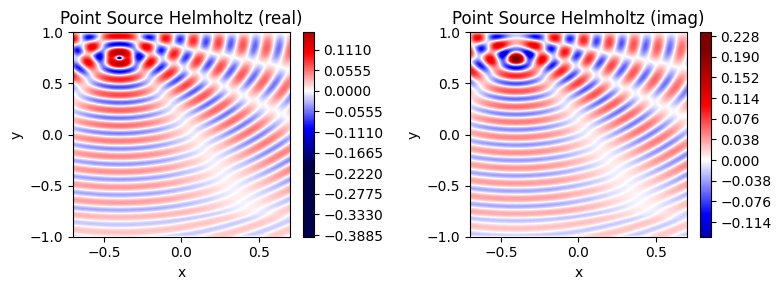

In [23]:
plot_field0(model.to('cpu'), 0.7, Ly)

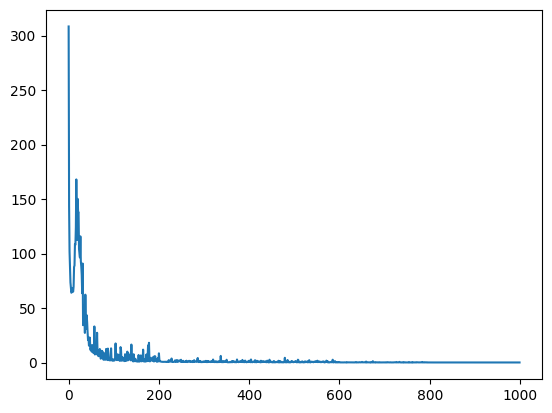

In [24]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

In [25]:
import joblib
joblib.dump(model.state_dict(), 'model_green.joblib')

['model_green.joblib']

In [26]:
def plot_field1(model, Lx, Ly, src=src, k=k):
    N = 200
    x, y = np.linspace(-Lx, Lx, N), np.linspace(-Ly, Ly, N)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    g = green(x, y, src, is_tensor=False)
    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    p0 = model(torch.cat([x, y], dim=-1)).detach().numpy()
    p_real, p_imag = p0[:, 0:1], p0[:, 1:2]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('nogreen.jpg')
    plt.tight_layout()

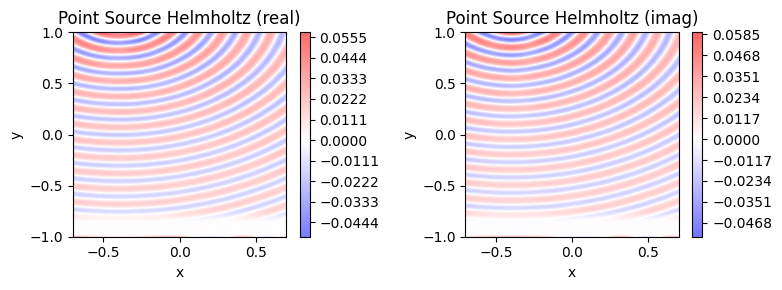

In [27]:
plot_field1(model.to('cpu'), 0.7, Ly)